# Time-series Investigation 

## Set Up

In [1]:
import http.cookiejar as cookielib
import pandas as pd
import requests
import warnings
import logging
import sqlite3
import boto3
import glob
import json
import time
import math
import tqdm
import sys
import os

sys.path.append("/opt/libs")
from apiclass import APIClass,RedshiftClass
from apikeyclass import APIkeyClass
from dotenv import load_dotenv

%load_ext autoreload
%autoreload 2

from sc_experiments import *
import matplotlib.pyplot as plt 
import numpy as np
from scipy.stats.stats import pearsonr

warnings.filterwarnings('ignore')
rs = RedshiftClass('zhiyin','Zhiyin123')

/tmp/ipykernel_2185/2177481959.py:27: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


Successful connection！
 


In [ ]:
# load index
index = pd.read_csv("s3://supply-web-data-storage/CSV/index_hs6.csv")
index.head()
# query = f"select * from logistic_data;"
# index = rs.query_df(query)

In [2]:
# load BOM dictionary
bom = parse_battery_bom()
bom =  {k.lower(): v for k, v in bom.items()}
print('num parts', len(bom))
print('BMS codes', bom['bms'])

num parts 16
BMS codes ['850450', '850730', '850780', '850790', '853222', '853223', '853321', '853340', '853630', '853641', '853890', '854190', '854239', '854290', '854411', '854442', '854449']


In [ ]:
# get companies that sell battery and buy BMS
battery_suppliers = index[index.hs6 == BATTERY].groupby('supplier_t')['bill_count'].sum().rename('battery_supply_count')
bms_buyers = index[index.hs6.isin(bom['bms'])].groupby('buyer_t')['bill_count'].sum().rename('bms_buy_count')
merged = pd.merge(battery_suppliers, bms_buyers, left_index=True, right_index=True, how='inner')  # must have both
display(merged.sort_values('battery_supply_count', ascending=False).head(30))
display(merged.sort_values('bms_buy_count', ascending=False).head(30)) # TODO: panasonic, chinese companies

## Methods

It seems like samsung, samsung electronics, se are very popular. 
Also, lg is fairly popular.

In [3]:
import http.cookiejar as cookielib
import pandas as pd
import requests
import warnings
import logging
import sqlite3
import boto3
import glob
import json
import time
import math
import tqdm
import sys
import os
import datetime

sys.path.append("/opt/libs")
from apiclass import APIClass,RedshiftClass
from apikeyclass import APIkeyClass
from dotenv import load_dotenv

warnings.filterwarnings('ignore')
rs = RedshiftClass('zhiyin','Zhiyin123')

Successful connection！
 


In [18]:
import re
THRESHOLD = 100
def get_transaction_df(PROD='battery', tx_type='supplier', companies=[]):
    '''
    Args:
        PROD (str or Tuple(str)): a string type key of bom or a tuple of strings that are general hs_codes
                                    such as 'bms' or ('850670', '482110',)
        tx_type (str): 'supplier' or 'buyer'
        companies (list(str)): company keywords for SQL query

    Returns:
        pandas.dataframe: transaction dataframe
        str: identifier name of the csv, such as 'samsung', 'lg', 'all', etc.
        
        If both 'None', error state
    '''
    # get transactions where company is supplying/buying PROD
    all_dfs = []
    hs_codes = bom[PROD] if PROD in bom else PROD
    name = PROD if PROD in bom else "baseline"
    tx_col = 'supplier_t' if tx_type=='supplier' else 'buyer_t' if tx_type=='buyer' else None
    for hs in hs_codes:
        if len(companies) >= 1:
            tx_string = f"{tx_col} like '{companies[0]}'" + "".join([f" or {tx_col} like '{company}'" for company in companies[1:]])
            query = f"select * from logistic_data where ({tx_string} and hs_code like '{hs}%');"
        else:
            query = f"select * from logistic_data where hs_code like '{hs}%';"
        df = rs.query_df(query)
        
        if df is not None:
            print(hs, '->', len(df), len(df.drop_duplicates()))
            df['hs_code'] = df['hs_code'].str[:6]
            all_dfs.append(df.drop_duplicates())
        else:
            # no results found for this query
            print(hs, '-> None')
    
    if len(all_dfs) == 0:
        print("No df to concatnate")
        return None, None
    
    all_dfs = pd.concat(all_dfs).drop_duplicates()
    print("all df shape is", all_dfs.shape)
    assert(len(all_dfs)==len(all_dfs.drop_duplicates()))  # should be the same length
    
    # save transactions
    if len(companies) >= 1:
        csv_name = " ".join(re.findall("[a-zA-Z]+", companies[0]))
    else:
        csv_name = "all"
    
    all_dfs = all_dfs.sort_values('date')
    all_dfs.to_csv(f'{name}_{tx_type}_{csv_name}.csv', index=False)
    display(all_dfs.head())
    
    return all_dfs, csv_name

def preprocess_transaction_data(SUPPLY_PROD='battery', BUY_PROD='bms', companies=[]):
    '''
    Args:
        SUPPLY_PROD (str or Tuple(str)): a string type key of bom or a tuple of strings that are general hs_codes
                                    such as 'bms' or ('850670', '482110',) for supplying
        BUY_PROD (str or Tuple(str)): same as SUPPLY_PROD, but for buying
        companies (list(str)): company keywords for SQL query

    Returns:
        pandas.dataframe: supply dataframe
        pandas.dataframe: buy dataframe
        str: identifier name of the csv, such as 'samsung', 'lg', 'all', etc.
    '''
    print("Getting supply df...")
    supply_df, csv_name = get_transaction_df(PROD=SUPPLY_PROD, tx_type='supplier', companies=companies)
    print("Getting buy df...")
    buy_df, csv_name = get_transaction_df(PROD=BUY_PROD, tx_type='buyer', companies=companies)
    
    return supply_df, buy_df, csv_name

# supply_df, buy_df, csv_name = preprocess_transaction_data(companies=[])
# supply_df, buy_df, csv_name = preprocess_transaction_data(companies=['%samsung%', 'sehc', 'sevt'])
# supply_df, buy_df, csv_name = preprocess_transaction_data(companies=['%lg %', 'lgdvh', 'lgevh', 'lgitvh'])

In [5]:
def load_df(supply_name='battery', buy_name='bms', csv_name='samsung'):
    supply_df = pd.read_csv(f'{supply_name}_supplier_{csv_name}.csv')
    buy_df = pd.read_csv(f'{buy_name}_buyer_{csv_name}.csv')
    print(len(supply_df), len(buy_df))
    return supply_df, buy_df

def get_transaction_time_df(SUPPLY_PROD='battery', BUY_PROD='bms', csv_name='samsung'):
    '''
    Add daily, weekly, and monthly datetime columns.
    '''
    supply_name = SUPPLY_PROD if SUPPLY_PROD in bom else "baseline" 
    buy_name = BUY_PROD if BUY_PROD in bom else "baseline"
    print(f"Supply name is {supply_name}; buy name is {buy_name}")
    
    supply_df, buy_df = load_df(supply_name=supply_name, buy_name=buy_name, csv_name=csv_name)

    # convert date to datetime
    supply_df['datetime'] = pd.to_datetime(supply_df.date)
    buy_df['datetime'] = pd.to_datetime(buy_df.date)

    # extract month from date string
    supply_df['month'] = supply_df.date.apply(lambda x: x.rsplit('-', 1)[0])
    buy_df['month'] = buy_df.date.apply(lambda x: x.rsplit('-', 1)[0])

    # convert month to datetime
    supply_df['month_datetime'] = pd.to_datetime(supply_df.month)
    buy_df['month_datetime'] = pd.to_datetime(buy_df.month)

    # extract week from datetime.dt
    supply_df['week'] = supply_df.datetime.dt.strftime("%G-%V-1")
    buy_df['week'] = buy_df.datetime.dt.strftime("%G-%V-1")

    # convert week to datetime
    supply_df['week_datetime'] = supply_df.week.apply(lambda x: datetime.date.fromisocalendar(int(x.rsplit('-', 2)[0]), int(x.rsplit('-', 2)[1]), 1))
    buy_df['week_datetime'] = buy_df.week.apply(lambda x: datetime.date.fromisocalendar(int(x.rsplit('-', 2)[0]), int(x.rsplit('-', 2)[1]), 1))

    display(supply_df.head()[['date', 'datetime', 'month', 'month_datetime', 'week', 'week_datetime']])
    
    return supply_df, buy_df
# supply_df, buy_df = get_transaction_time_df(SUPPLY_PROD='battery', BUY_PROD='bms', csv_name='samsung')

In [6]:
def get_time_col(time):
    if time.lower()=='daily':
        return 'datetime'
    elif time.lower()=='weekly':
        return 'week_datetime'
    elif time.lower()=='monthly':
        return 'month_datetime'
    raise Exception("Time window is not supported")

def plot_time_versus_sale_purchase(supply_df, buy_df, SUPPLY_PROD='battery', BUY_PROD='bms', time='monthly'):
    '''Plot sale info (quantity and amount) over time
    Args:
        time (str): supports 'daily', 'weekly', or 'monthly'
    '''
    time_col = get_time_col(time)
    supply_name = SUPPLY_PROD if SUPPLY_PROD in bom else "baseline" 
    buy_name = BUY_PROD if BUY_PROD in bom else "baseline" 
    
    # plot time-ly sales vs daily purchases
    supply_summary = supply_df.groupby(time_col)[['quantity', 'amount']].sum()
    buy_summary = buy_df.groupby(time_col)[['quantity', 'amount']].sum()

    # plot quantity
    fig, axes = plt.subplots(2, 1, figsize=(8, 7), sharex=True)
    ax = axes[0]           
    ax.set_title(f'{time} sales of {supply_name}', fontsize=12)
    ax.plot(supply_summary.index, supply_summary.quantity.values)
    ax.set_ylabel('Total quantity', fontsize=12)
    ax = axes[1]
    ax.set_title(f'{time} purchases of {buy_name}', fontsize=12)
    ax.plot(buy_summary.index, buy_summary.quantity.values)
    ax.set_ylabel('Total quantity', fontsize=12)
    plt.show()

    # plot amount
    fig, axes = plt.subplots(2, 1, figsize=(8, 7), sharex=True)
    ax = axes[0]           
    ax.set_title(f'{time} sales of {supply_name}', fontsize=12)
    ax.plot(supply_summary.index, np.log(supply_summary.amount.values))
    ax.set_ylabel('Total amount, log ($)', fontsize=12)
    ax = axes[1]
    ax.set_title(f'{time} purchases of {buy_name}', fontsize=12)
    ax.plot(buy_summary.index, np.log(buy_summary.amount.values))
    ax.set_ylabel('Total amount, log ($)', fontsize=12)
    plt.show()
    
# plot_time_versus_sale_purchase(supply_df, buy_df)

In [7]:
def compare_sale_purchase_quantity_per_hscode(supply_df, buy_df, SUPPLY_PROD='battery', BUY_PROD='bms', time='monthly'):
    '''Calculate correlation for sale info (quantity) over time per supply hs_code, buy hs_code
    Args:
        time (str): supports 'daily', 'weekly', or 'monthly'
    '''
    supply_hs_codes = bom[SUPPLY_PROD] if SUPPLY_PROD in bom else SUPPLY_PROD
    buy_hs_codes = bom[BUY_PROD] if BUY_PROD in bom else BUY_PROD
    supply_name = SUPPLY_PROD if SUPPLY_PROD in bom else "baseline" 
    buy_name = BUY_PROD if BUY_PROD in bom else "baseline" 
    time_col = get_time_col(time)
    
    supply_df['hs_code_str'] = supply_df.hs_code.astype(str)  # convert HS code to str
    buy_df['hs_code_str'] = buy_df.hs_code.astype(str)  # convert HS code to str

    for supply_hs in supply_hs_codes:
        sub_supply_df = supply_df[supply_df.hs_code_str.str.contains(supply_hs)]
        if len(sub_supply_df) > THRESHOLD:
            supply_summary = sub_supply_df.groupby(time_col).quantity.sum()
            fig, axes = plt.subplots(2, 1, figsize=(8, 7), sharex=True)
            ax = axes[0]           
            ax.set_title(f'{time} sales of {supply_hs}', fontsize=12)
            ax.plot(supply_summary.index, supply_summary.values)
            ax.set_ylabel('Total quantity', fontsize=12)

            ax = axes[1]
            ax.set_title(f'{time} purchases of {buy_name}', fontsize=12)
            for buy_hs in buy_hs_codes:
                sub_buy_df = buy_df[buy_df.hs_code_str.str.contains(buy_hs)]
                if len(sub_buy_df) > THRESHOLD:
                    buy_summary = sub_buy_df.groupby(time_col).quantity.sum()
                    # merge to find common months
                    merged = pd.merge(supply_summary.rename('x'), buy_summary.rename('y'), 
                                      left_index=True, right_index=True, how='inner')
                    r, p = pearsonr(merged.x, merged.y)
                    print(buy_hs, len(sub_buy_df), 'r=%.3f (n=%d, p=%.3f)' % (r, len(merged), p)) # number of transaction, n is number of dates
                    # normalize by mean to make comparison easier
                    ax.plot(buy_summary.index, buy_summary.values / np.mean(buy_summary.values), label=buy_hs)
                else:
                    print(buy_hs, len(sub_buy_df))
            ax.legend(bbox_to_anchor=(1,1))
            ax.set_ylabel('Total quantity (normalized)', fontsize=12)
            plt.show()
        else:
            print(supply_hs, len(sub_supply_df))
            
# compare_sale_purchase_quantity_per_hscode(supply_df, buy_df)

In [8]:
def mega_sale_purchase_pipeline(SUPPLY_PROD='battery', BUY_PROD='bms', csv_name='samsung'):
    print("Mega Analysis of Sale - Purchase Pipeline on Daily, Weekly, and Monthly Scale\n")
    print("Assume Transaction Data Has Been Queried and Preprocessed...")
    print("Constructing Transaction Time Dataframe...Loading from csv...")
    supply_df, buy_df = get_transaction_time_df(SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, csv_name=csv_name)
    print("Plotting sale, purchase over time...")
    plot_time_versus_sale_purchase(supply_df, buy_df, SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, time='daily')
    plot_time_versus_sale_purchase(supply_df, buy_df, SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, time='weekly')
    plot_time_versus_sale_purchase(supply_df, buy_df, SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, time='monthly')
    print("Compare sale, purchase quantity per hscode...")
    compare_sale_purchase_quantity_per_hscode(supply_df, buy_df, SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, time="daily")
    compare_sale_purchase_quantity_per_hscode(supply_df, buy_df, SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, time="weekly")
    compare_sale_purchase_quantity_per_hscode(supply_df, buy_df, SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, time="monthly")
    return supply_df, buy_df

## Battery & BMS Time-Series Analysis
1. Companies that purchases BMS and sells battery
2. Signs of propagation? What time scale? Go into their transactions, plot out quarter by quarter, aggregated BMS, battery.
3. Correlation (Pearson)
    a. BMS, Battery time series
    b. Global parameter needed? across companies

### How does companies like Samsung do? 

In [122]:
print(preprocess_transaction_data(companies=['%samsung%', 'sehc', 'sevt']))

Getting supply df...
850760 -> 440362 42467


id        date                   supplier_t  \
84285   643121462892638219  2019-01-22  samsung electronics co.,ltd   
80719   643439784297312272  2019-03-01         samsung sdi co., ltd   
47622   641883782091452434  2019-03-01         samsung sdi co., ltd   
149091  643439656194879498  2019-03-02         samsung sdi co., ltd   
149092  641883806644908040  2019-03-02         samsung sdi co., ltd   

                             supplier_id  \
84285   c7bc34d9d3bc34b8af6314cc7cee128c   
80719   1e75b89cb9183414b4aa198e39fd62e0   
47622   1e75b89cb9183414b4aa198e39fd62e0   
149091  1e75b89cb9183414b4aa198e39fd62e0   
149092  1e75b89cb9183414b4aa198e39fd62e0   

                                          buyer_t  \
84285   cong ty tnhh samsung electronics việt nam   
80719                          incell as sa de cv   
47622                          incell as sa de cv   
149091                         incell as sa de cv   
149092                         incell as sa de cv   

                                buyer_id      quantity quantity_unit  \
84285   74b972186d553fc89d835e821645b9f3     25.000000           PCE   
80719   164a3cccceed37909791d9fcfe58b191  32116.300781          Kilo   
47622   164a3cccceed37909791d9fcfe58b191  32116.339844      Kilogram   
149091  164a3cccceed37909791d9fcfe58b191  15883.599609          Kilo   
149092  164a3cccceed37909791d9fcfe58b191  15883.639648      Kilogram   

            price        amount  ...  sub_bill_no             orig_port  \
84285    6.989900  1.747481e+02  ...               INCHEON INTL APT SEO   
80719         NaN  1.028730e+06  ...                                      
47622   32.031261  1.028727e+06  ...                                      
149091        NaN  5.087730e+05  ...                                      
149092  32.031265  5.087731e+05  ...                                      

       dest_port   teu         data_source trans_type trans_type_code  \
84285     HA NOI  None  IMP_VIETNAM_CD_CVB        AIR             AIR   
80719             None   IMP_MEXICO_CD_ALL        SEA             SEA   
47622             None   IMP_MEXICO_CD_SEA        SEA             SEA   
149091            None   IMP_MEXICO_CD_ALL        SEA             SEA   
149092            None   IMP_MEXICO_CD_SEA        SEA             SEA   

       vessel_name                               supplier_addr  \
84285               (MAETAN DONG) 129 SAMSUNG-RO YEONGTONG-GU,   
80719                                                            
47622                                                            
149091                                                           
149092                                                           

                                               buyer_addr  
84285   KCN Yên Phong 1-xã Yên Trung,Huyện Yên Phong- ...  
80719           CIRCUNVALACION AGUSTIN YAÑEZ 2613 Jalisco  
47622   CIRCUNVALACION AGUSTIN YAEZ 2613 Guadalajara J...  
149091          CIRCUNVALACION AGUSTIN YAÑEZ 2613 Jalisco  
149092  CIRCUNVALACION AGUSTIN YAEZ 2613 Guadalajara J...  

[5 rows x 26 columns]

Getting buy df...
850450 -> 440764 42576
850730 -> 863960 96990
850780 -> None
850790 -> 515 83
853222 -> 3606 2232
853223 -> 20428 3561
853321 -> 3590 910
853340 -> 1321620 141602
853630 -> 49883 9139
853641 -> 10349 1326
853890 -> 2919 656
854190 -> 7345 1992
854239 -> 2 1
854290 -> 1021814 136150
854411 -> 152 94
854442 -> 962 625
854449 -> 307465 79673


id        date                        supplier_t  \
304138  643119102757777425  2019-01-02              samsung asia pte ltd   
361581  639821542924300333  2019-01-02                      wacom co ltd   
832596  643119101541429258  2019-01-02              samsung asia pte ltd   
811501  643119104531968015  2019-01-02  maxscend technologies hk limited   
585047  643119104531968014  2019-01-02  maxscend technologies hk limited   

                             supplier_id  \
304138  eabd108b691d3b5893b892973839466d   
361581  b1db939fbc543194a09d93a255cf7f64   
832596  eabd108b691d3b5893b892973839466d   
811501  2d571b7ec0ac37e7b7f25b42ba362d85   
585047  2d571b7ec0ac37e7b7f25b42ba362d85   

                                          buyer_t  \
304138  cong ty tnhh samsung electronics việt nam   
361581          pt. samsung electronics indonesia   
832596  cong ty tnhh samsung electronics việt nam   
811501  cong ty tnhh samsung electronics việt nam   
585047  cong ty tnhh samsung electronics việt nam   

                                buyer_id  quantity quantity_unit   price  \
304138  74b972186d553fc89d835e821645b9f3   10000.0           PCE  1.1618   
361581  56a18d36a1c13b0a87b8051026e2607b    3000.0           PCE     NaN   
832596  74b972186d553fc89d835e821645b9f3   90000.0           PCE  0.1807   
811501  74b972186d553fc89d835e821645b9f3  510000.0           PCE  0.0765   
585047  74b972186d553fc89d835e821645b9f3  186000.0           PCE  0.0303   

              amount  ... sub_bill_no         orig_port  \
304138  11618.083008  ...                     SINGAPORE   
361581   5287.994629  ...              NARITA APT TOKYO   
832596  16261.309570  ...                        PUDONG   
811501  38999.578125  ...                        PUDONG   
585047   5633.934570  ...                        PUDONG   

                         dest_port   teu           data_source trans_type  \
304138                      HA NOI  None    IMP_VIETNAM_CD_CVB        AIR   
361581  CENGKARENG SUKARNO HATTA U  None  IMP_INDONESIA_CD_DEF        AIR   
832596                      HA NOI  None    IMP_VIETNAM_CD_CVB        AIR   
811501                      HA NOI  None    IMP_VIETNAM_CD_CVB        AIR   
585047                      HA NOI  None    IMP_VIETNAM_CD_CVB        AIR   

       trans_type_code vessel_name  \
304138             AIR               
361581             AIR               
832596             AIR               
811501             AIR               
585047             AIR               

                                            supplier_addr  \
304138  30 PASIR PANJANG ROAD #17-31/32 MAPLETREE BUSI...   
361581     SHINJUKU GRAND TOWER 31F 8 17 1 NISHI SHINJUKU   
832596  30 PASIR PANJANG ROAD #17-31/32 MAPLETREE BUSI...   
811501  FLAT / RM 1611B 16/F HO KING COMMER CIAL CENTR...   
585047  FLAT / RM 1611B 16/F HO KING COMMER CIAL CENTR...   

                                               buyer_addr  
304138  KCN Yên Phong I, Xã Yên Trung, Huyện Yên Phong...  
361581  JL.JABABEKA RAYA BLOK F NO.29-33 KWS INDUSTRI ...  
832596  KCN Yên Phong I, Xã Yên Trung, Huyện Yên Phong...  
811501  KCN Yên Phong I, Xã Yên Trung, Huyện Yên Phong...  
585047  KCN Yên Phong I, Xã Yên Trung, Huyện Yên Phong...  

[5 rows x 26 columns]

(                        id        date                     supplier_t  \
84285   643121462892638219  2019-01-22    samsung electronics co.,ltd   
80719   643439784297312272  2019-03-01           samsung sdi co., ltd   
47622   641883782091452434  2019-03-01           samsung sdi co., ltd   
149091  643439656194879498  2019-03-02           samsung sdi co., ltd   
149092  641883806644908040  2019-03-02           samsung sdi co., ltd   
...                    ...         ...                            ...   
179     757011072197931014  2023-02-28  tianjin samsung sdi co ., ltd   
345664  757011072197931013  2023-02-28  tianjin samsung sdi co ., ltd   
80906   757011072239874054  2023-02-28            samsung sdi co. ltd   
47769   757011072202125317  2023-02-28  tianjin samsung sdi co ., ltd   
188139  756944276912680967  2023-02-28   samsung sdi vietnam co., ltd   

                             supplier_id  \
84285   c7bc34d9d3bc34b8af6314cc7cee128c   
80719   1e75b89cb9183414b4aa198e39

Mega Analysis of Sale - Purchase Pipeline on Daily, Weekly, and Monthly Scale

Assume Transaction Data Has Been Queried and Preprocessed...
Constructing Transaction Time Dataframe...Loading from csv...
Supply name is battery; buy name is bms
42467 517610


date   datetime    month month_datetime       week week_datetime
0  2019-01-22 2019-01-22  2019-01     2019-01-01  2019-04-1    2019-01-21
1  2019-03-01 2019-03-01  2019-03     2019-03-01  2019-09-1    2019-02-25
2  2019-03-01 2019-03-01  2019-03     2019-03-01  2019-09-1    2019-02-25
3  2019-03-02 2019-03-02  2019-03     2019-03-01  2019-09-1    2019-02-25
4  2019-03-02 2019-03-02  2019-03     2019-03-01  2019-09-1    2019-02-25

Plotting sale, purchase over time...


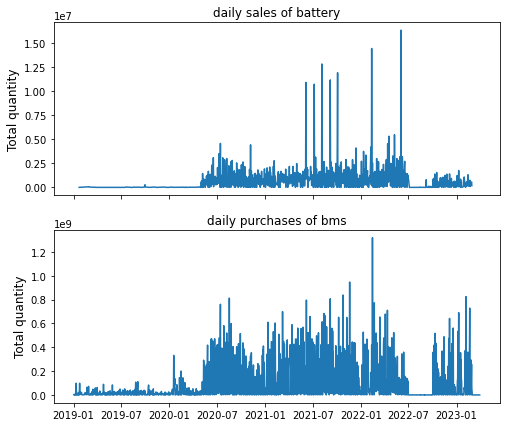

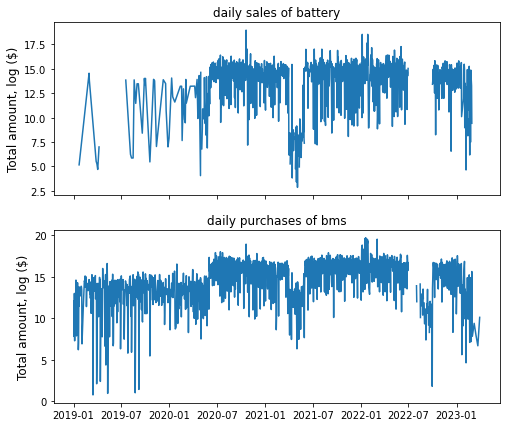

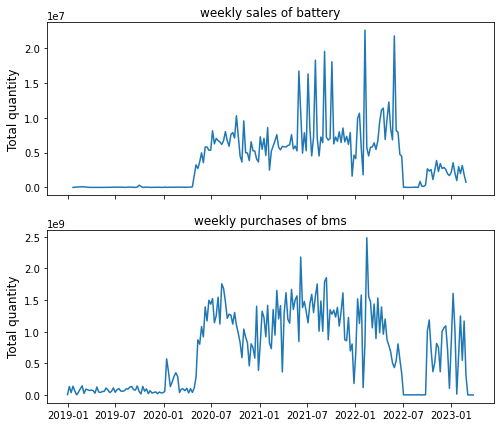

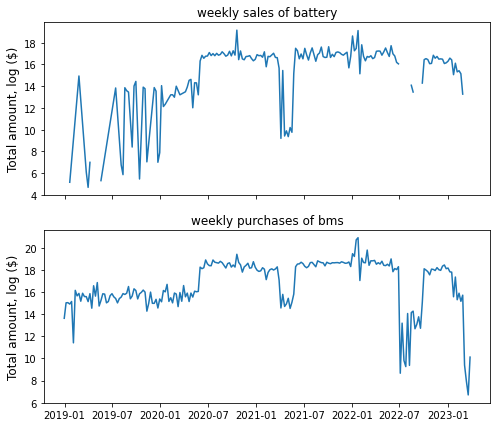

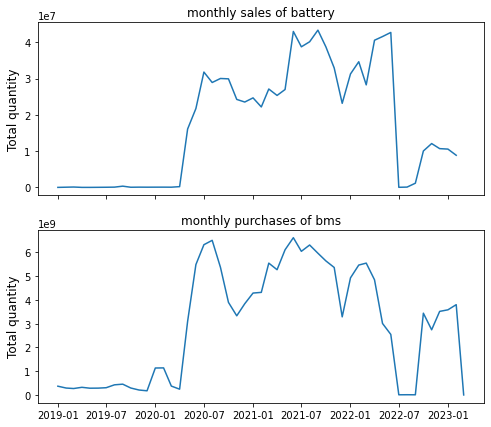

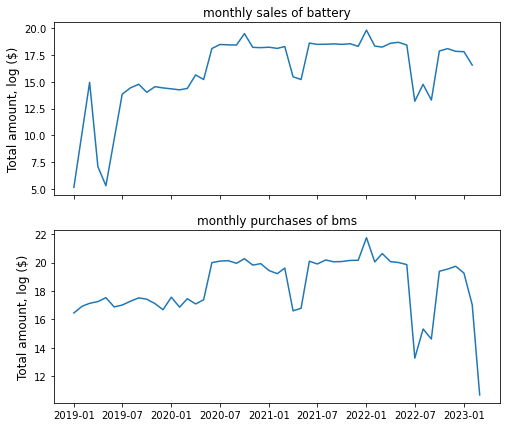

Compare sale, purchase quantity per hscode...
850450 96990 r=0.226 (n=859, p=0.000)
850730 0
850780 83
850790 2232 r=0.062 (n=264, p=0.313)
853222 3561 r=0.074 (n=534, p=0.087)
853223 910
853321 141602 r=0.208 (n=811, p=0.000)
853340 9139 r=0.117 (n=729, p=0.002)
853630 1326 r=0.066 (n=472, p=0.154)
853641 656
853890 1992 r=0.148 (n=531, p=0.001)
854190 1
854239 136150 r=0.270 (n=941, p=0.000)
854290 94
854411 625
854442 79673 r=0.190 (n=929, p=0.000)
854449 0


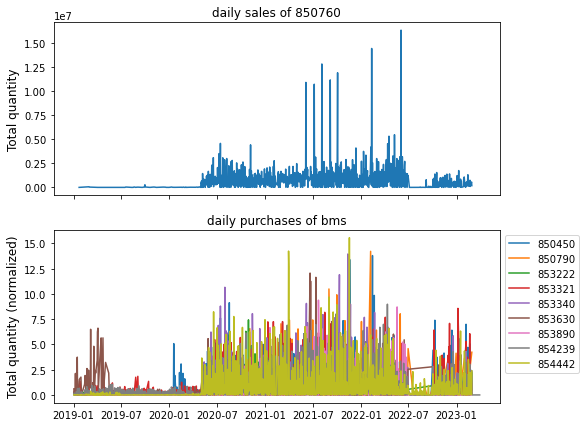

850450 96990 r=0.549 (n=182, p=0.000)
850730 0
850780 83
850790 2232 r=0.341 (n=124, p=0.000)
853222 3561 r=0.304 (n=143, p=0.000)
853223 910
853321 141602 r=0.498 (n=172, p=0.000)
853340 9139 r=0.378 (n=171, p=0.000)
853630 1326 r=0.184 (n=152, p=0.023)
853641 656
853890 1992 r=0.550 (n=144, p=0.000)
854190 1
854239 136150 r=0.633 (n=184, p=0.000)
854290 94
854411 625
854442 79673 r=0.657 (n=184, p=0.000)
854449 0


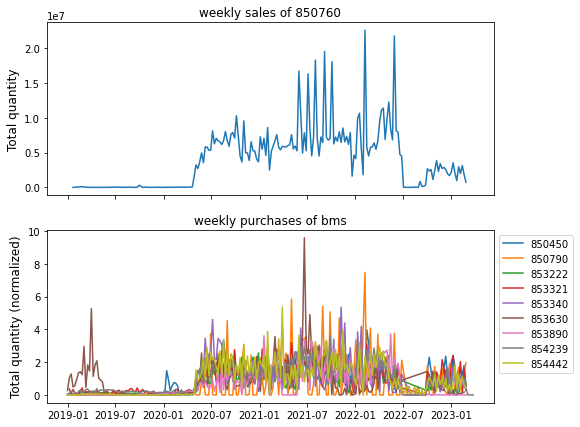

850450 96990 r=0.833 (n=48, p=0.000)
850730 0
850780 83
850790 2232 r=0.688 (n=35, p=0.000)
853222 3561 r=0.729 (n=39, p=0.000)
853223 910
853321 141602 r=0.843 (n=46, p=0.000)
853340 9139 r=0.754 (n=47, p=0.000)
853630 1326 r=0.539 (n=45, p=0.000)
853641 656
853890 1992 r=0.826 (n=38, p=0.000)
854190 1
854239 136150 r=0.910 (n=48, p=0.000)
854290 94
854411 625
854442 79673 r=0.857 (n=48, p=0.000)
854449 0


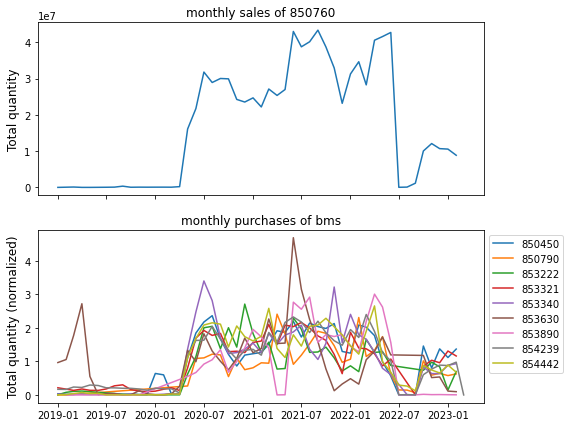

In [123]:
supply_df, buy_df = mega_sale_purchase_pipeline(csv_name='samsung')

### What about LG?

In [269]:
print(preprocess_transaction_data(companies=['%lg %', 'lgdvh', 'lgevh', 'lgitvh']))

Getting supply df...
850760 -> 2649 1281


id        date                     supplier_t  \
2485  638370708889874440  2019-01-06                    lg chem ltd   
2     638372997469909001  2019-01-14                    lg chem ltd   
1119  640702053846691849  2019-04-22  lg electronics india pvt. ltd   
2033  641848539351429127  2019-09-30                    lg chem ltd   
61    638296307670528006  2020-04-23                   lg chem, ltd   

                           supplier_id  \
2485  990e23f5c0ad3e63aabfa5e349b1404e   
2     990e23f5c0ad3e63aabfa5e349b1404e   
1119  90e7344010253981abd9e295080fca5f   
2033  990e23f5c0ad3e63aabfa5e349b1404e   
61    990e23f5c0ad3e63aabfa5e349b1404e   

                                          buyer_t  \
2485                                  lg chem ltd   
2                                     lg chem ltd   
1119                           lg electronics inc   
2033  vincular testing labs india private limited   
61                                   lg chem, ltd   

                              buyer_id  quantity quantity_unit    price  \
2485  990e23f5c0ad3e63aabfa5e349b1404e      40.0           PCS      NaN   
2     990e23f5c0ad3e63aabfa5e349b1404e      40.0           BAG      NaN   
1119  9fa2a1d616683b07848b0839d017a7a2    1082.0           SET   7.6800   
2033  affe12ed26573982856a478a1860178b      47.0           NOS  13.8568   
61    990e23f5c0ad3e63aabfa5e349b1404e      35.0           CTN      NaN   

           amount  ...       sub_bill_no               orig_port  \
2485          NaN  ...  HDMUBUCA9292376A                   BUSAN   
2             NaN  ...  HDMUBUCA9292937A                   BUSAN   
1119  8309.759766  ...                    NHAVA SHEVA SEA INNSA1   
2033   651.000000  ...                                             
61            NaN  ...     MAEU596417635                YANGSHAN   

                       dest_port   teu         data_source         trans_type  \
2485      LOS ANGELES CALIFORNIA   2.0  IMP_AMERICA_BL_SEA  SEA NON-CONTAINER   
2         LOS ANGELES CALIFORNIA   2.0  IMP_AMERICA_BL_SEA  SEA NON-CONTAINER   
1119                       PUSAN   NaN    EXP_INDIA_CD_DEF                SEA   
2033  DELHI AIR CARGO ACC INDEL4   NaN    IMP_INDIA_CD_DEF                AIR   
61            OAKLAND CALIFORNIA  10.0  IMP_AMERICA_BL_SEA  SEA NON-CONTAINER   

        trans_type_code      vessel_name  \
2485  SEA NON-CONTAINER   HYUNDAI GLOBAL   
2     SEA NON-CONTAINER  HYUNDAI COURAGE   
1119                SEA                    
2033                AIR                    
61    SEA NON-CONTAINER     GERDA MAERSK   

                                          supplier_addr  \
2485  lg twin towers,20 yoido-dong youngdungpo-gu, s...   
2     lg twin towers,20 yoido-dong youngdungpo-gu, s...   
1119  PLOT NO.51, UDYOG VIHAR, SURAJPURKASNA ROAD, G...   
2033                                                      
61    yeouido-dong 20 yeongdungpo-gu seul korea polu...   

                                             buyer_addr  
2485  lg twin tower, 20 yoido-dong youngd ungpo-gu, ...  
2     lg twin towers,20 yoido-dong youngdungpo-gu, s...  
1119                                                     
2033  18-19, MINISWAMAPPA BUILDING, OPP  MASALA HOTE...  
61    yeouido-dong 20 yeongdungpo-gu seul korea polu...  

[5 rows x 26 columns]

Getting buy df...
850450 -> 56349 43373
850730 -> 3 1
850780 -> 14 14
850790 -> 104 70
853222 -> 3975 3156
853223 -> 49 19
853321 -> 96232 74744
853340 -> 4230 3228
853630 -> 2 2
853641 -> 128 96
853890 -> 5237 1095
854190 -> None
854239 -> 5853 4434
854290 -> 4 2
854411 -> 46 15
854442 -> 19920 8415
854449 -> 157 62


id        date                       supplier_t  \
15919  641652877875818511  2019-01-14           ооо лг электроникс рус   
3253   639034712951959589  2019-01-22  allegro microsystems phils. inc   
34     639034713006485524  2019-01-24  allegro microsystems phils. inc   
41     638389423924654083  2019-03-27               lg electronics inc   
10336  640697380838387717  2019-03-29    lg electronics india pvt. ltd   

                            supplier_id             buyer_t  \
15919  a4ed74fdacee3db2a4a0271b3e966cf5  lg electronics inc   
3253   4a40e1dc11cc376c8aff6e77938bf68c  lg electronics inc   
34     4a40e1dc11cc376c8aff6e77938bf68c  lg electronics inc   
41     9fa2a1d616683b07848b0839d017a7a2  lg electronics inc   
10336  90e7344010253981abd9e295080fca5f  lg electronics inc   

                               buyer_id  quantity quantity_unit price  \
15919  9fa2a1d616683b07848b0839d017a7a2       0.0                 NaN   
3253   9fa2a1d616683b07848b0839d017a7a2       1.0        CARTON   NaN   
34     9fa2a1d616683b07848b0839d017a7a2       1.0        CARTON   NaN   
41     9fa2a1d616683b07848b0839d017a7a2     155.0           CTN   NaN   
10336  9fa2a1d616683b07848b0839d017a7a2    1200.0           SET  0.67   

             amount  ...  sub_bill_no                   orig_port  \
15919  24133.259766  ...                                            
3253     675.750000  ...                NINOY AQUINO INTL AIRPORT   
34       675.750000  ...                NINOY AQUINO INTL AIRPORT   
41              NaN  ...                                    BUSAN   
10336    804.000000  ...               SAHAR AIR CARGO ACC INBOM4   

                   dest_port   teu             data_source         trans_type  \
15919                         None       EXP_RUSSIA_CD_DEF                      
3253                          None  EXP_PHILIPPINES_CD_DEF                      
34                            None  EXP_PHILIPPINES_CD_DEF                      
41     LONG BEACH CALIFORNIA  12.0      IMP_AMERICA_BL_SEA  SEA CONTAINERIZED   
10336                  SEOUL  None        EXP_INDIA_CD_DEF                AIR   

         trans_type_code  vessel_name  \
15919            UNKNOWN                
3253             UNKNOWN           OZ   
34               UNKNOWN           OZ   
41     SEA CONTAINERIZED  OOCL LONDON   
10336                AIR                

                                           supplier_addr  \
15919  143160, МОСКОВСКАЯ область РУЗСКИЙ район, СП Д...   
3253   4756 SAMPAGUITA STREET MARIMAR VILLAGE BRGY SU...   
34     4756 SAMPAGUITA STREET MARIMAR VILLAGE BRGY SU...   
41     lg twin towers 128, yeoui-daero youngdungpo-gu...   
10336  PLOT NO.51, UDYOG VIHAR, SURAJPURKASNA ROAD, G...   

                                              buyer_addr  
15919  150-721, ЛГ ТВИН ТАУЭРС 20, СЕУЛ, ЙЕИДО-ДОНГ, ...  
3253                                                      
34                                                        
41     . 1000 sylvan avenue , englewood cliffs, nj, 0...  
10336                                                     

[5 rows x 26 columns]

(                      id        date  \
2485  638370708889874440  2019-01-06   
2     638372997469909001  2019-01-14   
1119  640702053846691849  2019-04-22   
2033  641848539351429127  2019-09-30   
61    638296307670528006  2020-04-23   
...                  ...         ...   
1450  737069723784916995  2022-11-25   
2594  737076156865785860  2022-12-01   
1918  737076156874174470  2022-12-01   
2111  737076158627393538  2022-12-21   
2619  751889196983332867  2023-01-09   

                                     supplier_t  \
2485                                lg chem ltd   
2                                   lg chem ltd   
1119              lg electronics india pvt. ltd   
2033                                lg chem ltd   
61                                 lg chem, ltd   
...                                         ...   
1450  lg electronics vietnam hai phong co., ltd   
2594  lg electronics vietnam hai phong co., ltd   
1918  lg electronics vietnam hai phong co., ltd   
2111  lg

Mega Analysis of Sale - Purchase Pipeline on Daily, Weekly, and Monthly Scale

Assume Transaction Data Has Been Queried and Preprocessed...
Constructing Transaction Time Dataframe...Loading from csv...
Supply name is battery; buy name is bms
1281 138726


date   datetime    month month_datetime       week week_datetime
0  2019-01-06 2019-01-06  2019-01     2019-01-01  2019-01-1    2018-12-31
1  2019-01-14 2019-01-14  2019-01     2019-01-01  2019-03-1    2019-01-14
2  2019-04-22 2019-04-22  2019-04     2019-04-01  2019-17-1    2019-04-22
3  2019-09-30 2019-09-30  2019-09     2019-09-01  2019-40-1    2019-09-30
4  2020-04-23 2020-04-23  2020-04     2020-04-01  2020-17-1    2020-04-20

Plotting sale, purchase over time...


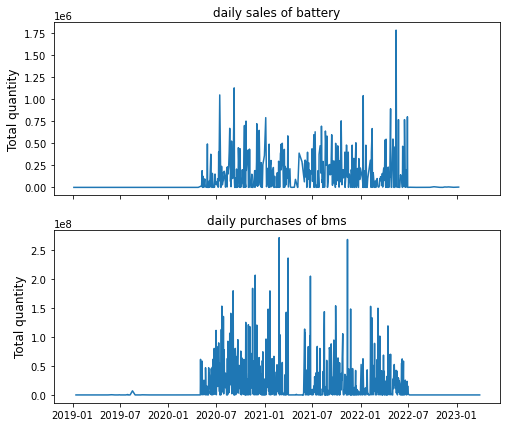

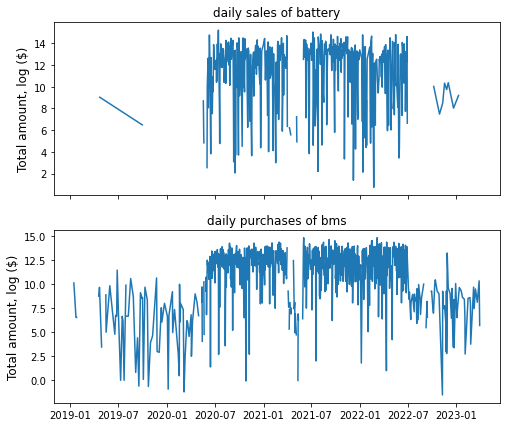

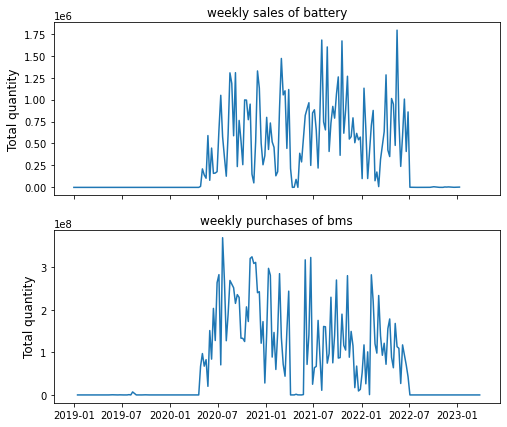

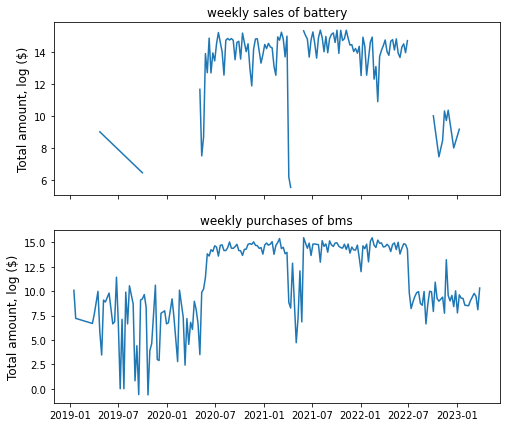

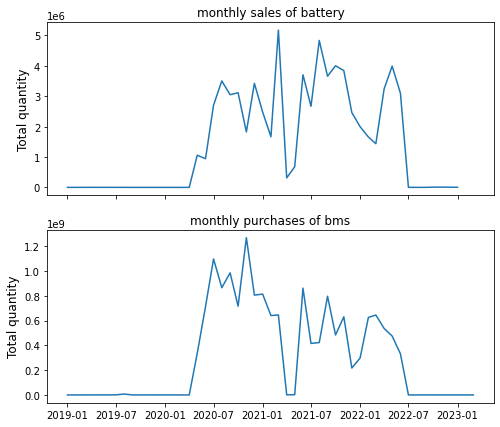

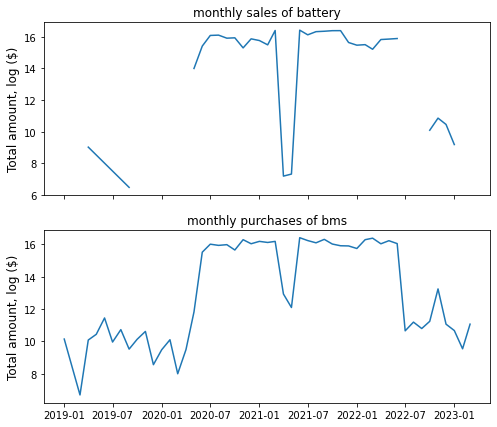

Compare sale, purchase quantity per hscode...
850450 43373 r=-0.018 (n=371, p=0.729)
850730 1
850780 14
850790 70
853222 3156 r=0.017 (n=281, p=0.775)
853223 19
853321 74744 r=0.064 (n=370, p=0.216)
853340 3228 r=-0.044 (n=305, p=0.444)
853630 2
853641 96
853890 1095 r=-0.028 (n=160, p=0.725)
854190 0
854239 4434 r=0.131 (n=353, p=0.014)
854290 2
854411 15
854442 8415 r=0.037 (n=394, p=0.465)
854449 62


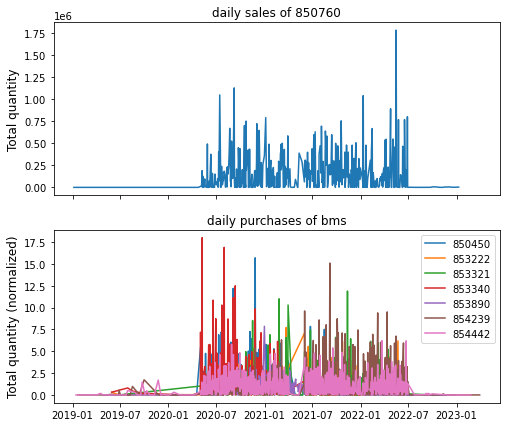

850450 43373 r=-0.062 (n=110, p=0.519)
850730 1
850780 14
850790 70
853222 3156 r=0.013 (n=105, p=0.897)
853223 19
853321 74744 r=0.176 (n=110, p=0.066)
853340 3228 r=-0.201 (n=105, p=0.040)
853630 2
853641 96
853890 1095 r=-0.065 (n=69, p=0.596)
854190 0
854239 4434 r=0.389 (n=121, p=0.000)
854290 2
854411 15
854442 8415 r=0.143 (n=114, p=0.129)
854449 62


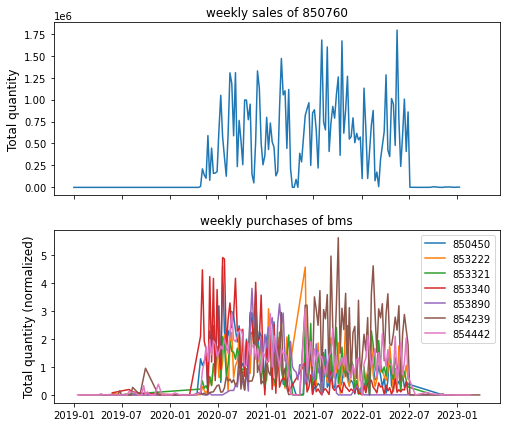

850450 43373 r=0.227 (n=29, p=0.236)
850730 1
850780 14
850790 70
853222 3156 r=0.182 (n=24, p=0.395)
853223 19
853321 74744 r=0.499 (n=27, p=0.008)
853340 3228 r=-0.223 (n=25, p=0.283)
853630 2
853641 96
853890 1095 r=0.198 (n=24, p=0.354)
854190 0
854239 4434 r=0.700 (n=37, p=0.000)
854290 2
854411 15
854442 8415 r=0.716 (n=33, p=0.000)
854449 62


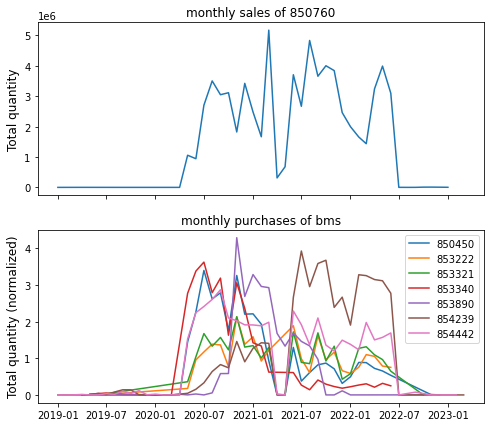

In [270]:
supply_df, buy_df = mega_sale_purchase_pipeline(csv_name='lg')

### What about across companies?

In [ ]:
print(preprocess_transaction_data(companies=[]))

In [ ]:
supply_df, buy_df = mega_sale_purchase_pipeline(csv_name='all')

## Baseline Construction

### Method

In [271]:
warnings.filterwarnings('ignore')
rs = RedshiftClass('zhiyin','Zhiyin123')

Successful connection！
 


In [95]:
import itertools

def get_baseline_hs6(tx_type=None, hs_codes=None, companies=[], TOPCNT=10):
    '''If provided hs_codes, we return that. Otherwise, select top TOPCNT==10 non-battery-hs6-codes 
    from all hscodes as baseline.
    Args:
        hs_codes (None or list(str)): list of potential hs codes of interest
        companies (list(str)): company keywords for SQL query

    Returns:
        list(str): baseline hs6 codes
    '''
    battery_hs6_set = set(list(itertools.chain.from_iterable(bom.values()))) # All hs6 codes battery
    BASELINE_HS6 = []
    
    # SQL query to all hs_code, sum(quantity) for LG
    tx_col = 'supplier_t' if tx_type=='supplier' else 'buyer_t' if tx_type=='buyer' else None
    if len(companies) >= 1:
        tx_string = f"{tx_col} like '{companies[0]}'" + "".join([f" or {tx_col} like '{company}'" for company in companies[1:]])
        query = f"select hs_code, sum(quantity) from logistic_data where ({tx_string}) group by hs_code;"
    else:
        query = f"select hs_code, sum(quantity) from logistic_data group by hs_code;"
    print(query)
    df = rs.query_df(query)
    all_hs_codes = df.sort_values('sum', ascending=False).hs_code.values 
        
    if hs_codes==None:    
        for idx in range(min(len(all_hs_codes), TOPCNT)):
            hs_code = all_hs_codes[idx]
            if hs_code[:6] not in battery_hs6_set: # When checking, take first six digits. When saving, use original
                BASELINE_HS6.append(hs_code) 
    else:
        for hs_code in all_hs_codes:
            if hs_code[:6] in set(hs_codes):
                BASELINE_HS6.append(hs_code)
            
    return BASELINE_HS6

# get_baseline_hs6(tx_type='supplier', hs_codes=['482110', '480591'], companies=['%samsung%', 'sehc', 'sevt'])
# get_baseline_hs6(tx_type='supplier', companies=['%samsung%', 'sehc', 'sevt'])

In [94]:
def baseline(SUPPLY_PROD = 'battery', 
             BUY_PROD = 'bms', 
             companies = ['%samsung%', 'sehc', 'sevt'],
             tx_type = 'buyer', 
             hs_codes = ['482110', '480591']):
    BASELINE_HS6 = get_baseline_hs6(tx_type=tx_type, 
                                hs_codes=hs_codes, 
                                companies=companies)
    
    BASELINE_HS6 = [hs6[:6] for hs6 in BASELINE_HS6] # Added to focus on only hs6 level 
    
    if tx_type=='buyer':
        BUY_PROD = tuple(BASELINE_HS6)
    elif tx_type=='supplier':
        SUPPLY_PROD = tuple(BASELINE_HS6)
    else:
        raise Exception("Invalid tx_type value")
        
    supply_df, buy_df, csv_name = preprocess_transaction_data(SUPPLY_PROD=SUPPLY_PROD, 
                                                              BUY_PROD=BUY_PROD, 
                                                              companies=companies)
    print(f"CSV name is {csv_name}...")
    supply_df, buy_df = mega_sale_purchase_pipeline(SUPPLY_PROD=SUPPLY_PROD,
                                                    BUY_PROD=BUY_PROD, 
                                                    csv_name=csv_name)
    return

### Baseline Samsung - Supply battery, Buy office supply

In [318]:
warnings.filterwarnings('ignore')
rs = RedshiftClass('zhiyin','Zhiyin123')

Successful connection！
 


select hs_code, sum(quantity) from logistic_data where (buyer_t like '%samsung%' or buyer_t like 'sehc' or buyer_t like 'sevt') group by hs_code;
Getting supply df...
850760 -> 440764 42576


id        date                   supplier_t  \
127227  643121462892638219  2019-01-22  samsung electronics co.,ltd   
93287   641883782091452434  2019-03-01         samsung sdi co., ltd   
569     643439784297312272  2019-03-01         samsung sdi co., ltd   
82      643439656194879498  2019-03-02         samsung sdi co., ltd   
83      641883806644908040  2019-03-02         samsung sdi co., ltd   

                             supplier_id  \
127227  c7bc34d9d3bc34b8af6314cc7cee128c   
93287   1e75b89cb9183414b4aa198e39fd62e0   
569     1e75b89cb9183414b4aa198e39fd62e0   
82      1e75b89cb9183414b4aa198e39fd62e0   
83      1e75b89cb9183414b4aa198e39fd62e0   

                                          buyer_t  \
127227  cong ty tnhh samsung electronics việt nam   
93287                          incell as sa de cv   
569                            incell as sa de cv   
82                             incell as sa de cv   
83                             incell as sa de cv   

                                buyer_id      quantity quantity_unit  \
127227  74b972186d553fc89d835e821645b9f3     25.000000           PCE   
93287   164a3cccceed37909791d9fcfe58b191  32116.339844      Kilogram   
569     164a3cccceed37909791d9fcfe58b191  32116.300781          Kilo   
82      164a3cccceed37909791d9fcfe58b191  15883.599609          Kilo   
83      164a3cccceed37909791d9fcfe58b191  15883.639648      Kilogram   

            price        amount  ...  sub_bill_no             orig_port  \
127227   6.989900  1.747481e+02  ...               INCHEON INTL APT SEO   
93287   32.031261  1.028727e+06  ...                                      
569           NaN  1.028730e+06  ...                                      
82            NaN  5.087730e+05  ...                                      
83      32.031265  5.087731e+05  ...                                      

       dest_port   teu         data_source trans_type trans_type_code  \
127227    HA NOI  None  IMP_VIETNAM_CD_CVB        AIR             AIR   
93287             None   IMP_MEXICO_CD_SEA        SEA             SEA   
569               None   IMP_MEXICO_CD_ALL        SEA             SEA   
82                None   IMP_MEXICO_CD_ALL        SEA             SEA   
83                None   IMP_MEXICO_CD_SEA        SEA             SEA   

       vessel_name                               supplier_addr  \
127227              (MAETAN DONG) 129 SAMSUNG-RO YEONGTONG-GU,   
93287                                                            
569                                                              
82                                                               
83                                                               

                                               buyer_addr  
127227  KCN Yên Phong 1-xã Yên Trung,Huyện Yên Phong- ...  
93287   CIRCUNVALACION AGUSTIN YAEZ 2613 Guadalajara J...  
569             CIRCUNVALACION AGUSTIN YAÑEZ 2613 Jalisco  
82              CIRCUNVALACION AGUSTIN YAÑEZ 2613 Jalisco  
83      CIRCUNVALACION AGUSTIN YAEZ 2613 Guadalajara J...  

[5 rows x 26 columns]

Getting buy df...
48211090 -> 383952 43666
48059190000 -> 10 4
48059190100 -> 1 1
48059110000 -> 89 23


id        date             supplier_t  \
170952  643124953803468801  2019-03-06  imarketchina co., ltd   
170951  643125034665455623  2019-03-22  imarketchina co., ltd   
81578   643127618214113300  2019-04-05  imarketchina co., ltd   
20686   643127654545174557  2019-04-12  imarketchina co., ltd   
73428   643127654805221407  2019-04-12  imarketchina co., ltd   

                             supplier_id  \
170952  fb97a5b6ae273b62a7344807916fa080   
170951  fb97a5b6ae273b62a7344807916fa080   
81578   fb97a5b6ae273b62a7344807916fa080   
20686   fb97a5b6ae273b62a7344807916fa080   
73428   fb97a5b6ae273b62a7344807916fa080   

                                          buyer_t  \
170952  cong ty tnhh samsung electronics việt nam   
170951  cong ty tnhh samsung electronics việt nam   
81578   cong ty tnhh samsung electronics việt nam   
20686   cong ty tnhh samsung electronics việt nam   
73428   cong ty tnhh samsung electronics việt nam   

                                buyer_id quantity quantity_unit   price  \
170952  74b972186d553fc89d835e821645b9f3   2000.0           PCE  0.0004   
170951  74b972186d553fc89d835e821645b9f3   2000.0           PCE  0.0004   
81578   74b972186d553fc89d835e821645b9f3   2000.0           PCE  0.0004   
20686   74b972186d553fc89d835e821645b9f3   2000.0           PCE  0.0004   
73428   74b972186d553fc89d835e821645b9f3   1000.0           PCE  0.0056   

        amount  ...  sub_bill_no orig_port dest_port   teu  \
170952    0.84  ...               SHENZHEN    HA NOI  None   
170951    0.86  ...               SHENZHEN    HA NOI  None   
81578     0.86  ...               SHENZHEN    HA NOI  None   
20686     0.82  ...               SHENZHEN    HA NOI  None   
73428     5.62  ...               SHENZHEN    HA NOI  None   

               data_source trans_type trans_type_code vessel_name  \
170952  IMP_VIETNAM_CD_CVB        AIR             AIR               
170951  IMP_VIETNAM_CD_CVB        AIR             AIR               
81578   IMP_VIETNAM_CD_CVB        AIR             AIR               
20686   IMP_VIETNAM_CD_CVB        AIR             AIR               
73428   IMP_VIETNAM_CD_CVB        AIR             AIR               

                                            supplier_addr buyer_addr  
170952  19TH FL, TIANXIN BUILDING, NO. 125 TIANJIN,CHI...             
170951  19TH FL, TIANXIN BUILDING, NO. 125 TIANJIN,CHI...             
81578   19TH FL, TIANXIN BUILDING, NO. 125 TIANJIN,CHI...             
20686   19TH FL, TIANXIN BUILDING, NO. 125 TIANJIN,CHI...             
73428   19TH FL, TIANXIN BUILDING, NO. 125 TIANJIN,CHI...             

[5 rows x 26 columns]

CSV name is samsung...
Mega Analysis of Sale - Purchase Pipeline on Daily, Weekly, and Monthly Scale

Assume Transaction Data Has Been Queried and Preprocessed...
Constructing Transaction Time Dataframe...Loading from csv...
Supply name is battery; buy name is baseline
42576 43694


date   datetime    month month_datetime       week week_datetime
0  2019-01-22 2019-01-22  2019-01     2019-01-01  2019-04-1    2019-01-21
1  2019-03-01 2019-03-01  2019-03     2019-03-01  2019-09-1    2019-02-25
2  2019-03-01 2019-03-01  2019-03     2019-03-01  2019-09-1    2019-02-25
3  2019-03-02 2019-03-02  2019-03     2019-03-01  2019-09-1    2019-02-25
4  2019-03-02 2019-03-02  2019-03     2019-03-01  2019-09-1    2019-02-25

Plotting sale, purchase over time...


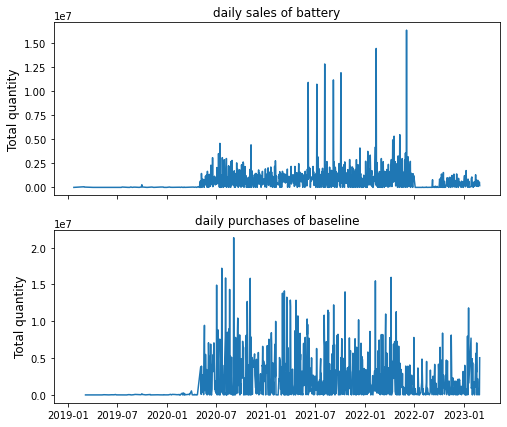

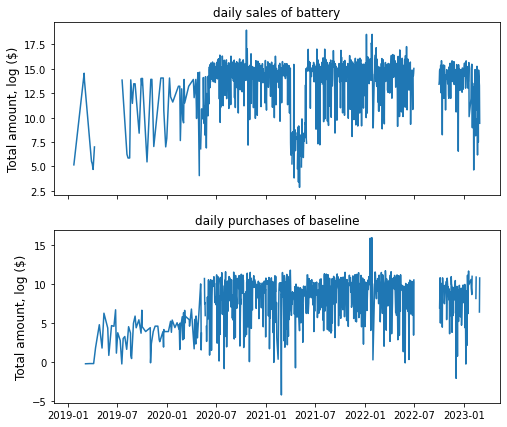

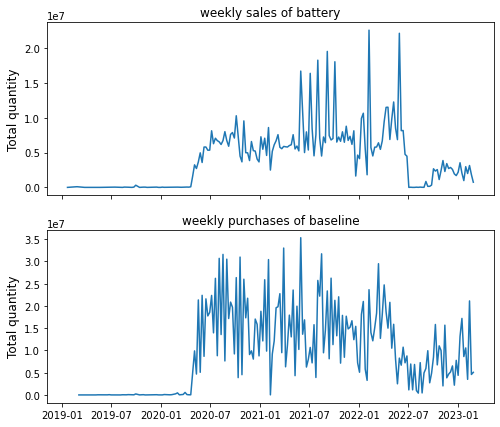

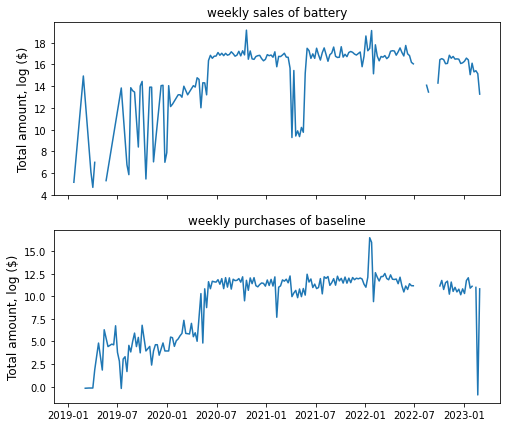

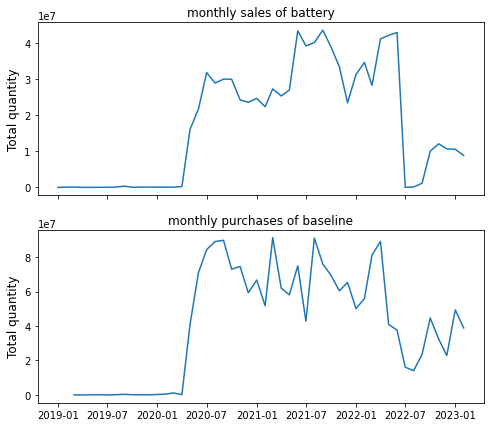

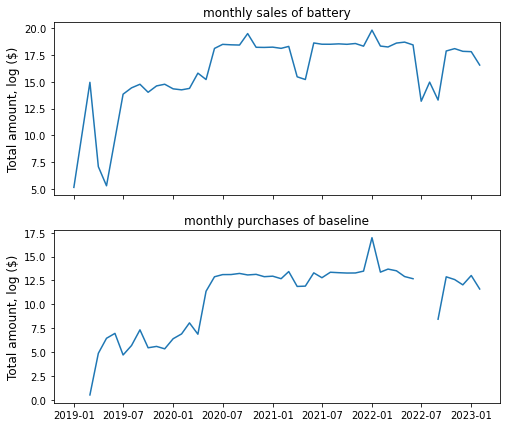

Compare sale, purchase quantity per hscode...
48211090 43666 r=0.074 (n=819, p=0.034)
48059190000 4
48059190100 1
48059110000 23


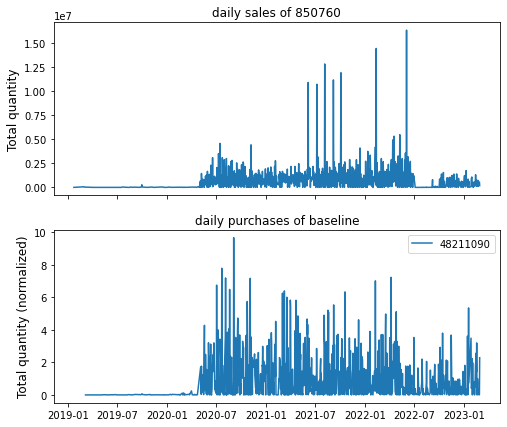

48211090 43666 r=0.605 (n=176, p=0.000)
48059190000 4
48059190100 1
48059110000 23


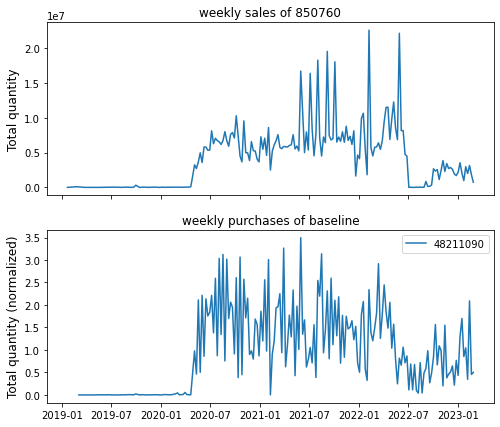

48211090 43666 r=0.845 (n=47, p=0.000)
48059190000 4
48059190100 1
48059110000 23


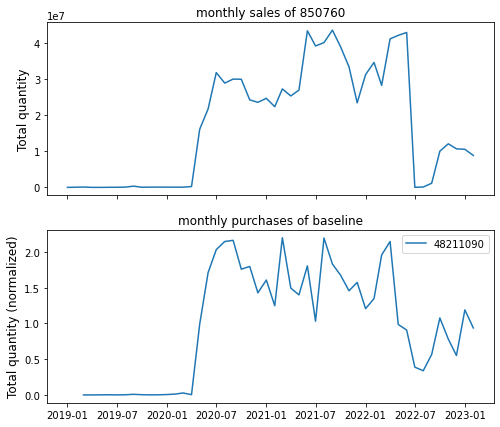

In [319]:
SUPPLY_PROD = 'battery'
BUY_PROD = None
companies = ['%samsung%', 'sehc', 'sevt']
tx_type = 'buyer'
hs_codes = ['482110', '480591']

baseline(SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, companies=companies, tx_type=tx_type, hs_codes=hs_codes)

### Baseline Samsung - Supply office supply, Buy BMS

In [320]:
warnings.filterwarnings('ignore')
rs = RedshiftClass('zhiyin','Zhiyin123')

Successful connection！
 


select hs_code, sum(quantity) from logistic_data where (supplier_t like '%samsung%' or supplier_t like 'sehc' or supplier_t like 'sevt') group by hs_code;
Getting supply df...
48211090 -> 116782 8743
48211020 -> 5255 1354
48059190 -> 4 1


id        date                           supplier_t  \
114811  643127718315372579  2019-04-26  samsung electronics huizhou co.,ltd   
5116    643139685474185239  2019-08-12    samsung china investment co., ltd   
36220   643139718416248843  2019-08-19    samsung china investment co., ltd   
104888  643142609193480211  2019-09-09    samsung china investment co., ltd   
44078   643142727342829597  2019-09-27    samsung china investment co., ltd   

                             supplier_id  \
114811  9e7f0ee8faa03db084fc5c50e5fea0b0   
5116    f9f6eb849e60360386c06d3ccfd72233   
36220   f9f6eb849e60360386c06d3ccfd72233   
104888  f9f6eb849e60360386c06d3ccfd72233   
44078   f9f6eb849e60360386c06d3ccfd72233   

                                          buyer_t  \
114811  cong ty tnhh samsung electronics việt nam   
5116    cong ty tnhh samsung electronics việt nam   
36220   cong ty tnhh samsung electronics việt nam   
104888  cong ty tnhh samsung electronics việt nam   
44078   cong ty tnhh samsung electronics việt nam   

                                buyer_id  quantity quantity_unit   price  \
114811  74b972186d553fc89d835e821645b9f3    3000.0           PCE  0.0415   
5116    74b972186d553fc89d835e821645b9f3   30000.0           PCE  0.0014   
36220   74b972186d553fc89d835e821645b9f3   30000.0           PCE  0.0014   
104888  74b972186d553fc89d835e821645b9f3   60000.0           PCE  0.0014   
44078   74b972186d553fc89d835e821645b9f3   30000.0           PCE  0.0014   

            amount  ... sub_bill_no  orig_port dest_port   teu  \
114811  124.650002  ...              HONG KONG    HA NOI  None   
5116     42.503799  ...                BEIJING    HA NOI  None   
36220    42.549000  ...                BEIJING    HA NOI  None   
104888   84.246002  ...                BEIJING    HA NOI  None   
44078    42.117599  ...                BEIJING    HA NOI  None   

               data_source trans_type trans_type_code vessel_name  \
114811  IMP_VIETNAM_CD_CVB        AIR             AIR               
5116    IMP_VIETNAM_CD_CVB        AIR             AIR               
36220   IMP_VIETNAM_CD_CVB        AIR             AIR               
104888  IMP_VIETNAM_CD_CVB        AIR             AIR               
44078   IMP_VIETNAM_CD_CVB        AIR             AIR               

                                            supplier_addr buyer_addr  
114811  CHENJIANG TOWN,HUIZHOU CITY, GUANGDONG PROVINC...             
5116    HUI AN 8F FORTUNE FINANCIAL CENTER NO5 DONGSAN...             
36220   HUI AN 8F FORTUNE FINANCIAL CENTER NO5 DONGSAN...             
104888  HUI AN, 8F FORTUNE  FINANCIAL  CENTRER NO5 DON...             
44078   FEI XUE 8F FORTUNE  FINANCIAL  CENT NO5 DONGSA...             

[5 rows x 26 columns]

Getting buy df...
850450 -> 863960 96990
850730 -> None
850780 -> 515 83
850790 -> 3606 2232
853222 -> 20428 3561
853223 -> 3590 910
853321 -> 1321620 141602
853340 -> 49883 9139
853630 -> 10349 1326
853641 -> 2919 656
853890 -> 7345 1992
854190 -> 2 1
854239 -> 1021814 136150
854290 -> 152 94
854411 -> 962 625
854442 -> 307465 79673
854449 -> 154683 44647


id        date                        supplier_t  \
28524   643119088807522308  2019-01-02              samsung asia pte ltd   
10621   643119104531968015  2019-01-02  maxscend technologies hk limited   
952095  643119106406821901  2019-01-02  samsung electronics america, inc   
639889  643119102757777425  2019-01-02              samsung asia pte ltd   
298100  643119101541429259  2019-01-02              samsung asia pte ltd   

                             supplier_id  \
28524   eabd108b691d3b5893b892973839466d   
10621   2d571b7ec0ac37e7b7f25b42ba362d85   
952095  df5aa95b96ef3335b67ea587d81f1ac1   
639889  eabd108b691d3b5893b892973839466d   
298100  eabd108b691d3b5893b892973839466d   

                                          buyer_t  \
28524   cong ty tnhh samsung electronics việt nam   
10621   cong ty tnhh samsung electronics việt nam   
952095  cong ty tnhh samsung electronics việt nam   
639889  cong ty tnhh samsung electronics việt nam   
298100  cong ty tnhh samsung electronics việt nam   

                                buyer_id  quantity quantity_unit   price  \
28524   74b972186d553fc89d835e821645b9f3   75000.0           PCE  0.1294   
10621   74b972186d553fc89d835e821645b9f3  510000.0           PCE  0.0765   
952095  74b972186d553fc89d835e821645b9f3  138000.0           PCE  0.0807   
639889  74b972186d553fc89d835e821645b9f3   10000.0           PCE  1.1618   
298100  74b972186d553fc89d835e821645b9f3   35000.0           PCE  0.1398   

              amount  ... sub_bill_no  orig_port dest_port   teu  \
28524    9703.146484  ...                 PUDONG    HA NOI  None   
10621   38999.578125  ...                 PUDONG    HA NOI  None   
952095  11131.623047  ...                 PUDONG    HA NOI  None   
639889  11618.083008  ...              SINGAPORE    HA NOI  None   
298100   4891.832031  ...                 PUDONG    HA NOI  None   

               data_source trans_type trans_type_code vessel_name  \
28524   IMP_VIETNAM_CD_CVB        AIR             AIR               
10621   IMP_VIETNAM_CD_CVB        AIR             AIR               
952095  IMP_VIETNAM_CD_CVB        AIR             AIR               
639889  IMP_VIETNAM_CD_CVB        AIR             AIR               
298100  IMP_VIETNAM_CD_CVB        AIR             AIR               

                                            supplier_addr  \
28524   30 PASIR PANJANG ROAD #17-31/32 MAPLETREE BUSI...   
10621   FLAT / RM 1611B 16/F HO KING COMMER CIAL CENTR...   
952095                 85 CHALLENGER ROAD RIDGEFIELD PARK   
639889  30 PASIR PANJANG ROAD #17-31/32 MAPLETREE BUSI...   
298100  30 PASIR PANJANG ROAD #17-31/32 MAPLETREE BUSI...   

                                               buyer_addr  
28524   KCN Yên Phong I, Xã Yên Trung, Huyện Yên Phong...  
10621   KCN Yên Phong I, Xã Yên Trung, Huyện Yên Phong...  
952095  KCN Yên Phong I, Xã Yên Trung, Huyện Yên Phong...  
639889  KCN Yên Phong I, Xã Yên Trung, Huyện Yên Phong...  
298100  KCN Yên Phong I, Xã Yên Trung, Huyện Yên Phong...  

[5 rows x 26 columns]

CSV name is samsung...
Mega Analysis of Sale - Purchase Pipeline on Daily, Weekly, and Monthly Scale

Assume Transaction Data Has Been Queried and Preprocessed...
Constructing Transaction Time Dataframe...Loading from csv...
Supply name is baseline; buy name is bms
10098 519681


date   datetime    month month_datetime       week week_datetime
0  2019-04-26 2019-04-26  2019-04     2019-04-01  2019-17-1    2019-04-22
1  2019-08-12 2019-08-12  2019-08     2019-08-01  2019-33-1    2019-08-12
2  2019-08-19 2019-08-19  2019-08     2019-08-01  2019-34-1    2019-08-19
3  2019-09-09 2019-09-09  2019-09     2019-09-01  2019-37-1    2019-09-09
4  2019-09-27 2019-09-27  2019-09     2019-09-01  2019-39-1    2019-09-23

Plotting sale, purchase over time...


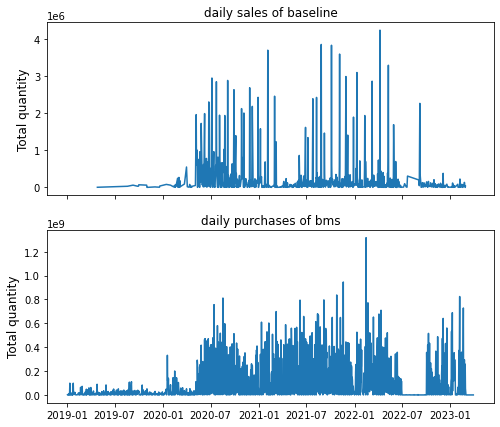

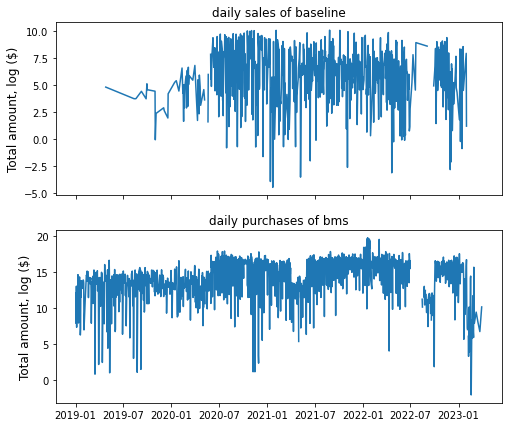

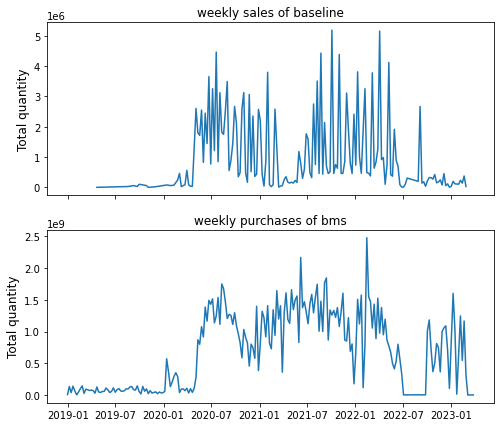

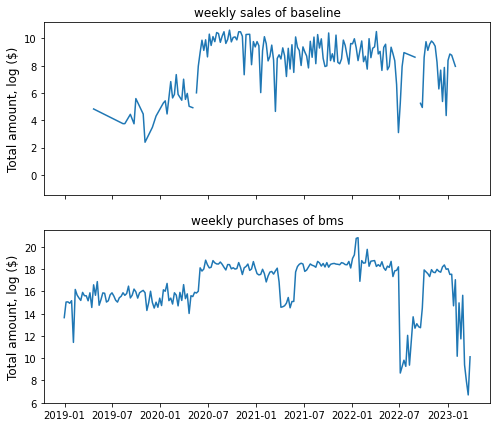

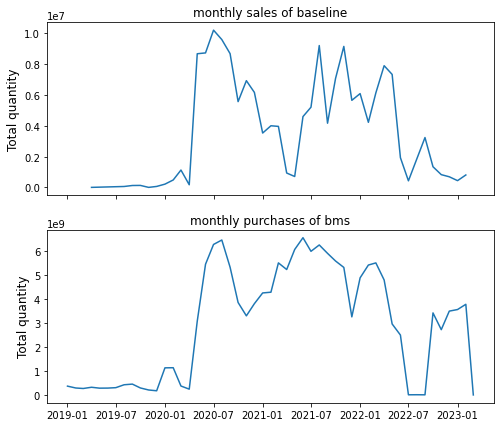

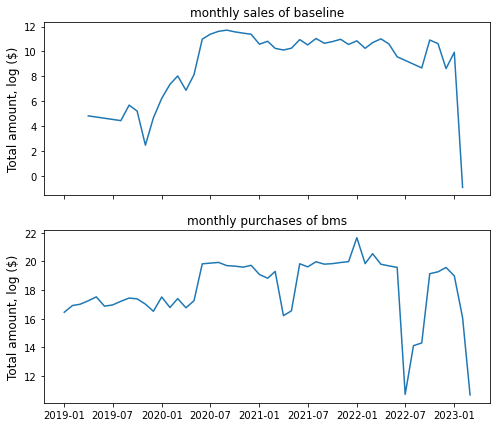

Compare sale, purchase quantity per hscode...
850450 96990 r=0.059 (n=641, p=0.136)
850730 0
850780 83
850790 2232 r=-0.061 (n=211, p=0.377)
853222 3561 r=0.004 (n=454, p=0.933)
853223 910
853321 141602 r=0.090 (n=628, p=0.025)
853340 9139 r=0.074 (n=585, p=0.075)
853630 1326 r=-0.044 (n=389, p=0.385)
853641 656
853890 1992 r=-0.020 (n=432, p=0.683)
854190 1
854239 136150 r=0.091 (n=669, p=0.019)
854290 94
854411 625
854442 79673 r=0.094 (n=660, p=0.016)
854449 44647 r=0.024 (n=568, p=0.562)


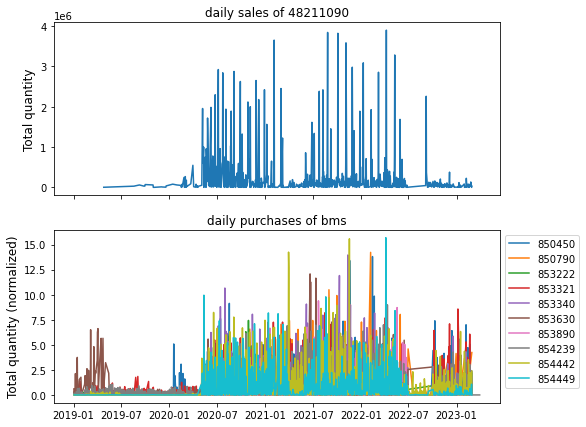

850450 96990 r=-0.133 (n=116, p=0.154)
850730 0
850780 83
850790 2232 r=0.012 (n=31, p=0.947)
853222 3561 r=0.032 (n=80, p=0.781)
853223 910
853321 141602 r=0.003 (n=104, p=0.979)
853340 9139 r=-0.105 (n=97, p=0.304)
853630 1326 r=0.158 (n=66, p=0.207)
853641 656
853890 1992 r=-0.118 (n=77, p=0.305)
854190 1
854239 136150 r=-0.113 (n=117, p=0.225)
854290 94
854411 625
854442 79673 r=-0.016 (n=117, p=0.866)
854449 44647 r=0.044 (n=107, p=0.654)


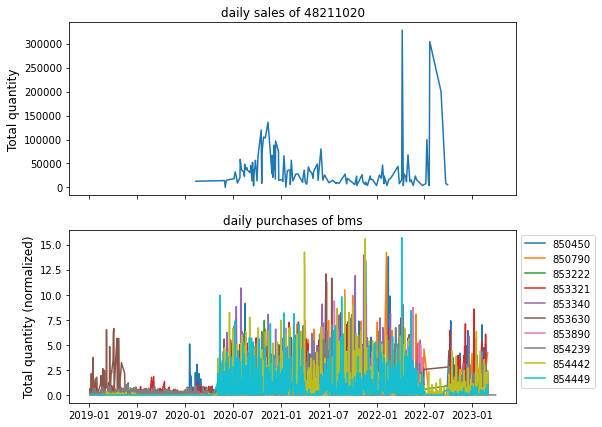

48059190 1
850450 96990 r=0.186 (n=158, p=0.020)
850730 0
850780 83
850790 2232 r=0.135 (n=116, p=0.149)
853222 3561 r=0.097 (n=137, p=0.258)
853223 910
853321 141602 r=0.265 (n=157, p=0.001)
853340 9139 r=0.229 (n=157, p=0.004)
853630 1326 r=0.026 (n=142, p=0.760)
853641 656
853890 1992 r=0.286 (n=135, p=0.001)
854190 1
854239 136150 r=0.238 (n=160, p=0.002)
854290 94
854411 625
854442 79673 r=0.339 (n=160, p=0.000)
854449 44647 r=0.380 (n=140, p=0.000)


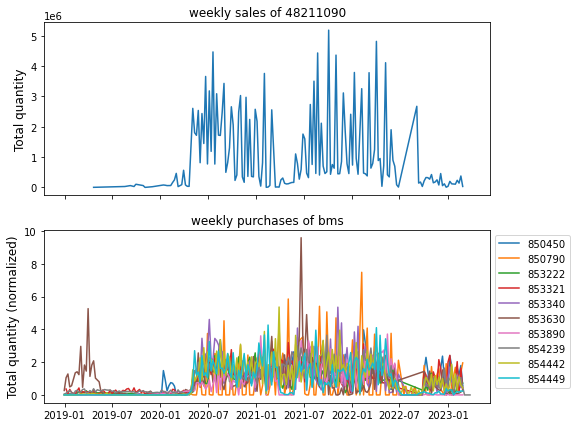

850450 96990 r=-0.240 (n=85, p=0.027)
850730 0
850780 83
850790 2232 r=-0.150 (n=72, p=0.209)
853222 3561 r=0.180 (n=78, p=0.115)
853223 910
853321 141602 r=0.078 (n=80, p=0.492)
853340 9139 r=-0.167 (n=81, p=0.137)
853630 1326 r=-0.000 (n=78, p=0.997)
853641 656
853890 1992 r=-0.070 (n=80, p=0.537)
854190 1
854239 136150 r=-0.255 (n=85, p=0.018)
854290 94
854411 625
854442 79673 r=0.027 (n=85, p=0.806)
854449 44647 r=0.027 (n=81, p=0.812)


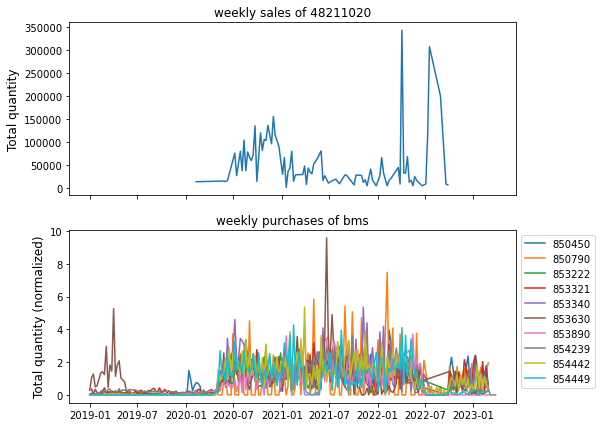

48059190 1
850450 96990 r=0.666 (n=42, p=0.000)
850730 0
850780 83
850790 2232 r=0.137 (n=32, p=0.454)
853222 3561 r=0.622 (n=37, p=0.000)
853223 910
853321 141602 r=0.588 (n=42, p=0.000)
853340 9139 r=0.776 (n=42, p=0.000)
853630 1326 r=0.339 (n=41, p=0.030)
853641 656
853890 1992 r=0.581 (n=34, p=0.000)
854190 1
854239 136150 r=0.674 (n=42, p=0.000)
854290 94
854411 625
854442 79673 r=0.794 (n=42, p=0.000)
854449 44647 r=0.828 (n=40, p=0.000)


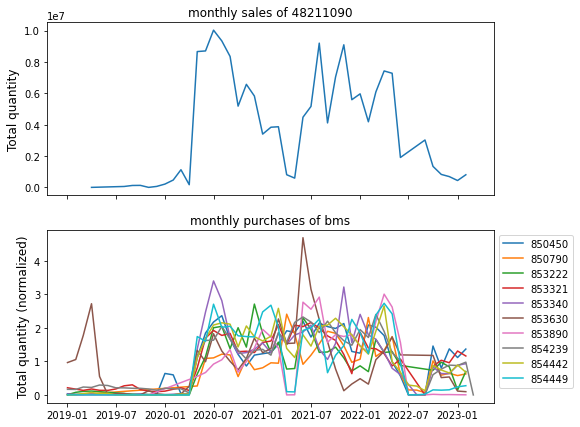

850450 96990 r=-0.258 (n=29, p=0.177)
850730 0
850780 83
850790 2232 r=-0.339 (n=28, p=0.078)
853222 3561 r=0.454 (n=27, p=0.017)
853223 910
853321 141602 r=0.001 (n=28, p=0.998)
853340 9139 r=-0.013 (n=28, p=0.948)
853630 1326 r=-0.012 (n=27, p=0.952)
853641 656
853890 1992 r=-0.210 (n=28, p=0.284)
854190 1
854239 136150 r=-0.241 (n=29, p=0.207)
854290 94
854411 625
854442 79673 r=0.127 (n=29, p=0.513)
854449 44647 r=0.074 (n=29, p=0.701)


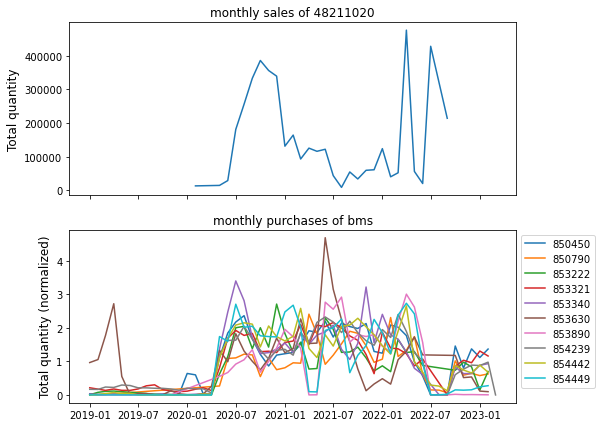

48059190 1


In [321]:
SUPPLY_PROD = None
BUY_PROD = 'bms'
companies = ['%samsung%', 'sehc', 'sevt']
tx_type = 'supplier'
hs_codes = ['482110', '480591']

baseline(SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, companies=companies, tx_type=tx_type, hs_codes=hs_codes)

### Baseline Samsung - Supply battery, Buy Top 10

In [322]:
warnings.filterwarnings('ignore')
rs = RedshiftClass('zhiyin','Zhiyin123')

Successful connection！
 


select hs_code, sum(quantity) from logistic_data where (buyer_t like '%samsung%' or buyer_t like 'sehc' or buyer_t like 'sevt') group by hs_code;
Getting supply df...
850760 -> 440764 42576


id        date                   supplier_t  \
100490  643121462892638219  2019-01-22  samsung electronics co.,ltd   
100683  643439784297312272  2019-03-01         samsung sdi co., ltd   
85334   641883782091452434  2019-03-01         samsung sdi co., ltd   
184969  643439656194879498  2019-03-02         samsung sdi co., ltd   
184970  641883806644908040  2019-03-02         samsung sdi co., ltd   

                             supplier_id  \
100490  c7bc34d9d3bc34b8af6314cc7cee128c   
100683  1e75b89cb9183414b4aa198e39fd62e0   
85334   1e75b89cb9183414b4aa198e39fd62e0   
184969  1e75b89cb9183414b4aa198e39fd62e0   
184970  1e75b89cb9183414b4aa198e39fd62e0   

                                          buyer_t  \
100490  cong ty tnhh samsung electronics việt nam   
100683                         incell as sa de cv   
85334                          incell as sa de cv   
184969                         incell as sa de cv   
184970                         incell as sa de cv   

                                buyer_id      quantity quantity_unit  \
100490  74b972186d553fc89d835e821645b9f3     25.000000           PCE   
100683  164a3cccceed37909791d9fcfe58b191  32116.300781          Kilo   
85334   164a3cccceed37909791d9fcfe58b191  32116.339844      Kilogram   
184969  164a3cccceed37909791d9fcfe58b191  15883.599609          Kilo   
184970  164a3cccceed37909791d9fcfe58b191  15883.639648      Kilogram   

            price        amount  ...  sub_bill_no             orig_port  \
100490   6.989900  1.747481e+02  ...               INCHEON INTL APT SEO   
100683        NaN  1.028730e+06  ...                                      
85334   32.031261  1.028727e+06  ...                                      
184969        NaN  5.087730e+05  ...                                      
184970  32.031265  5.087731e+05  ...                                      

       dest_port   teu         data_source trans_type trans_type_code  \
100490    HA NOI  None  IMP_VIETNAM_CD_CVB        AIR             AIR   
100683            None   IMP_MEXICO_CD_ALL        SEA             SEA   
85334             None   IMP_MEXICO_CD_SEA        SEA             SEA   
184969            None   IMP_MEXICO_CD_ALL        SEA             SEA   
184970            None   IMP_MEXICO_CD_SEA        SEA             SEA   

       vessel_name                               supplier_addr  \
100490              (MAETAN DONG) 129 SAMSUNG-RO YEONGTONG-GU,   
100683                                                           
85334                                                            
184969                                                           
184970                                                           

                                               buyer_addr  
100490  KCN Yên Phong 1-xã Yên Trung,Huyện Yên Phong- ...  
100683          CIRCUNVALACION AGUSTIN YAÑEZ 2613 Jalisco  
85334   CIRCUNVALACION AGUSTIN YAEZ 2613 Guadalajara J...  
184969          CIRCUNVALACION AGUSTIN YAÑEZ 2613 Jalisco  
184970  CIRCUNVALACION AGUSTIN YAEZ 2613 Guadalajara J...  

[5 rows x 26 columns]

Getting buy df...
85322400 -> 1012852 134788
85414010 -> 192012 48653
85411000 -> 260531 35231
85489090 -> 235049 34776
85369094 -> 284314 47261
85177021 -> 4407268 710447


id        date                          supplier_t  \
222415  643119101541429264  2019-01-02                samsung asia pte ltd   
627095  643119098559279116  2019-01-02  samsung electro-mechanics co., ltd   
8168    643119101545623557  2019-01-02                samsung asia pte ltd   
265081  643119098374729740  2019-01-02  samsung electro-mechanics co., ltd   
49226   643119090921451527  2019-01-02  samsung electronics taiwan co.,ltd   

                             supplier_id  \
222415  eabd108b691d3b5893b892973839466d   
627095  d263dd6acf2b3511a14e3ee3d7fcd6ae   
8168    eabd108b691d3b5893b892973839466d   
265081  d263dd6acf2b3511a14e3ee3d7fcd6ae   
49226   637400eb1c5733f59d19a6afef89d7dd   

                                          buyer_t  \
222415  cong ty tnhh samsung electronics việt nam   
627095  cong ty tnhh samsung electronics việt nam   
8168    cong ty tnhh samsung electronics việt nam   
265081  cong ty tnhh samsung electronics việt nam   
49226   cong ty tnhh samsung electronics việt nam   

                                buyer_id    quantity quantity_unit   price  \
222415  74b972186d553fc89d835e821645b9f3      3000.0           PCE  0.0187   
627095  74b972186d553fc89d835e821645b9f3  15960000.0           PCE  0.0016   
8168    74b972186d553fc89d835e821645b9f3      3000.0           PCE  0.0459   
265081  74b972186d553fc89d835e821645b9f3   1500000.0           PCE  0.0043   
49226   74b972186d553fc89d835e821645b9f3    201000.0           PCE  0.0055   

              amount  ...  sub_bill_no orig_port dest_port   teu  \
222415     56.184200  ...                 PUDONG    HA NOI  None   
627095  25388.218750  ...                BEIJING    HA NOI  None   
8168      137.770706  ...                 PUDONG    HA NOI  None   
265081   6412.672363  ...                BEIJING    HA NOI  None   
49226    1101.892578  ...                 PUDONG    HA NOI  None   

               data_source trans_type trans_type_code vessel_name  \
222415  IMP_VIETNAM_CD_CVB        AIR             AIR               
627095  IMP_VIETNAM_CD_CVB        AIR             AIR               
8168    IMP_VIETNAM_CD_CVB        AIR             AIR               
265081  IMP_VIETNAM_CD_CVB        AIR             AIR               
49226   IMP_VIETNAM_CD_CVB        AIR             AIR               

                                            supplier_addr  \
222415  30 PASIR PANJANG ROAD #17-31/32 MAPLETREE BUSI...   
627095  416, MAETAN-3DONG, YEONGTONG-GU, SUWON-SI, GYE...   
8168    30 PASIR PANJANG ROAD #17-31/32 MAPLETREE BUSI...   
265081  416, MAETAN-3DONG, YEONGTONG-GU, SUWON-SI, GYE...   
49226          10F, NO.399, RUI GUANG RD., TAIWAN, R.O.C.   

                                               buyer_addr  
222415  KCN Yên Phong I, Xã Yên Trung, Huyện Yên Phong...  
627095  KCN Yên Phong I, Xã Yên Trung, Huyện Yên Phong...  
8168    KCN Yên Phong I, Xã Yên Trung, Huyện Yên Phong...  
265081  KCN Yên Phong I, Xã Yên Trung, Huyện Yên Phong...  
49226   KCN Yên Phong I, Xã Yên Trung, Huyện Yên Phong...  

[5 rows x 26 columns]

CSV name is samsung...
Mega Analysis of Sale - Purchase Pipeline on Daily, Weekly, and Monthly Scale

Assume Transaction Data Has Been Queried and Preprocessed...
Constructing Transaction Time Dataframe...Loading from csv...
Supply name is battery; buy name is baseline
42576 1011156


date   datetime    month month_datetime       week week_datetime
0  2019-01-22 2019-01-22  2019-01     2019-01-01  2019-04-1    2019-01-21
1  2019-03-01 2019-03-01  2019-03     2019-03-01  2019-09-1    2019-02-25
2  2019-03-01 2019-03-01  2019-03     2019-03-01  2019-09-1    2019-02-25
3  2019-03-02 2019-03-02  2019-03     2019-03-01  2019-09-1    2019-02-25
4  2019-03-02 2019-03-02  2019-03     2019-03-01  2019-09-1    2019-02-25

Plotting sale, purchase over time...


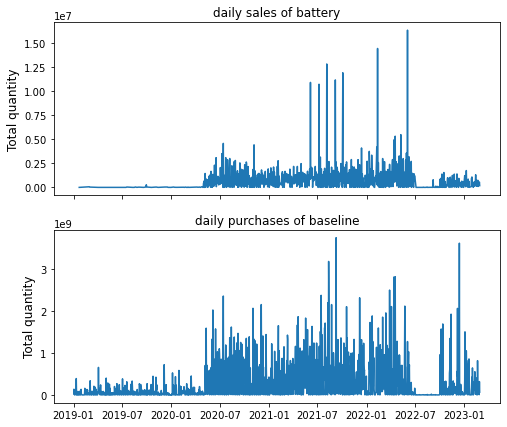

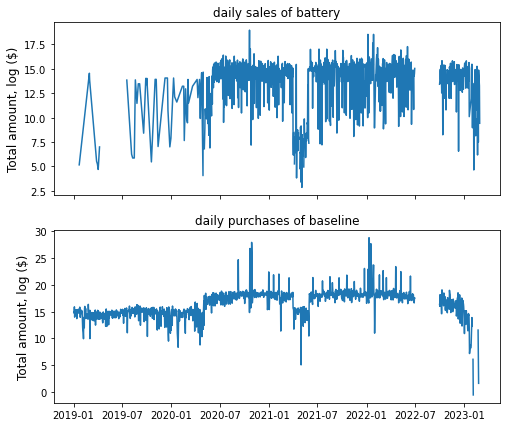

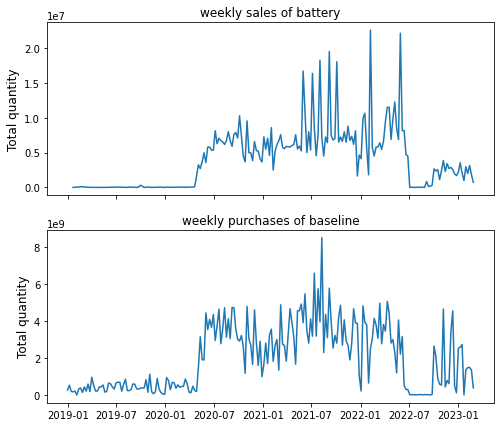

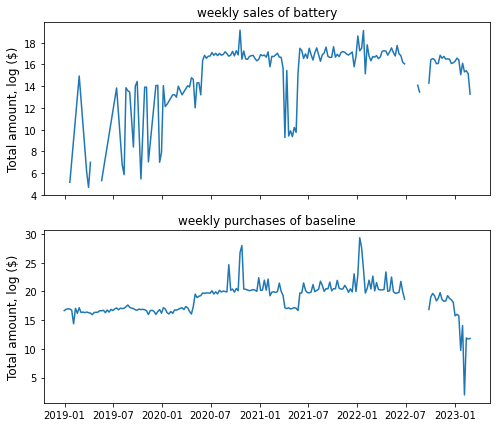

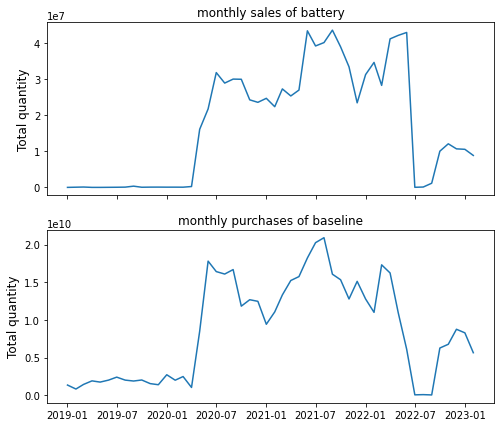

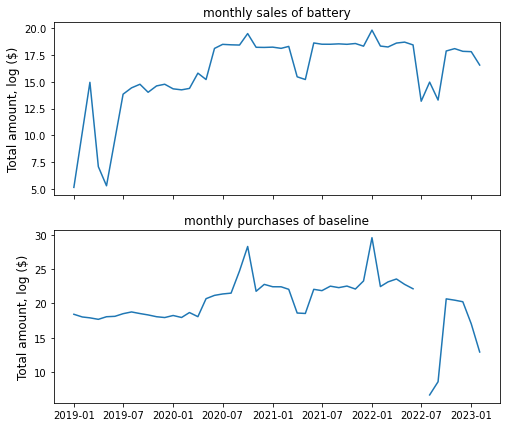

Compare sale, purchase quantity per hscode...
85322400 134788 r=0.209 (n=849, p=0.000)
85414010 48653 r=0.145 (n=788, p=0.000)
85411000 35231 r=0.209 (n=831, p=0.000)
85489090 34776 r=0.169 (n=788, p=0.000)
85369094 47261 r=0.174 (n=886, p=0.000)
85177021 710447 r=0.315 (n=956, p=0.000)


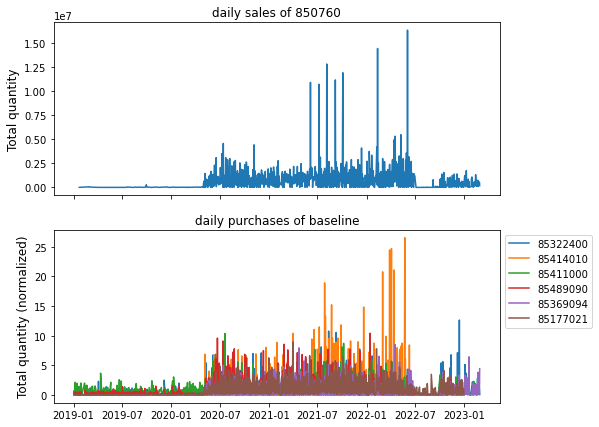

85322400 134788 r=0.499 (n=173, p=0.000)
85414010 48653 r=0.420 (n=161, p=0.000)
85411000 35231 r=0.546 (n=176, p=0.000)
85489090 34776 r=0.492 (n=163, p=0.000)
85369094 47261 r=0.582 (n=165, p=0.000)
85177021 710447 r=0.780 (n=175, p=0.000)


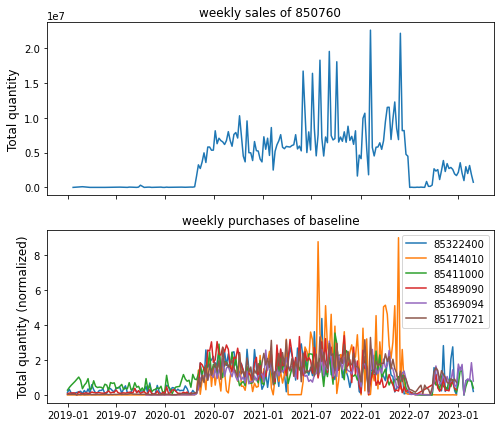

85322400 134788 r=0.780 (n=47, p=0.000)
85414010 48653 r=0.773 (n=43, p=0.000)
85411000 35231 r=0.738 (n=47, p=0.000)
85489090 34776 r=0.733 (n=44, p=0.000)
85369094 47261 r=0.836 (n=41, p=0.000)
85177021 710447 r=0.900 (n=46, p=0.000)


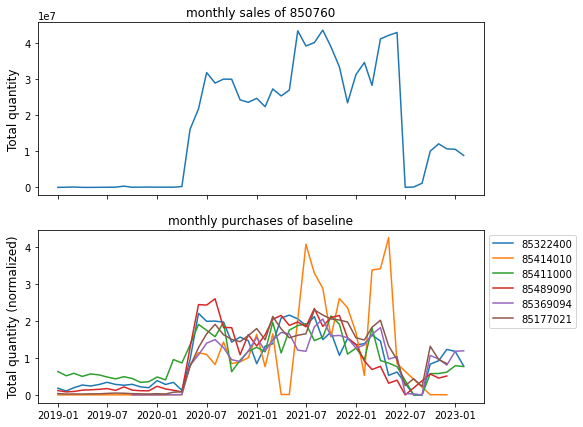

In [323]:
SUPPLY_PROD = 'battery'
BUY_PROD = None
companies = ['%samsung%', 'sehc', 'sevt']
tx_type = 'buyer'
hs_codes = None

baseline(SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, companies=companies, tx_type=tx_type, hs_codes=hs_codes)

### Baseline Samsung - Supply Top 10, Buy BMS

In [324]:
warnings.filterwarnings('ignore')
rs = RedshiftClass('zhiyin','Zhiyin123')

Successful connection！
 


select hs_code, sum(quantity) from logistic_data where (supplier_t like '%samsung%' or supplier_t like 'sehc' or supplier_t like 'sevt') group by hs_code;
Getting supply df...
85322400 -> 677149 99222
85414010 -> 181864 43924
85411000 -> 244299 30672
85369094 -> 222316 17649
85412900 -> 167958 19127
85489090 -> 89165 13864
85423300 -> 96205 9834


id        date                          supplier_t  \
55786   643119101524652038  2019-01-02                samsung asia pte ltd   
638638  643119098374729732  2019-01-02  samsung electro-mechanics co., ltd   
638639  643119098366341129  2019-01-02  samsung electro-mechanics co., ltd   
84978   643119104200617996  2019-01-02                samsung asia pte ltd   
55785   643119101541429264  2019-01-02                samsung asia pte ltd   

                             supplier_id  \
55786   eabd108b691d3b5893b892973839466d   
638638  d263dd6acf2b3511a14e3ee3d7fcd6ae   
638639  d263dd6acf2b3511a14e3ee3d7fcd6ae   
84978   eabd108b691d3b5893b892973839466d   
55785   eabd108b691d3b5893b892973839466d   

                                          buyer_t  \
55786   cong ty tnhh samsung electronics việt nam   
638638  cong ty tnhh samsung electronics việt nam   
638639  cong ty tnhh samsung electronics việt nam   
84978   cong ty tnhh samsung electronics việt nam   
55785   cong ty tnhh samsung electronics việt nam   

                                buyer_id    quantity quantity_unit   price  \
55786   74b972186d553fc89d835e821645b9f3      7000.0           PCE  0.3117   
638638  74b972186d553fc89d835e821645b9f3   3072000.0           PCE  0.0128   
638639  74b972186d553fc89d835e821645b9f3  35752000.0           PCE  0.0052   
84978   74b972186d553fc89d835e821645b9f3    210000.0           PCE  0.0715   
55785   74b972186d553fc89d835e821645b9f3      3000.0           PCE  0.0187   

               amount  ...  sub_bill_no orig_port dest_port   teu  \
55786     2181.917969  ...                 PUDONG    HA NOI  None   
638638   39246.750000  ...                BEIJING    HA NOI  None   
638639  186611.750000  ...                BEIJING    HA NOI  None   
84978    15010.776367  ...                 PUDONG    HA NOI  None   
55785       56.184200  ...                 PUDONG    HA NOI  None   

               data_source trans_type trans_type_code vessel_name  \
55786   IMP_VIETNAM_CD_CVB        AIR             AIR               
638638  IMP_VIETNAM_CD_CVB        AIR             AIR               
638639  IMP_VIETNAM_CD_CVB        AIR             AIR               
84978   IMP_VIETNAM_CD_CVB        AIR             AIR               
55785   IMP_VIETNAM_CD_CVB        AIR             AIR               

                                            supplier_addr  \
55786   30 PASIR PANJANG ROAD #17-31/32 MAPLETREE BUSI...   
638638  416, MAETAN-3DONG, YEONGTONG-GU, SUWON-SI, GYE...   
638639  416, MAETAN-3DONG, YEONGTONG-GU, SUWON-SI, GYE...   
84978   30 PASIR PANJANG ROAD #17-31/32 MAPLETREE BUSI...   
55785   30 PASIR PANJANG ROAD #17-31/32 MAPLETREE BUSI...   

                                               buyer_addr  
55786   KCN Yên Phong I, Xã Yên Trung, Huyện Yên Phong...  
638638  KCN Yên Phong I, Xã Yên Trung, Huyện Yên Phong...  
638639  KCN Yên Phong I, Xã Yên Trung, Huyện Yên Phong...  
84978   KCN Yên Phong I, Xã Yên Trung, Huyện Yên Phong...  
55785   KCN Yên Phong I, Xã Yên Trung, Huyện Yên Phong...  

[5 rows x 26 columns]

Getting buy df...
850450 -> 863960 96990
850730 -> None
850780 -> 515 83
850790 -> 3606 2232
853222 -> 20428 3561
853223 -> 3590 910
853321 -> 1321620 141602
853340 -> 49883 9139
853630 -> 10349 1326
853641 -> 2919 656
853890 -> 7345 1992
854190 -> 2 1
854239 -> 1021814 136150
854290 -> 152 94
854411 -> 962 625
854442 -> 307465 79673
854449 -> 154683 44647


id        date                        supplier_t  \
27618   643119101541429259  2019-01-02              samsung asia pte ltd   
611143  643119104531968016  2019-01-02  maxscend technologies hk limited   
377879  639821542924300333  2019-01-02                      wacom co ltd   
582657  643119088807522308  2019-01-02              samsung asia pte ltd   
611144  643119104531968014  2019-01-02  maxscend technologies hk limited   

                             supplier_id  \
27618   eabd108b691d3b5893b892973839466d   
611143  2d571b7ec0ac37e7b7f25b42ba362d85   
377879  b1db939fbc543194a09d93a255cf7f64   
582657  eabd108b691d3b5893b892973839466d   
611144  2d571b7ec0ac37e7b7f25b42ba362d85   

                                          buyer_t  \
27618   cong ty tnhh samsung electronics việt nam   
611143  cong ty tnhh samsung electronics việt nam   
377879          pt. samsung electronics indonesia   
582657  cong ty tnhh samsung electronics việt nam   
611144  cong ty tnhh samsung electronics việt nam   

                                buyer_id  quantity quantity_unit   price  \
27618   74b972186d553fc89d835e821645b9f3   35000.0           PCE  0.1398   
611143  74b972186d553fc89d835e821645b9f3  402000.0           PCE  0.0248   
377879  56a18d36a1c13b0a87b8051026e2607b    3000.0           PCE     NaN   
582657  74b972186d553fc89d835e821645b9f3   75000.0           PCE  0.1294   
611144  74b972186d553fc89d835e821645b9f3  186000.0           PCE  0.0303   

             amount  ... sub_bill_no         orig_port  \
27618   4891.832031  ...                        PUDONG   
611143  9980.793945  ...                        PUDONG   
377879  5287.994629  ...              NARITA APT TOKYO   
582657  9703.146484  ...                        PUDONG   
611144  5633.934570  ...                        PUDONG   

                         dest_port   teu           data_source trans_type  \
27618                       HA NOI  None    IMP_VIETNAM_CD_CVB        AIR   
611143                      HA NOI  None    IMP_VIETNAM_CD_CVB        AIR   
377879  CENGKARENG SUKARNO HATTA U  None  IMP_INDONESIA_CD_DEF        AIR   
582657                      HA NOI  None    IMP_VIETNAM_CD_CVB        AIR   
611144                      HA NOI  None    IMP_VIETNAM_CD_CVB        AIR   

       trans_type_code vessel_name  \
27618              AIR               
611143             AIR               
377879             AIR               
582657             AIR               
611144             AIR               

                                            supplier_addr  \
27618   30 PASIR PANJANG ROAD #17-31/32 MAPLETREE BUSI...   
611143  FLAT / RM 1611B 16/F HO KING COMMER CIAL CENTR...   
377879     SHINJUKU GRAND TOWER 31F 8 17 1 NISHI SHINJUKU   
582657  30 PASIR PANJANG ROAD #17-31/32 MAPLETREE BUSI...   
611144  FLAT / RM 1611B 16/F HO KING COMMER CIAL CENTR...   

                                               buyer_addr  
27618   KCN Yên Phong I, Xã Yên Trung, Huyện Yên Phong...  
611143  KCN Yên Phong I, Xã Yên Trung, Huyện Yên Phong...  
377879  JL.JABABEKA RAYA BLOK F NO.29-33 KWS INDUSTRI ...  
582657  KCN Yên Phong I, Xã Yên Trung, Huyện Yên Phong...  
611144  KCN Yên Phong I, Xã Yên Trung, Huyện Yên Phong...  

[5 rows x 26 columns]

CSV name is samsung...
Mega Analysis of Sale - Purchase Pipeline on Daily, Weekly, and Monthly Scale

Assume Transaction Data Has Been Queried and Preprocessed...
Constructing Transaction Time Dataframe...Loading from csv...
Supply name is baseline; buy name is bms
234292 519681


date   datetime    month month_datetime       week week_datetime
0  2019-01-02 2019-01-02  2019-01     2019-01-01  2019-01-1    2018-12-31
1  2019-01-02 2019-01-02  2019-01     2019-01-01  2019-01-1    2018-12-31
2  2019-01-02 2019-01-02  2019-01     2019-01-01  2019-01-1    2018-12-31
3  2019-01-02 2019-01-02  2019-01     2019-01-01  2019-01-1    2018-12-31
4  2019-01-02 2019-01-02  2019-01     2019-01-01  2019-01-1    2018-12-31

Plotting sale, purchase over time...


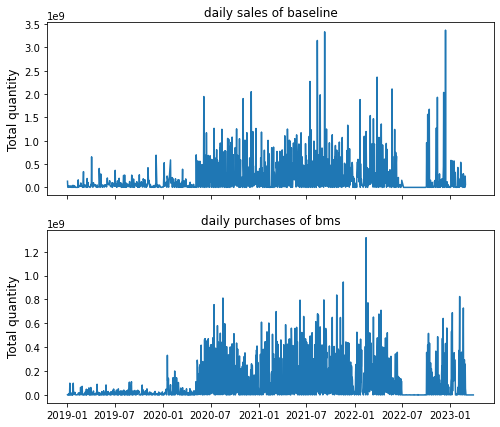

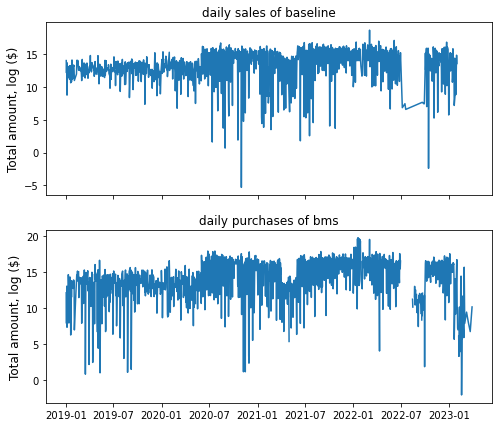

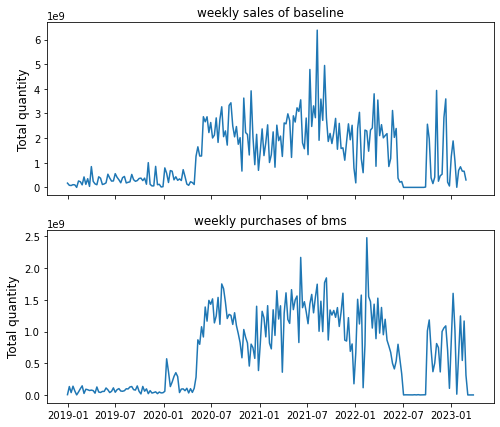

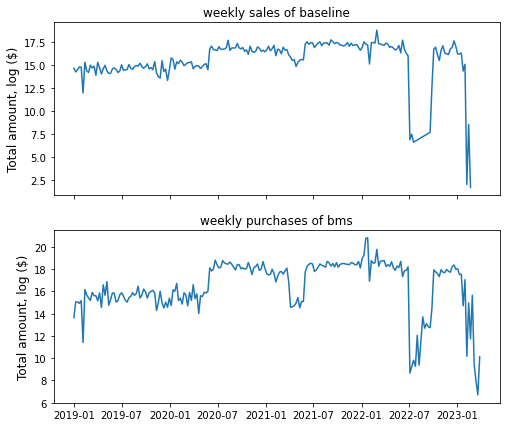

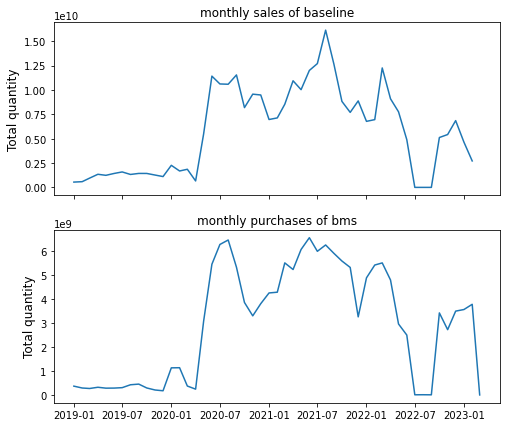

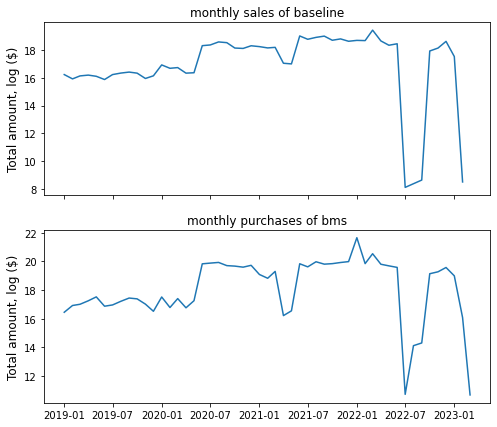

Compare sale, purchase quantity per hscode...
850450 96990 r=0.343 (n=991, p=0.000)
850730 0
850780 83
850790 2232 r=-0.051 (n=251, p=0.425)
853222 3561 r=0.140 (n=544, p=0.001)
853223 910
853321 141602 r=0.286 (n=944, p=0.000)
853340 9139 r=0.203 (n=819, p=0.000)
853630 1326 r=0.024 (n=544, p=0.580)
853641 656
853890 1992 r=-0.013 (n=512, p=0.773)
854190 1
854239 136150 r=0.360 (n=1089, p=0.000)
854290 94
854411 625
854442 79673 r=0.193 (n=1024, p=0.000)
854449 44647 r=0.079 (n=720, p=0.035)


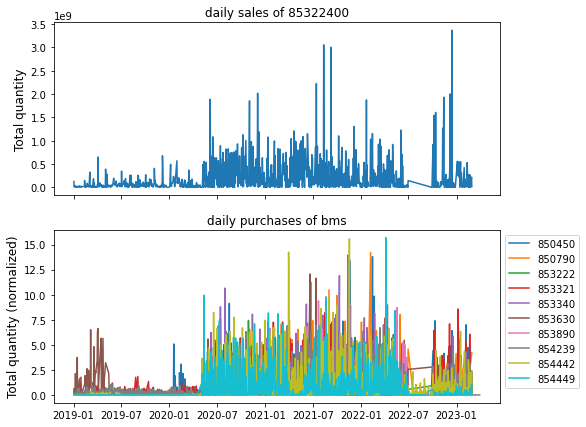

850450 96990 r=0.138 (n=853, p=0.000)
850730 0
850780 83
850790 2232 r=-0.042 (n=245, p=0.509)
853222 3561 r=0.042 (n=528, p=0.331)
853223 910
853321 141602 r=0.117 (n=820, p=0.001)
853340 9139 r=0.081 (n=742, p=0.027)
853630 1326 r=0.036 (n=489, p=0.427)
853641 656
853890 1992 r=0.062 (n=509, p=0.162)
854190 1
854239 136150 r=0.195 (n=924, p=0.000)
854290 94
854411 625
854442 79673 r=0.166 (n=884, p=0.000)
854449 44647 r=0.065 (n=704, p=0.086)


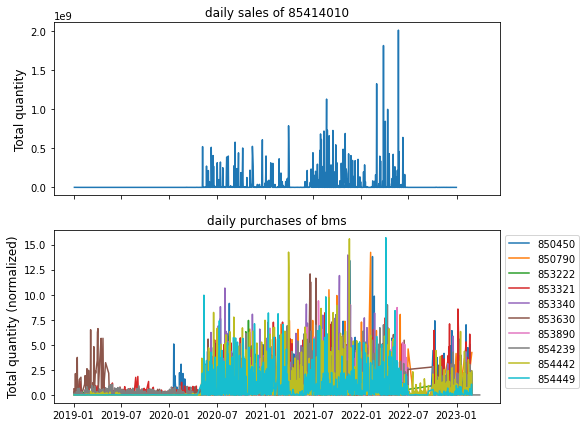

850450 96990 r=0.315 (n=992, p=0.000)
850730 0
850780 83
850790 2232 r=0.084 (n=252, p=0.186)
853222 3561 r=0.097 (n=545, p=0.023)
853223 910
853321 141602 r=0.306 (n=936, p=0.000)
853340 9139 r=0.188 (n=829, p=0.000)
853630 1326 r=0.138 (n=548, p=0.001)
853641 656
853890 1992 r=0.076 (n=509, p=0.088)
854190 1
854239 136150 r=0.444 (n=1086, p=0.000)
854290 94
854411 625
854442 79673 r=0.211 (n=1014, p=0.000)
854449 44647 r=0.106 (n=717, p=0.005)


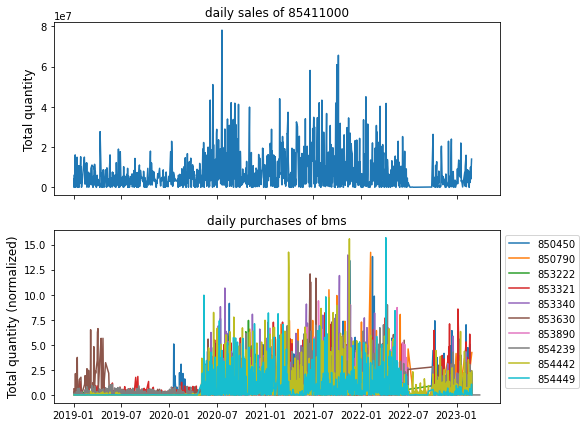

850450 96990 r=0.136 (n=836, p=0.000)
850730 0
850780 83
850790 2232 r=-0.039 (n=251, p=0.535)
853222 3561 r=-0.021 (n=528, p=0.624)
853223 910
853321 141602 r=-0.001 (n=815, p=0.988)
853340 9139 r=-0.001 (n=727, p=0.985)
853630 1326 r=-0.029 (n=482, p=0.525)
853641 656
853890 1992 r=0.070 (n=511, p=0.112)
854190 1
854239 136150 r=0.224 (n=900, p=0.000)
854290 94
854411 625
854442 79673 r=0.131 (n=881, p=0.000)
854449 44647 r=0.021 (n=702, p=0.584)


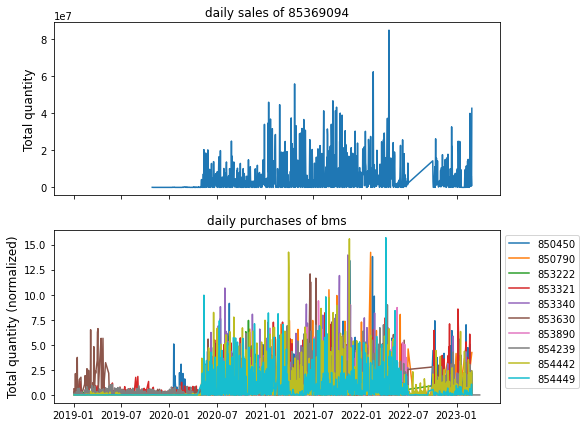

850450 96990 r=0.216 (n=954, p=0.000)
850730 0
850780 83
850790 2232 r=0.033 (n=247, p=0.604)
853222 3561 r=0.222 (n=545, p=0.000)
853223 910
853321 141602 r=0.280 (n=898, p=0.000)
853340 9139 r=0.179 (n=810, p=0.000)
853630 1326 r=0.137 (n=544, p=0.001)
853641 656
853890 1992 r=0.014 (n=508, p=0.753)
854190 1
854239 136150 r=0.364 (n=1032, p=0.000)
854290 94
854411 625
854442 79673 r=0.194 (n=970, p=0.000)
854449 44647 r=0.148 (n=701, p=0.000)


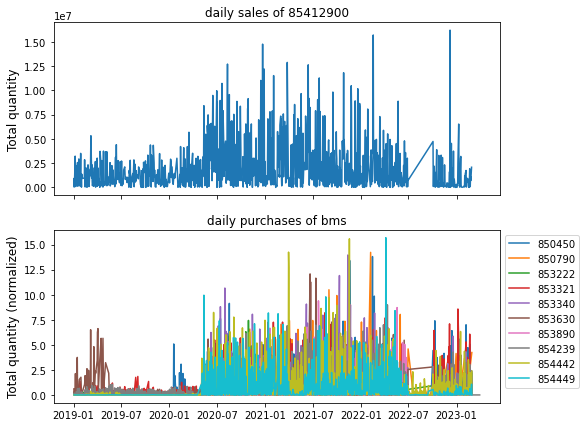

850450 96990 r=0.236 (n=907, p=0.000)
850730 0
850780 83
850790 2232 r=-0.040 (n=235, p=0.544)
853222 3561 r=0.078 (n=522, p=0.076)
853223 910
853321 141602 r=0.280 (n=854, p=0.000)
853340 9139 r=0.162 (n=761, p=0.000)
853630 1326 r=0.066 (n=514, p=0.136)
853641 656
853890 1992 r=-0.019 (n=491, p=0.678)
854190 1
854239 136150 r=0.307 (n=977, p=0.000)
854290 94
854411 625
854442 79673 r=0.180 (n=921, p=0.000)
854449 44647 r=0.080 (n=667, p=0.038)


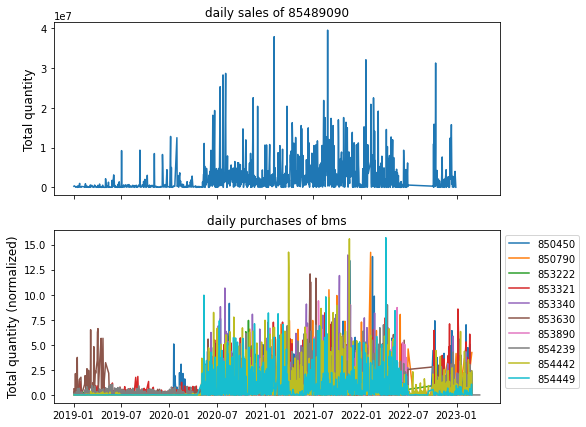

850450 96990 r=0.307 (n=833, p=0.000)
850730 0
850780 83
850790 2232 r=0.060 (n=237, p=0.361)
853222 3561 r=-0.014 (n=516, p=0.745)
853223 910
853321 141602 r=0.355 (n=805, p=0.000)
853340 9139 r=0.179 (n=727, p=0.000)
853630 1326 r=0.148 (n=476, p=0.001)
853641 656
853890 1992 r=0.022 (n=493, p=0.622)
854190 1
854239 136150 r=0.381 (n=885, p=0.000)
854290 94
854411 625
854442 79673 r=0.142 (n=845, p=0.000)
854449 44647 r=0.008 (n=678, p=0.827)


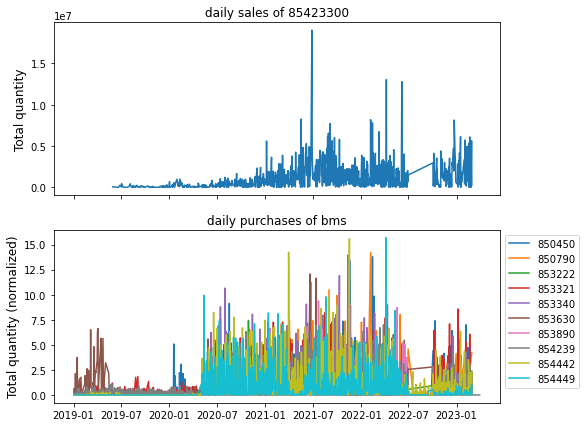

850450 96990 r=0.685 (n=205, p=0.000)
850730 0
850780 83
850790 2232 r=-0.034 (n=119, p=0.717)
853222 3561 r=0.330 (n=149, p=0.000)
853223 910
853321 141602 r=0.667 (n=203, p=0.000)
853340 9139 r=0.530 (n=197, p=0.000)
853630 1326 r=0.201 (n=178, p=0.007)
853641 656
853890 1992 r=0.167 (n=140, p=0.049)
854190 1
854239 136150 r=0.654 (n=205, p=0.000)
854290 94
854411 625
854442 79673 r=0.531 (n=205, p=0.000)
854449 44647 r=0.259 (n=159, p=0.001)


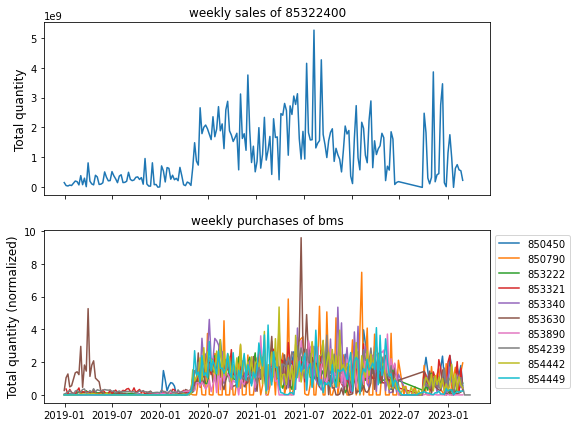

850450 96990 r=0.403 (n=193, p=0.000)
850730 0
850780 83
850790 2232 r=0.161 (n=113, p=0.089)
853222 3561 r=0.186 (n=142, p=0.027)
853223 910
853321 141602 r=0.375 (n=191, p=0.000)
853340 9139 r=0.264 (n=186, p=0.000)
853630 1326 r=0.149 (n=170, p=0.053)
853641 656
853890 1992 r=0.384 (n=132, p=0.000)
854190 1
854239 136150 r=0.494 (n=193, p=0.000)
854290 94
854411 625
854442 79673 r=0.460 (n=193, p=0.000)
854449 44647 r=0.304 (n=149, p=0.000)


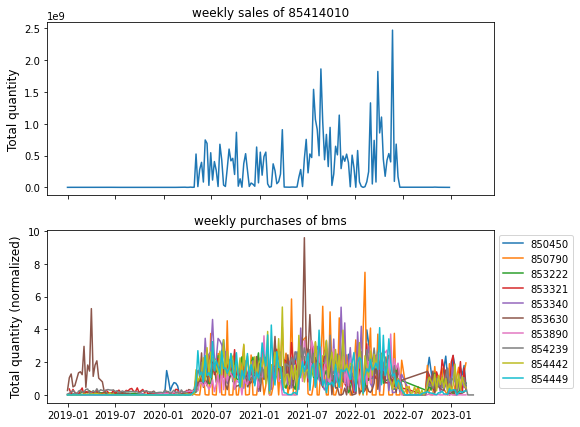

850450 96990 r=0.674 (n=209, p=0.000)
850730 0
850780 83
850790 2232 r=0.112 (n=121, p=0.222)
853222 3561 r=0.426 (n=149, p=0.000)
853223 910
853321 141602 r=0.621 (n=203, p=0.000)
853340 9139 r=0.537 (n=197, p=0.000)
853630 1326 r=0.281 (n=178, p=0.000)
853641 656
853890 1992 r=0.352 (n=142, p=0.000)
854190 1
854239 136150 r=0.722 (n=209, p=0.000)
854290 94
854411 625
854442 79673 r=0.601 (n=209, p=0.000)
854449 44647 r=0.398 (n=161, p=0.000)


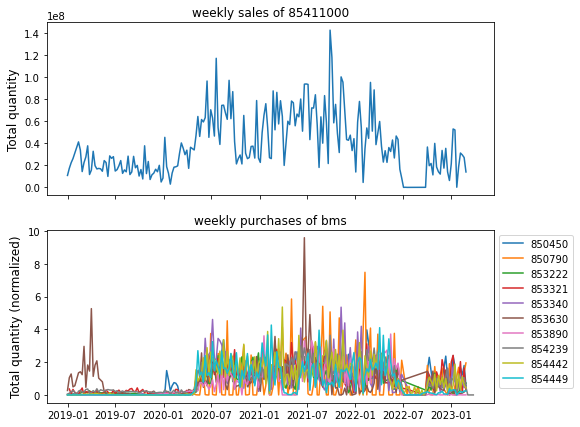

850450 96990 r=0.590 (n=160, p=0.000)
850730 0
850780 83
850790 2232 r=0.021 (n=115, p=0.824)
853222 3561 r=0.090 (n=138, p=0.295)
853223 910
853321 141602 r=0.545 (n=160, p=0.000)
853340 9139 r=0.390 (n=159, p=0.000)
853630 1326 r=0.127 (n=147, p=0.124)
853641 656
853890 1992 r=0.292 (n=134, p=0.001)
854190 1
854239 136150 r=0.630 (n=160, p=0.000)
854290 94
854411 625
854442 79673 r=0.420 (n=160, p=0.000)
854449 44647 r=0.130 (n=141, p=0.124)


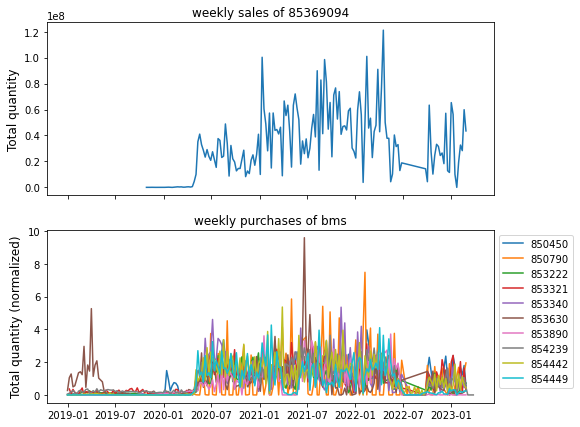

850450 96990 r=0.544 (n=204, p=0.000)
850730 0
850780 83
850790 2232 r=-0.050 (n=118, p=0.587)
853222 3561 r=0.457 (n=149, p=0.000)
853223 910
853321 141602 r=0.573 (n=202, p=0.000)
853340 9139 r=0.476 (n=196, p=0.000)
853630 1326 r=0.304 (n=178, p=0.000)
853641 656
853890 1992 r=0.149 (n=139, p=0.080)
854190 1
854239 136150 r=0.646 (n=204, p=0.000)
854290 94
854411 625
854442 79673 r=0.500 (n=204, p=0.000)
854449 44647 r=0.413 (n=159, p=0.000)


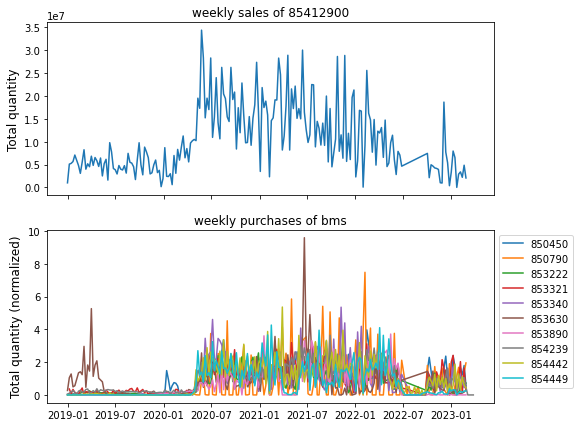

850450 96990 r=0.685 (n=194, p=0.000)
850730 0
850780 83
850790 2232 r=-0.014 (n=113, p=0.887)
853222 3561 r=0.147 (n=141, p=0.082)
853223 910
853321 141602 r=0.622 (n=192, p=0.000)
853340 9139 r=0.502 (n=187, p=0.000)
853630 1326 r=0.160 (n=171, p=0.037)
853641 656
853890 1992 r=0.244 (n=131, p=0.005)
854190 1
854239 136150 r=0.636 (n=195, p=0.000)
854290 94
854411 625
854442 79673 r=0.554 (n=194, p=0.000)
854449 44647 r=0.320 (n=149, p=0.000)


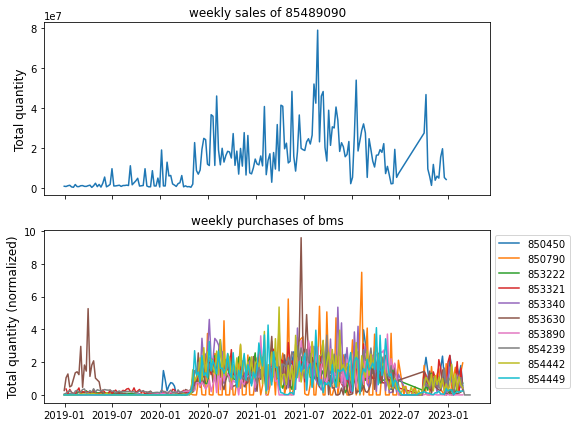

850450 96990 r=0.523 (n=182, p=0.000)
850730 0
850780 83
850790 2232 r=0.169 (n=114, p=0.073)
853222 3561 r=0.063 (n=141, p=0.455)
853223 910
853321 141602 r=0.496 (n=181, p=0.000)
853340 9139 r=0.312 (n=177, p=0.000)
853630 1326 r=0.313 (n=157, p=0.000)
853641 656
853890 1992 r=0.270 (n=133, p=0.002)
854190 1
854239 136150 r=0.614 (n=182, p=0.000)
854290 94
854411 625
854442 79673 r=0.347 (n=182, p=0.000)
854449 44647 r=0.036 (n=150, p=0.661)


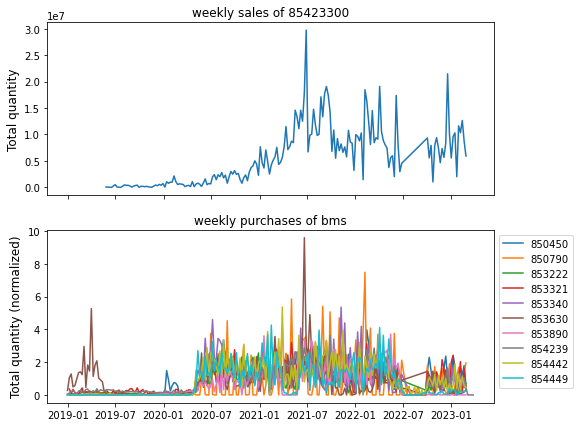

850450 96990 r=0.886 (n=48, p=0.000)
850730 0
850780 83
850790 2232 r=0.612 (n=34, p=0.000)
853222 3561 r=0.749 (n=40, p=0.000)
853223 910
853321 141602 r=0.898 (n=48, p=0.000)
853340 9139 r=0.782 (n=48, p=0.000)
853630 1326 r=0.546 (n=47, p=0.000)
853641 656
853890 1992 r=0.478 (n=38, p=0.002)
854190 1
854239 136150 r=0.886 (n=48, p=0.000)
854290 94
854411 625
854442 79673 r=0.845 (n=48, p=0.000)
854449 44647 r=0.633 (n=45, p=0.000)


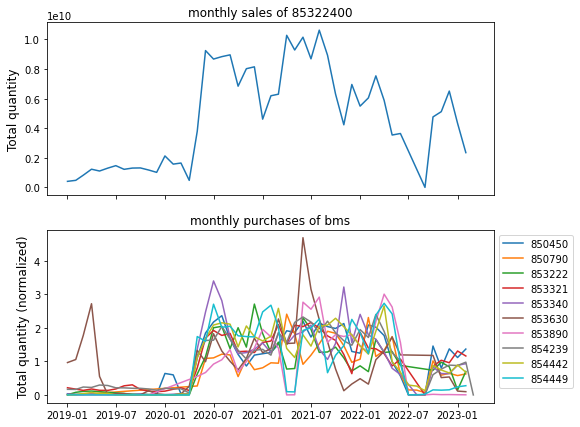

850450 96990 r=0.616 (n=45, p=0.000)
850730 0
850780 83
850790 2232 r=0.301 (n=31, p=0.100)
853222 3561 r=0.530 (n=38, p=0.001)
853223 910
853321 141602 r=0.580 (n=45, p=0.000)
853340 9139 r=0.526 (n=45, p=0.000)
853630 1326 r=0.403 (n=45, p=0.006)
853641 656
853890 1992 r=0.812 (n=35, p=0.000)
854190 1
854239 136150 r=0.691 (n=45, p=0.000)
854290 94
854411 625
854442 79673 r=0.683 (n=45, p=0.000)
854449 44647 r=0.716 (n=42, p=0.000)


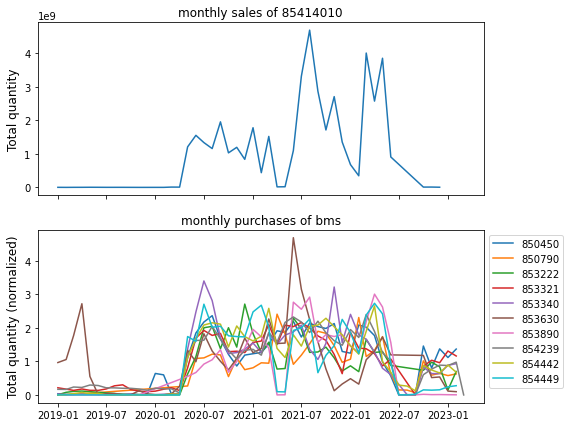

850450 96990 r=0.807 (n=49, p=0.000)
850730 0
850780 83
850790 2232 r=0.514 (n=35, p=0.002)
853222 3561 r=0.628 (n=40, p=0.000)
853223 910
853321 141602 r=0.833 (n=48, p=0.000)
853340 9139 r=0.829 (n=48, p=0.000)
853630 1326 r=0.520 (n=47, p=0.000)
853641 656
853890 1992 r=0.586 (n=39, p=0.000)
854190 1
854239 136150 r=0.864 (n=49, p=0.000)
854290 94
854411 625
854442 79673 r=0.812 (n=49, p=0.000)
854449 44647 r=0.672 (n=46, p=0.000)


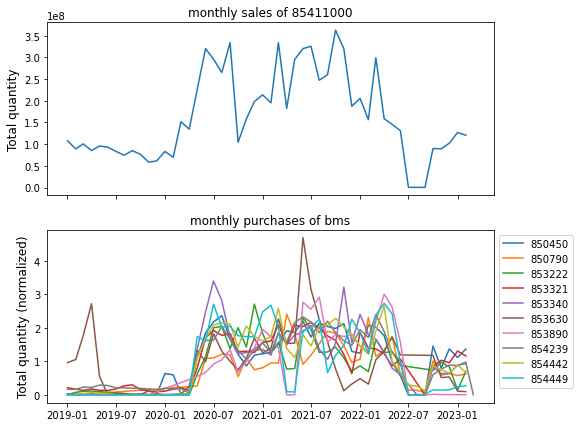

850450 96990 r=0.778 (n=38, p=0.000)
850730 0
850780 83
850790 2232 r=0.526 (n=31, p=0.002)
853222 3561 r=0.338 (n=35, p=0.047)
853223 910
853321 141602 r=0.697 (n=38, p=0.000)
853340 9139 r=0.568 (n=38, p=0.000)
853630 1326 r=0.389 (n=38, p=0.016)
853641 656
853890 1992 r=0.453 (n=32, p=0.009)
854190 1
854239 136150 r=0.821 (n=38, p=0.000)
854290 94
854411 625
854442 79673 r=0.744 (n=38, p=0.000)
854449 44647 r=0.416 (n=36, p=0.012)


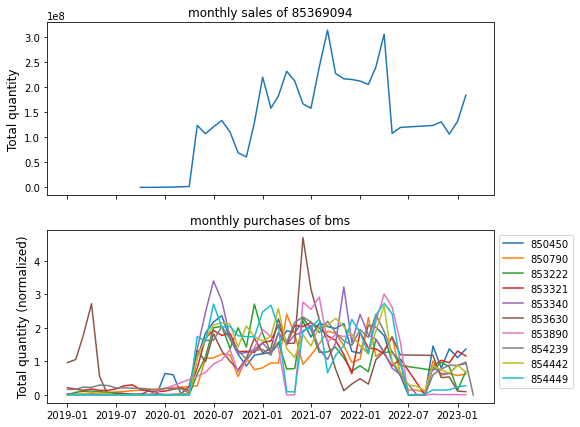

850450 96990 r=0.708 (n=47, p=0.000)
850730 0
850780 83
850790 2232 r=0.294 (n=33, p=0.097)
853222 3561 r=0.685 (n=40, p=0.000)
853223 910
853321 141602 r=0.753 (n=47, p=0.000)
853340 9139 r=0.779 (n=47, p=0.000)
853630 1326 r=0.529 (n=47, p=0.000)
853641 656
853890 1992 r=0.401 (n=37, p=0.014)
854190 1
854239 136150 r=0.767 (n=47, p=0.000)
854290 94
854411 625
854442 79673 r=0.774 (n=47, p=0.000)
854449 44647 r=0.675 (n=44, p=0.000)


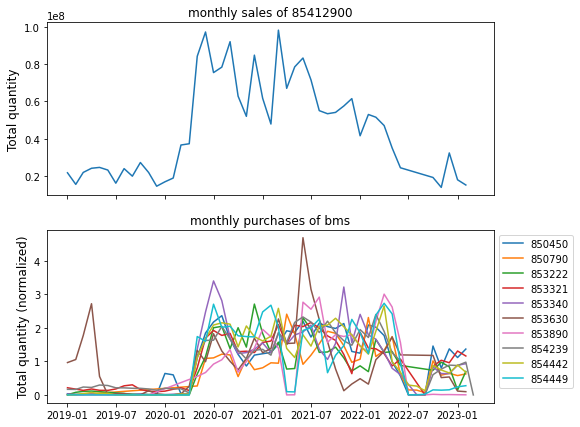

850450 96990 r=0.888 (n=45, p=0.000)
850730 0
850780 83
850790 2232 r=0.700 (n=31, p=0.000)
853222 3561 r=0.554 (n=38, p=0.000)
853223 910
853321 141602 r=0.828 (n=45, p=0.000)
853340 9139 r=0.755 (n=45, p=0.000)
853630 1326 r=0.409 (n=45, p=0.005)
853641 656
853890 1992 r=0.516 (n=35, p=0.001)
854190 1
854239 136150 r=0.822 (n=45, p=0.000)
854290 94
854411 625
854442 79673 r=0.799 (n=45, p=0.000)
854449 44647 r=0.547 (n=42, p=0.000)


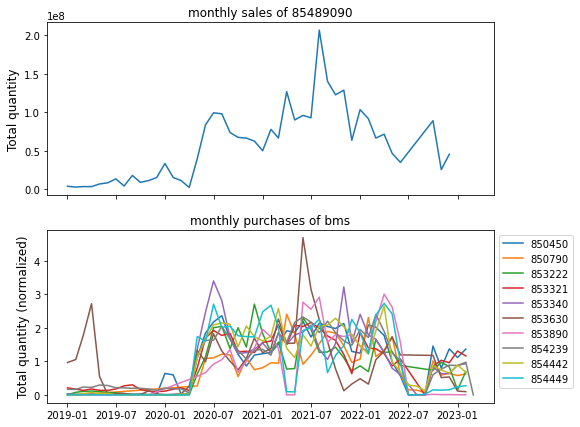

850450 96990 r=0.680 (n=43, p=0.000)
850730 0
850780 83
850790 2232 r=0.323 (n=31, p=0.077)
853222 3561 r=0.268 (n=36, p=0.114)
853223 910
853321 141602 r=0.633 (n=43, p=0.000)
853340 9139 r=0.391 (n=43, p=0.009)
853630 1326 r=0.566 (n=43, p=0.000)
853641 656
853890 1992 r=0.446 (n=34, p=0.008)
854190 1
854239 136150 r=0.712 (n=43, p=0.000)
854290 94
854411 625
854442 79673 r=0.515 (n=43, p=0.000)
854449 44647 r=0.265 (n=41, p=0.094)


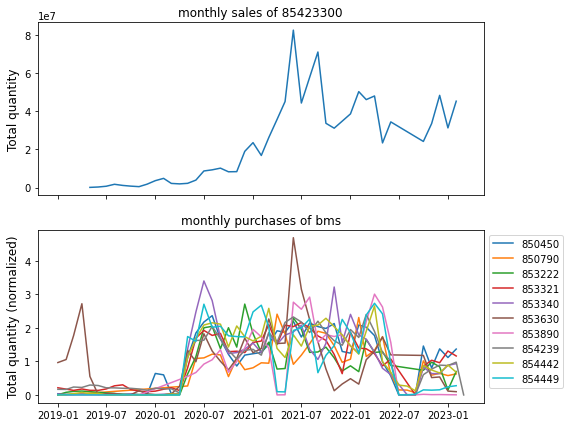

In [325]:
SUPPLY_PROD = None
BUY_PROD = 'bms'
companies = ['%samsung%', 'sehc', 'sevt']
tx_type = 'supplier'
hs_codes = None

baseline(SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, companies=companies, tx_type=tx_type, hs_codes=hs_codes)

### Baseline LG - Supply battery, Buy office supply

In [309]:
warnings.filterwarnings('ignore')
rs = RedshiftClass('zhiyin','Zhiyin123')

Successful connection！
 


select hs_code, sum(quantity) from logistic_data where (buyer_t like '%lg %' or buyer_t like 'lgdvh' or buyer_t like 'lgevh' or buyer_t like 'lgitvh') group by hs_code;
Getting supply df...
850760 -> 2649 1281


id        date                     supplier_t  \
2485  638370708889874440  2019-01-06                    lg chem ltd   
2     638372997469909001  2019-01-14                    lg chem ltd   
1119  640702053846691849  2019-04-22  lg electronics india pvt. ltd   
2033  641848539351429127  2019-09-30                    lg chem ltd   
61    638296307670528006  2020-04-23                   lg chem, ltd   

                           supplier_id  \
2485  990e23f5c0ad3e63aabfa5e349b1404e   
2     990e23f5c0ad3e63aabfa5e349b1404e   
1119  90e7344010253981abd9e295080fca5f   
2033  990e23f5c0ad3e63aabfa5e349b1404e   
61    990e23f5c0ad3e63aabfa5e349b1404e   

                                          buyer_t  \
2485                                  lg chem ltd   
2                                     lg chem ltd   
1119                           lg electronics inc   
2033  vincular testing labs india private limited   
61                                   lg chem, ltd   

                              buyer_id  quantity quantity_unit    price  \
2485  990e23f5c0ad3e63aabfa5e349b1404e      40.0           PCS      NaN   
2     990e23f5c0ad3e63aabfa5e349b1404e      40.0           BAG      NaN   
1119  9fa2a1d616683b07848b0839d017a7a2    1082.0           SET   7.6800   
2033  affe12ed26573982856a478a1860178b      47.0           NOS  13.8568   
61    990e23f5c0ad3e63aabfa5e349b1404e      35.0           CTN      NaN   

           amount  ...       sub_bill_no               orig_port  \
2485          NaN  ...  HDMUBUCA9292376A                   BUSAN   
2             NaN  ...  HDMUBUCA9292937A                   BUSAN   
1119  8309.759766  ...                    NHAVA SHEVA SEA INNSA1   
2033   651.000000  ...                                             
61            NaN  ...     MAEU596417635                YANGSHAN   

                       dest_port   teu         data_source         trans_type  \
2485      LOS ANGELES CALIFORNIA   2.0  IMP_AMERICA_BL_SEA  SEA NON-CONTAINER   
2         LOS ANGELES CALIFORNIA   2.0  IMP_AMERICA_BL_SEA  SEA NON-CONTAINER   
1119                       PUSAN   NaN    EXP_INDIA_CD_DEF                SEA   
2033  DELHI AIR CARGO ACC INDEL4   NaN    IMP_INDIA_CD_DEF                AIR   
61            OAKLAND CALIFORNIA  10.0  IMP_AMERICA_BL_SEA  SEA NON-CONTAINER   

        trans_type_code      vessel_name  \
2485  SEA NON-CONTAINER   HYUNDAI GLOBAL   
2     SEA NON-CONTAINER  HYUNDAI COURAGE   
1119                SEA                    
2033                AIR                    
61    SEA NON-CONTAINER     GERDA MAERSK   

                                          supplier_addr  \
2485  lg twin towers,20 yoido-dong youngdungpo-gu, s...   
2     lg twin towers,20 yoido-dong youngdungpo-gu, s...   
1119  PLOT NO.51, UDYOG VIHAR, SURAJPURKASNA ROAD, G...   
2033                                                      
61    yeouido-dong 20 yeongdungpo-gu seul korea polu...   

                                             buyer_addr  
2485  lg twin tower, 20 yoido-dong youngd ungpo-gu, ...  
2     lg twin towers,20 yoido-dong youngdungpo-gu, s...  
1119                                                     
2033  18-19, MINISWAMAPPA BUILDING, OPP  MASALA HOTE...  
61    yeouido-dong 20 yeongdungpo-gu seul korea polu...  

[5 rows x 26 columns]

Getting buy df...
48211090 -> 792 189
48059190000 -> None
48059190100 -> None
48059110000 -> None


id        date supplier_t  \
396  639184579187781642  2020-05-07      lgevh   
34   639184579183587339  2020-05-12      lgevh   
450  639184579187781639  2020-05-12      lgevh   
494  639186239750483976  2020-05-15      lgevh   
0    639187604082077703  2020-05-19      lgevh   

                          supplier_id             buyer_t  \
396  df8715c861e23e66aa03c9c90e06a020  lg electronics inc   
34   df8715c861e23e66aa03c9c90e06a020  lg electronics inc   
450  df8715c861e23e66aa03c9c90e06a020  lg electronics inc   
494  df8715c861e23e66aa03c9c90e06a020  lg electronics inc   
0    df8715c861e23e66aa03c9c90e06a020  lg electronics inc   

                             buyer_id  quantity quantity_unit  price  amount  \
396  9fa2a1d616683b07848b0839d017a7a2    4000.0           PCE  0.050   200.0   
34   9fa2a1d616683b07848b0839d017a7a2   15000.0           PCE  0.100  1500.0   
450  9fa2a1d616683b07848b0839d017a7a2    3000.0           PCE  0.005    15.0   
494  9fa2a1d616683b07848b0839d017a7a2    3000.0           PCE  0.020    60.0   
0    9fa2a1d616683b07848b0839d017a7a2    1000.0           PCE  0.003     3.0   

     ...  sub_bill_no orig_port             dest_port   teu  \
396  ...                 HA NOI  INCHEON INTL APT SEO  None   
34   ...                 HA NOI  INCHEON INTL APT SEO  None   
450  ...                 HA NOI  INCHEON INTL APT SEO  None   
494  ...                 HA NOI  INCHEON INTL APT SEO  None   
0    ...                 HA NOI  INCHEON INTL APT SEO  None   

            data_source trans_type trans_type_code vessel_name  \
396  EXP_VIETNAM_CD_AEN                    UNKNOWN               
34   EXP_VIETNAM_CD_AEN                    UNKNOWN               
450  EXP_VIETNAM_CD_AEN                    UNKNOWN               
494  EXP_VIETNAM_CD_AEN                    UNKNOWN               
0    EXP_VIETNAM_CD_AEN                    UNKNOWN               

                                         supplier_addr          buyer_addr  
396  Lot CN2, Trang Due Industrial Park, Le Loi Com...  ,REPUBLIC OF KOREA  
34   Lot CN2, Trang Due Industrial Park, Le Loi Com...  ,REPUBLIC OF KOREA  
450  Lot CN2, Trang Due Industrial Park, Le Loi Com...  ,REPUBLIC OF KOREA  
494  Lot CN2, Trang Due Industrial Park, Le Loi Com...  ,REPUBLIC OF KOREA  
0    Lot CN2, Trang Due Industrial Park, Le Loi Com...  ,REPUBLIC OF KOREA  

[5 rows x 26 columns]

CSV name is lg...
Mega Analysis of Sale - Purchase Pipeline on Daily, Weekly, and Monthly Scale

Assume Transaction Data Has Been Queried and Preprocessed...
Constructing Transaction Time Dataframe...Loading from csv...
Supply name is battery; buy name is baseline
1281 189


date   datetime    month month_datetime       week week_datetime
0  2019-01-06 2019-01-06  2019-01     2019-01-01  2019-01-1    2018-12-31
1  2019-01-14 2019-01-14  2019-01     2019-01-01  2019-03-1    2019-01-14
2  2019-04-22 2019-04-22  2019-04     2019-04-01  2019-17-1    2019-04-22
3  2019-09-30 2019-09-30  2019-09     2019-09-01  2019-40-1    2019-09-30
4  2020-04-23 2020-04-23  2020-04     2020-04-01  2020-17-1    2020-04-20

Plotting sale, purchase over time...


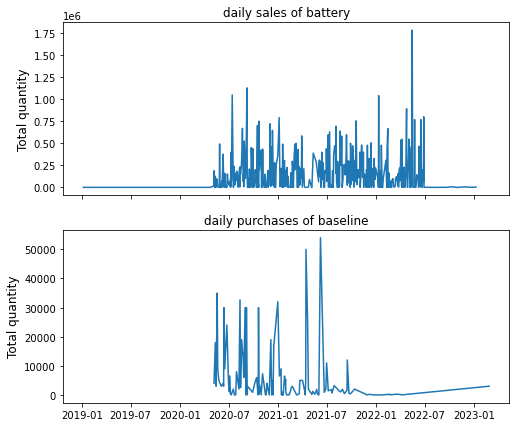

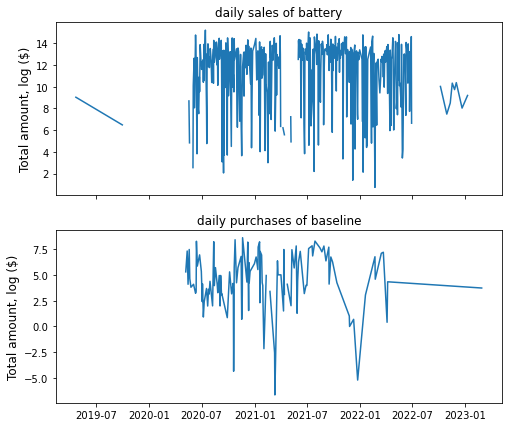

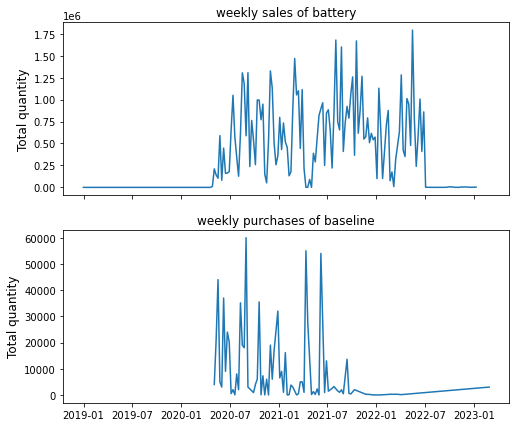

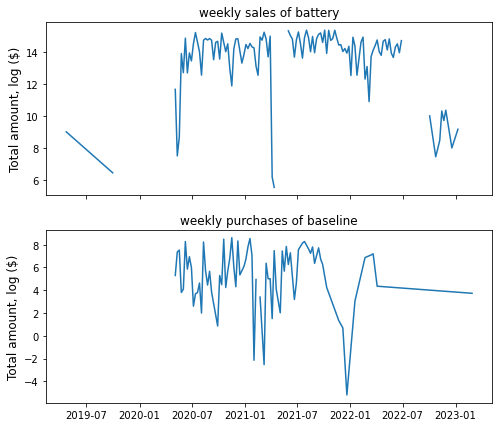

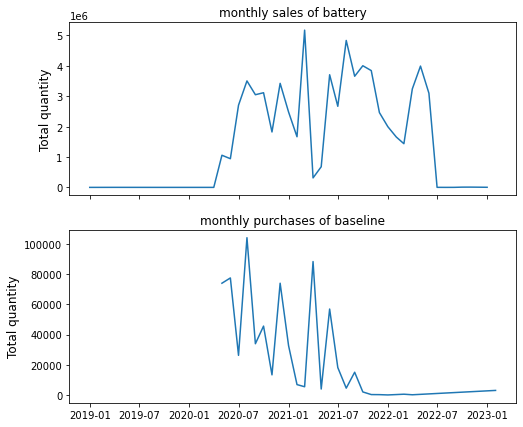

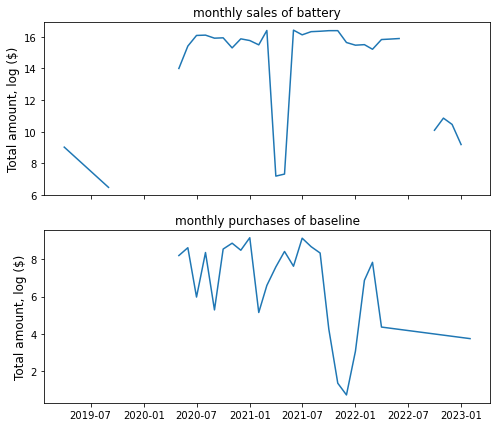

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Compare sale, purchase quantity per hscode...
48211090 189
48059190000 0
48059190100 0
48059110000 0


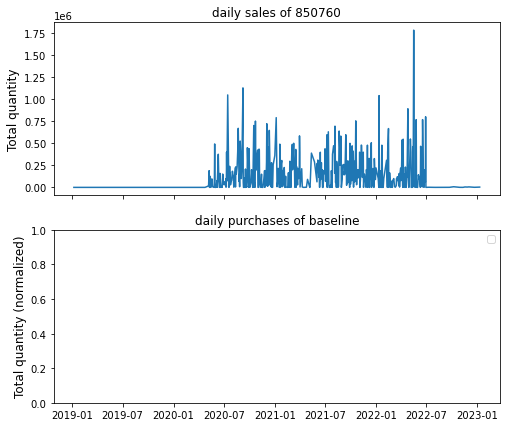

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


48211090 189
48059190000 0
48059190100 0
48059110000 0


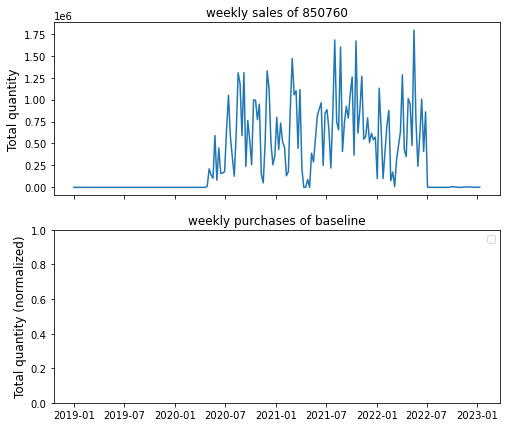

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


48211090 189
48059190000 0
48059190100 0
48059110000 0


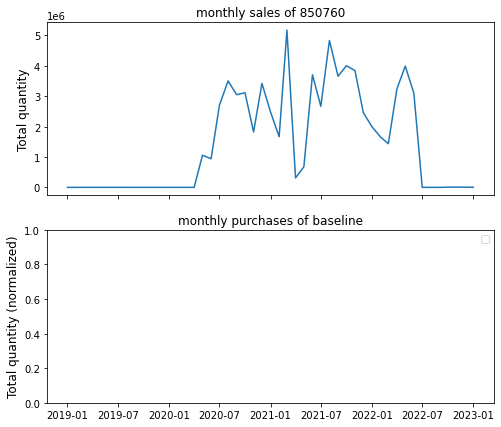

In [310]:
SUPPLY_PROD = 'battery'
BUY_PROD = tuple(BASELINE_HS6)
companies = ['%lg %', 'lgdvh', 'lgevh', 'lgitvh']
tx_type = 'buyer'
hs_codes = ['482110', '480591']


baseline(SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, companies=companies, tx_type=tx_type, hs_codes=hs_codes)

### Baseline LG - Supply office supply, Buy BMS

In [304]:
warnings.filterwarnings('ignore')
rs = RedshiftClass('zhiyin','Zhiyin123')

Successful connection！
 


select hs_code, sum(quantity) from logistic_data where (supplier_t like '%lg %' or supplier_t like 'lgdvh' or supplier_t like 'lgevh' or supplier_t like 'lgitvh') group by hs_code;
Getting supply df...
48211090 -> 473 105
48059190000 -> None
48059190100 -> None
48059110000 -> None


id        date supplier_t  \
2    639184579187781642  2020-05-07      lgevh   
233  639184579187781639  2020-05-12      lgevh   
82   639184579183587339  2020-05-12      lgevh   
295  639186239750483976  2020-05-15      lgevh   
409  639187604077883405  2020-05-19      lgevh   

                          supplier_id             buyer_t  \
2    df8715c861e23e66aa03c9c90e06a020  lg electronics inc   
233  df8715c861e23e66aa03c9c90e06a020  lg electronics inc   
82   df8715c861e23e66aa03c9c90e06a020  lg electronics inc   
295  df8715c861e23e66aa03c9c90e06a020  lg electronics inc   
409  df8715c861e23e66aa03c9c90e06a020  lg electronics inc   

                             buyer_id  quantity quantity_unit  price  amount  \
2    9fa2a1d616683b07848b0839d017a7a2    4000.0           PCE  0.050   200.0   
233  9fa2a1d616683b07848b0839d017a7a2    3000.0           PCE  0.005    15.0   
82   9fa2a1d616683b07848b0839d017a7a2   15000.0           PCE  0.100  1500.0   
295  9fa2a1d616683b07848b0839d017a7a2    3000.0           PCE  0.020    60.0   
409  9fa2a1d616683b07848b0839d017a7a2   25000.0           PCE  0.009   225.0   

     ...  sub_bill_no orig_port             dest_port   teu  \
2    ...                 HA NOI  INCHEON INTL APT SEO  None   
233  ...                 HA NOI  INCHEON INTL APT SEO  None   
82   ...                 HA NOI  INCHEON INTL APT SEO  None   
295  ...                 HA NOI  INCHEON INTL APT SEO  None   
409  ...                 HA NOI  INCHEON INTL APT SEO  None   

            data_source trans_type trans_type_code vessel_name  \
2    EXP_VIETNAM_CD_AEN                    UNKNOWN               
233  EXP_VIETNAM_CD_AEN                    UNKNOWN               
82   EXP_VIETNAM_CD_AEN                    UNKNOWN               
295  EXP_VIETNAM_CD_AEN                    UNKNOWN               
409  EXP_VIETNAM_CD_AEN                    UNKNOWN               

                                         supplier_addr          buyer_addr  
2    Lot CN2, Trang Due Industrial Park, Le Loi Com...  ,REPUBLIC OF KOREA  
233  Lot CN2, Trang Due Industrial Park, Le Loi Com...  ,REPUBLIC OF KOREA  
82   Lot CN2, Trang Due Industrial Park, Le Loi Com...  ,REPUBLIC OF KOREA  
295  Lot CN2, Trang Due Industrial Park, Le Loi Com...  ,REPUBLIC OF KOREA  
409  Lot CN2, Trang Due Industrial Park, Le Loi Com...  ,REPUBLIC OF KOREA  

[5 rows x 26 columns]

Getting buy df...
850450 -> 56349 43373
850730 -> 3 1
850780 -> 14 14
850790 -> 104 70
853222 -> 3975 3156
853223 -> 49 19
853321 -> 96232 74744
853340 -> 4230 3228
853630 -> 2 2
853641 -> 128 96
853890 -> 5237 1095
854190 -> None
854239 -> 5853 4434
854290 -> 4 2
854411 -> 46 15
854442 -> 19920 8415
854449 -> 157 62


id        date                       supplier_t  \
84     641652877875818511  2019-01-14           ооо лг электроникс рус   
3253   639034712951959589  2019-01-22  allegro microsystems phils. inc   
34     639034713006485524  2019-01-24  allegro microsystems phils. inc   
41     638389423924654083  2019-03-27               lg electronics inc   
11018  640697380838387717  2019-03-29    lg electronics india pvt. ltd   

                            supplier_id             buyer_t  \
84     a4ed74fdacee3db2a4a0271b3e966cf5  lg electronics inc   
3253   4a40e1dc11cc376c8aff6e77938bf68c  lg electronics inc   
34     4a40e1dc11cc376c8aff6e77938bf68c  lg electronics inc   
41     9fa2a1d616683b07848b0839d017a7a2  lg electronics inc   
11018  90e7344010253981abd9e295080fca5f  lg electronics inc   

                               buyer_id  quantity quantity_unit price  \
84     9fa2a1d616683b07848b0839d017a7a2       0.0                 NaN   
3253   9fa2a1d616683b07848b0839d017a7a2       1.0        CARTON   NaN   
34     9fa2a1d616683b07848b0839d017a7a2       1.0        CARTON   NaN   
41     9fa2a1d616683b07848b0839d017a7a2     155.0           CTN   NaN   
11018  9fa2a1d616683b07848b0839d017a7a2    1200.0           SET  0.67   

             amount  ...  sub_bill_no                   orig_port  \
84     24133.259766  ...                                            
3253     675.750000  ...                NINOY AQUINO INTL AIRPORT   
34       675.750000  ...                NINOY AQUINO INTL AIRPORT   
41              NaN  ...                                    BUSAN   
11018    804.000000  ...               SAHAR AIR CARGO ACC INBOM4   

                   dest_port   teu             data_source         trans_type  \
84                            None       EXP_RUSSIA_CD_DEF                      
3253                          None  EXP_PHILIPPINES_CD_DEF                      
34                            None  EXP_PHILIPPINES_CD_DEF                      
41     LONG BEACH CALIFORNIA  12.0      IMP_AMERICA_BL_SEA  SEA CONTAINERIZED   
11018                  SEOUL  None        EXP_INDIA_CD_DEF                AIR   

         trans_type_code  vessel_name  \
84               UNKNOWN                
3253             UNKNOWN           OZ   
34               UNKNOWN           OZ   
41     SEA CONTAINERIZED  OOCL LONDON   
11018                AIR                

                                           supplier_addr  \
84     143160, МОСКОВСКАЯ область РУЗСКИЙ район, СП Д...   
3253   4756 SAMPAGUITA STREET MARIMAR VILLAGE BRGY SU...   
34     4756 SAMPAGUITA STREET MARIMAR VILLAGE BRGY SU...   
41     lg twin towers 128, yeoui-daero youngdungpo-gu...   
11018  PLOT NO.51, UDYOG VIHAR, SURAJPURKASNA ROAD, G...   

                                              buyer_addr  
84     150-721, ЛГ ТВИН ТАУЭРС 20, СЕУЛ, ЙЕИДО-ДОНГ, ...  
3253                                                      
34                                                        
41     . 1000 sylvan avenue , englewood cliffs, nj, 0...  
11018                                                     

[5 rows x 26 columns]

CSV name is lg...
Mega Analysis of Sale - Purchase Pipeline on Daily, Weekly, and Monthly Scale

Assume Transaction Data Has Been Queried and Preprocessed...
Constructing Transaction Time Dataframe...Loading from csv...
Supply name is baseline; buy name is bms
105 138726


date   datetime    month month_datetime       week week_datetime
0  2020-05-07 2020-05-07  2020-05     2020-05-01  2020-19-1    2020-05-04
1  2020-05-12 2020-05-12  2020-05     2020-05-01  2020-20-1    2020-05-11
2  2020-05-12 2020-05-12  2020-05     2020-05-01  2020-20-1    2020-05-11
3  2020-05-15 2020-05-15  2020-05     2020-05-01  2020-20-1    2020-05-11
4  2020-05-19 2020-05-19  2020-05     2020-05-01  2020-21-1    2020-05-18

Plotting sale, purchase over time...


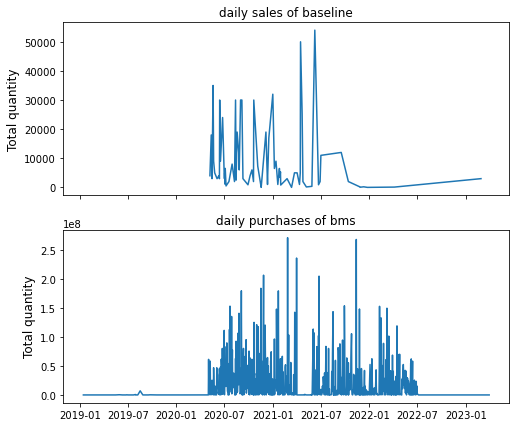

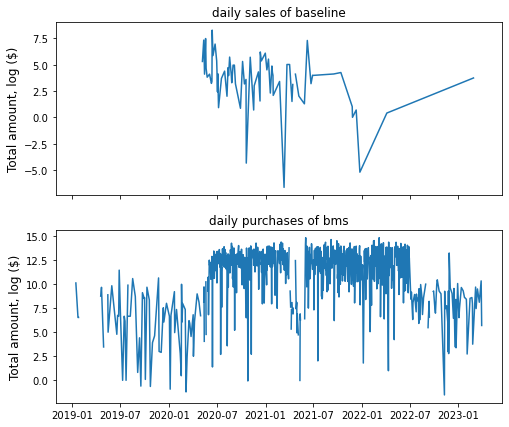

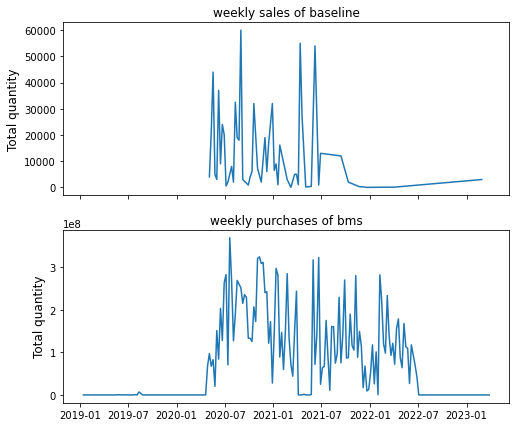

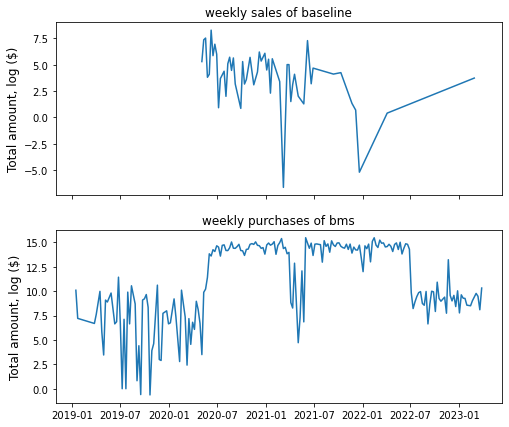

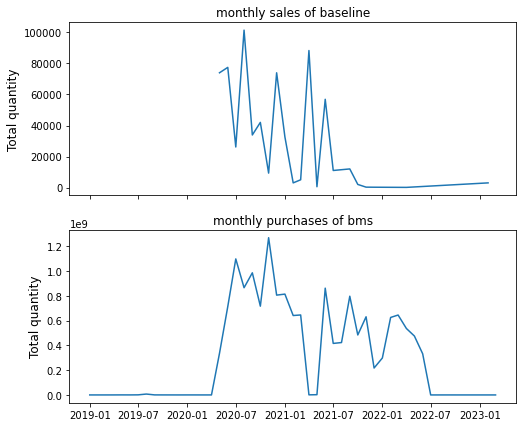

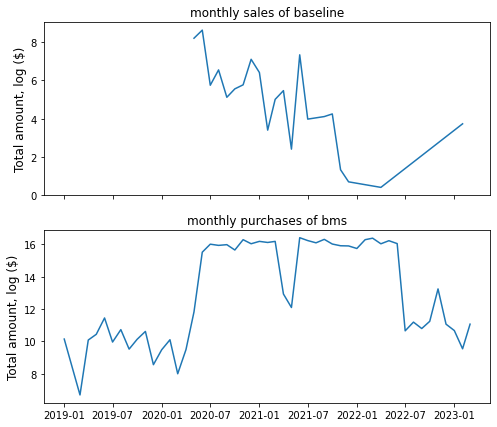

Compare sale, purchase quantity per hscode...
48211090 105
48059190000 0
48059190100 0
48059110000 0
48211090 105
48059190000 0
48059190100 0
48059110000 0
48211090 105
48059190000 0
48059190100 0
48059110000 0


In [308]:
SUPPLY_PROD = tuple(BASELINE_HS6)
BUY_PROD = 'bms'
companies = ['%lg %', 'lgdvh', 'lgevh', 'lgitvh']
tx_type = 'supplier'
hs_codes = ['482110', '480591']

baseline(SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, companies=companies, tx_type=tx_type, hs_codes=hs_codes)

# Demonstrate Database inconsistency

In [ ]:
tx_col = "supplier_t"
companies = ["%neway %"]
hs = "850760"
tx_string = f"{tx_col} like '{companies[0]}'" + "".join([f" or {tx_col} like '{company}'" for company in companies[1:]])
query = f"select * from logistic_data where ({tx_string} and hs_code like '{hs}%');"
df = rs.query_df(query)

tx_col = "buyer_t"
companies = ["globe exim"]
hs = "850760"
tx_string = f"{tx_col} like '{companies[0]}'" + "".join([f" or {tx_col} like '{company}'" for company in companies[1:]])
query = f"select * from logistic_data where ({tx_string} and hs_code like '{hs}%');"
df2 = rs.query_df(query)

tx_col = "supplier_t"
companies = ["%neway %"]
hs = "850760"
tx_string = f"{tx_col} like '{companies[0]}'" + "".join([f" or {tx_col} like '{company}'" for company in companies[1:]])
query = f"select * from index_hs6 where ({tx_string} and hs6 like '{hs}%');"
df_1 = rs.query_df(query)

# Meta Analysis - Top 200 Supplier

## Choosing Baseline

### Discover Baseline Options

In [12]:
warnings.filterwarnings('ignore')
rs = RedshiftClass('zhiyin','Zhiyin123')

Successful connection！
 


In [13]:
# load index: top 100 supplier in terms of bill_count
query = f"select hs6, SUM(bill_count) from index_hs6 WHERE bill_count IS NOT NULL GROUP BY hs6 ORDER BY SUM(bill_count) DESC LIMIT 100;"
index = rs.query_df(query)

# load hs_category_description table
query = f"select * from hs_category_description"
hs_index = rs.query_df(query)

In [17]:
index.merge(hs_index, how='left', on='hs6').head(50)

hs6      sum                                           category  \
0   853690  2693959                 Electrical Machinery and Equipment   
1   853890  2205674                 Electrical Machinery and Equipment   
2   392690  1464688                      Plastics and Articles Thereof   
3   851770   949306                 Electrical Machinery and Equipment   
4   854720   878331                 Electrical Machinery and Equipment   
5   940190   738867  Furniture; bedding, mattresses, mattress supports   
6   732690   732199                          Articles of Iron or Steel   
7   853669   671801                 Electrical Machinery and Equipment   
8   853610   640126                 Electrical Machinery and Equipment   
9   870899   619546             Vehicles Other Than Railway or Tramway   
10  940120   598709  Furniture; bedding, mattresses, mattress supports   
11  391990   577564                      Plastics and Articles Thereof   
12  731815   558260                          Articles of Iron or Steel   
13  940199   539939                                                NaN   
14  854790   461931                 Electrical Machinery and Equipment   
15  870829   413799             Vehicles Other Than Railway or Tramway   
16  401699   394893                        Rubber and Articles Thereof   
17  851712   383863                 Electrical Machinery and Equipment   
18  401693   382127                        Rubber and Articles Thereof   
19  847330   361377  Nuclear Reactors, Boilers, Machinery, and Mech...   
20  850450   345904                 Electrical Machinery and Equipment   
21  854430   335041                 Electrical Machinery and Equipment   
22  481910   314837  Paper and Paperboard; Articles of Paper Pulp, ...   
23  854442   303692                 Electrical Machinery and Equipment   
24  854690   299701                 Electrical Machinery and Equipment   
25  852990   297570                 Electrical Machinery and Equipment   
26  401695   269949                        Rubber and Articles Thereof   
27  854449   269130                 Electrical Machinery and Equipment   
28  853321   266241                 Electrical Machinery and Equipment   
29  391732   255120                      Plastics and Articles Thereof   
30  630790   247553                                           Footwear   
31  870880   228574             Vehicles Other Than Railway or Tramway   
32  854239   222961                 Electrical Machinery and Equipment   
33  853224   215257                 Electrical Machinery and Equipment   
34  851762   212588                 Electrical Machinery and Equipment   
35  853590   211377                 Electrical Machinery and Equipment   
36  848120   189222  Nuclear Reactors, Boilers, Machinery, and Mech...   
37  850440   185267                 Electrical Machinery and Equipment   
38  392630   183618                      Plastics and Articles Thereof   
39  854231   180297                 Electrical Machinery and Equipment   
40  853710   165102                 Electrical Machinery and Equipment   
41  761699   155754                      Aluminum and Articles Thereof   
42  870821   154838             Vehicles Other Than Railway or Tramway   
43  853650   150476                 Electrical Machinery and Equipment   
44  853641   148457                 Electrical Machinery and Equipment   
45  830242   147435               Miscellaneous Articles of Base Metal   
46  853400   143538                 Electrical Machinery and Equipment   
47  980100   142139                                                NaN   
48  490199   140633  Printed Books, Newspapers, Pictures and Other ...   
49  482390   140436  Paper and Paperboard; Articles of Paper Pulp, ...   

                                         sub_category  \
0                                Electrical apparatus   
1                                Electrical apparatus   
2                                            Plastics   
3   

In [ ]:
# 853710, 830242
# Very promising: 630790, 848120, 490199
# Alternative: bms percetile among all products in terms of r-value

## Test out Baseline Feasibility

In [ ]:
# 392690, 940190, 940120, 391990, 481910

In [15]:
# How does SEVT do? 
warnings.filterwarnings('ignore')
rs = RedshiftClass('zhiyin','Zhiyin123')

companies = ["samsung"]
BUY_PROD = ('392690', '940190', '391990', '481910',)

preprocess_transaction_data(BUY_PROD=BUY_PROD, companies=companies)

Successful connection！
 
Getting supply df...
850760 -> 337161 22065
all df shape is (22065, 26)


id        date supplier_t  \
70489  639182980239405064  2020-05-02       sevt   
87010  639182980239405062  2020-05-02       sevt   
35791  639182980239405063  2020-05-02       sevt   
69099  639182980235210757  2020-05-02       sevt   
70490  639182980226822152  2020-05-02       sevt   

                            supplier_id                            buyer_t  \
70489  24268ac9574a34f49f517af89956e1ac  samsung electronics australia pty   
87010  24268ac9574a34f49f517af89956e1ac   thai-samsung electronics co. ltd   
35791  24268ac9574a34f49f517af89956e1ac   thai-samsung electronics co. ltd   
69099  24268ac9574a34f49f517af89956e1ac  samsung electronics australia pty   
70490  24268ac9574a34f49f517af89956e1ac  samsung electronics australia pty   

                               buyer_id  quantity quantity_unit  price  \
70489  28ce15a440203a4284818863379bcf3f       2.0           PCE   7.46   
87010  97f9c74be068315894c976f584bbc27d       4.0           PCE   6.53   
35791  97f9c74be068315894c976f584bbc27d       1.0           PCE   6.53   
69099  28ce15a440203a4284818863379bcf3f     150.0           PCE   7.29   
70490  28ce15a440203a4284818863379bcf3f     174.0           PCE   6.65   

            amount  ... sub_bill_no orig_port  dest_port   teu  \
70489    14.920000  ...                 HANOI  SYDNEY NS  None   
87010    26.120001  ...                 HANOI    BANGKOK  None   
35791     6.530000  ...                 HANOI    BANGKOK  None   
69099  1093.500000  ...                 HANOI  SYDNEY NS  None   
70490  1157.099976  ...                 HANOI  SYDNEY NS  None   

              data_source trans_type trans_type_code vessel_name  \
70489  EXP_VIETNAM_CD_AEN                    UNKNOWN               
87010  EXP_VIETNAM_CD_AEN                    UNKNOWN               
35791  EXP_VIETNAM_CD_AEN                    UNKNOWN               
69099  EXP_VIETNAM_CD_AEN                    UNKNOWN               
70490  EXP_VIETNAM_CD_AEN                    UNKNOWN               

                                           supplier_addr  \
70489  Yen Binh Industrial Zone, Dong Tien Ward, town...   
87010  Yen Binh Industrial Zone, Dong Tien Ward, town...   
35791  Yen Binh Industrial Zone, Dong Tien Ward, town...   
69099  Yen Binh Industrial Zone, Dong Tien Ward, town...   
70490  Yen Binh Industrial Zone, Dong Tien Ward, town...   

                                              buyer_addr  
70489  ,SYDNEY OLYMPIC PARK 2127,NEW SOUTH WALES AUST...  
87010                       ,THAILAND (GENERAL) THAILAND  
35791                       ,THAILAND (GENERAL) THAILAND  
69099  ,SYDNEY OLYMPIC PARK 2127,NEW SOUTH WALES AUST...  
70490  ,SYDNEY OLYMPIC PARK 2127,NEW SOUTH WALES AUST...  

[5 rows x 26 columns]

Getting buy df...
392690 -> 165382 35756
940190 -> 39 16
391990 -> 662255 93437
481910 -> 69501 14537
all df shape is (143746, 26)


id        date         supplier_t  \
100209  640432034017521668  2020-05-02   imct corporation   
37883   640432034004938760  2020-05-02     toptec co.,ltd   
37938   640432034000744459  2020-05-02     toptec co.,ltd   
19155   640432034034298887  2020-05-02  daehyun st co ltd   
100210  640432034017521665  2020-05-02   imct corporation   

                             supplier_id buyer_t  \
100209  2df6b5e2e39034c9aca0d64d70fcaeac    sevt   
37883   b33b053c2d2132c69846d2a903b46566    sevt   
37938   b33b053c2d2132c69846d2a903b46566    sevt   
19155   0cd42b5b02463630b51c4bc3abc8298c    sevt   
100210  2df6b5e2e39034c9aca0d64d70fcaeac    sevt   

                                buyer_id  quantity quantity_unit  price  \
100209  24268ac9574a34f49f517af89956e1ac    4000.0           PCE    NaN   
37883   24268ac9574a34f49f517af89956e1ac    5400.0           PCE    NaN   
37938   24268ac9574a34f49f517af89956e1ac   53500.0           PCE    NaN   
19155   24268ac9574a34f49f517af89956e1ac    8000.0           PCE    NaN   
100210  24268ac9574a34f49f517af89956e1ac   40000.0           PCE    NaN   

        amount  ...  sub_bill_no orig_port dest_port   teu  \
100209     NaN  ...                INCHEON    HA NOI  None   
37883      NaN  ...                INCHEON    HA NOI  None   
37938      NaN  ...                INCHEON    HA NOI  None   
19155      NaN  ...                INCHEON    HA NOI  None   
100210     NaN  ...                INCHEON    HA NOI  None   

               data_source trans_type trans_type_code vessel_name  \
100209  IMP_VIETNAM_CD_AEN                    UNKNOWN               
37883   IMP_VIETNAM_CD_AEN                    UNKNOWN               
37938   IMP_VIETNAM_CD_AEN                    UNKNOWN               
19155   IMP_VIETNAM_CD_AEN                    UNKNOWN               
100210  IMP_VIETNAM_CD_AEN                    UNKNOWN               

                           supplier_addr  \
100209                               ,KR   
37883                             ,10,KR   
37938                             ,10,KR   
19155   ,KOREA (300-8 GONGDAN-DONG 10,KR   
100210                               ,KR   

                                               buyer_addr  
100209  Yen Binh Industrial Zone, Dong Tien Ward, town...  
37883   Yen Binh Industrial Zone, Dong Tien Ward, town...  
37938   Yen Binh Industrial Zone, Dong Tien Ward, town...  
19155   Yen Binh Industrial Zone, Dong Tien Ward, town...  
100210  Yen Binh Industrial Zone, Dong Tien Ward, town...  

[5 rows x 26 columns]

(                       id        date supplier_t  \
 70489  639182980239405064  2020-05-02       sevt   
 87010  639182980239405062  2020-05-02       sevt   
 35791  639182980239405063  2020-05-02       sevt   
 69099  639182980235210757  2020-05-02       sevt   
 70490  639182980226822152  2020-05-02       sevt   
 ...                   ...         ...        ...   
 26479  665682853482541058  2022-06-30       sevt   
 26480  665682851045650439  2022-06-30       sevt   
 11120  665682822658600967  2022-06-30       sevt   
 28732  665682853474152455  2022-06-30       sevt   
 50696  665682822658600964  2022-06-30       sevt   
 
                             supplier_id                            buyer_t  \
 70489  24268ac9574a34f49f517af89956e1ac  samsung electronics australia pty   
 87010  24268ac9574a34f49f517af89956e1ac   thai-samsung electronics co. ltd   
 35791  24268ac9574a34f49f517af89956e1ac   thai-samsung electronics co. ltd   
 69099  24268ac9574a34f49f517af89956e1ac  sams

Mega Analysis of Sale - Purchase Pipeline on Daily, Weekly, and Monthly Scale

Assume Transaction Data Has Been Queried and Preprocessed...
Constructing Transaction Time Dataframe...Loading from csv...
Supply name is battery; buy name is baseline
22065 143746


date   datetime    month month_datetime       week week_datetime
0  2020-05-02 2020-05-02  2020-05     2020-05-01  2020-18-1    2020-04-27
1  2020-05-02 2020-05-02  2020-05     2020-05-01  2020-18-1    2020-04-27
2  2020-05-02 2020-05-02  2020-05     2020-05-01  2020-18-1    2020-04-27
3  2020-05-02 2020-05-02  2020-05     2020-05-01  2020-18-1    2020-04-27
4  2020-05-02 2020-05-02  2020-05     2020-05-01  2020-18-1    2020-04-27

Plotting sale, purchase over time...


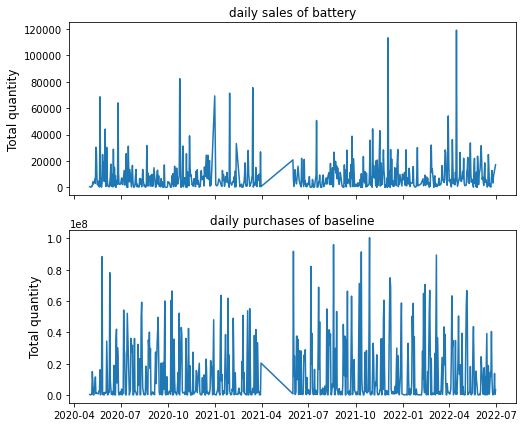

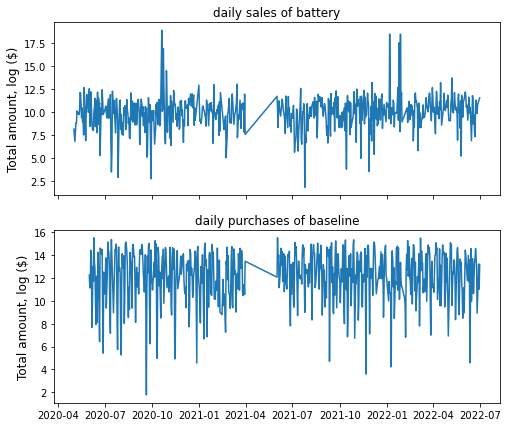

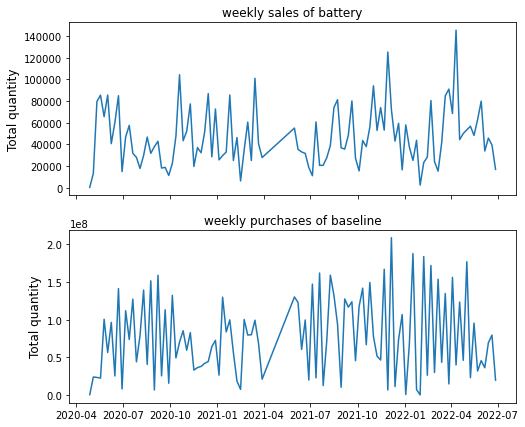

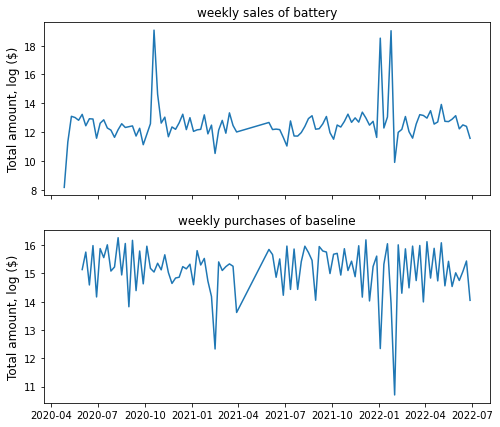

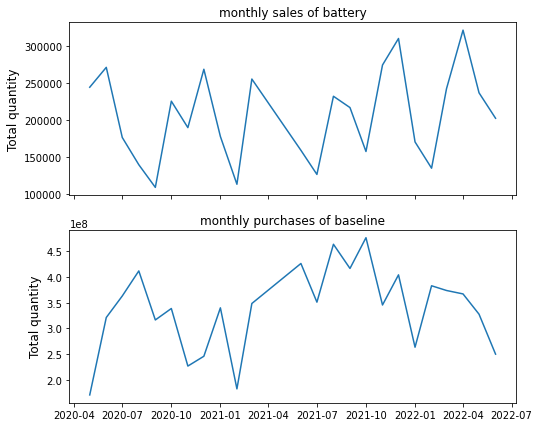

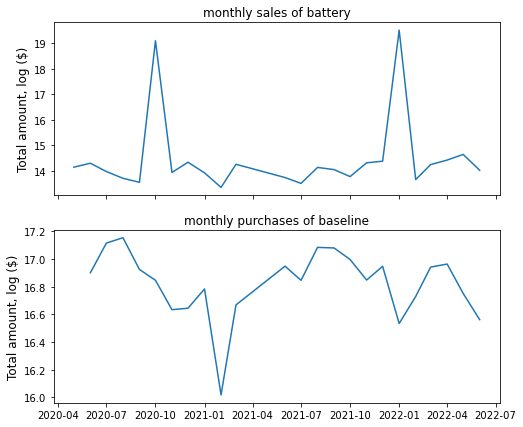

Compare sale, purchase quantity per hscode...
392690 35756 r=-0.016 (n=545, p=0.709)
940190 16
391990 93437 r=-0.016 (n=513, p=0.720)
481910 14537 r=0.005 (n=258, p=0.940)


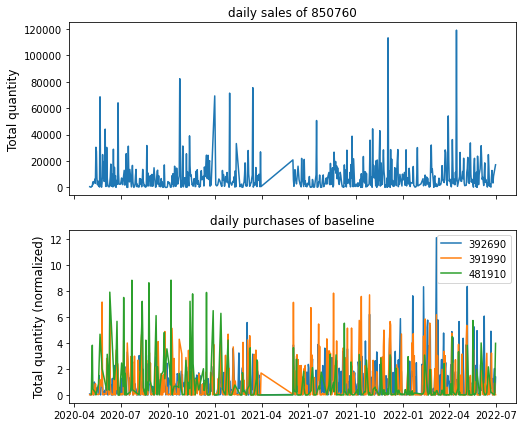

392690 35756 r=0.021 (n=106, p=0.829)
940190 16
391990 93437 r=0.049 (n=106, p=0.615)
481910 14537 r=-0.046 (n=101, p=0.650)


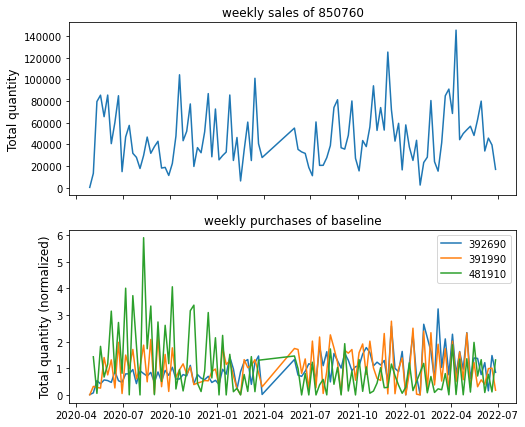

392690 35756 r=0.151 (n=24, p=0.482)
940190 16
391990 93437 r=0.016 (n=24, p=0.941)
481910 14537 r=-0.085 (n=24, p=0.692)


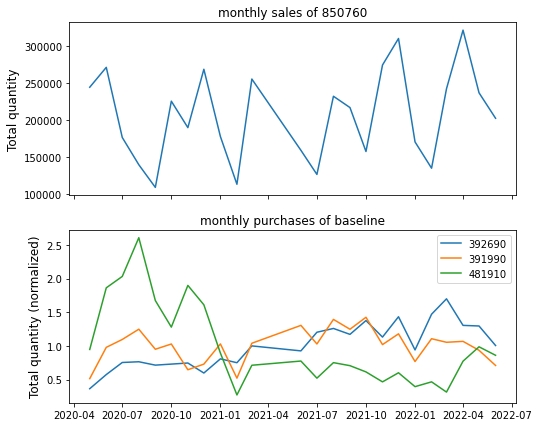

In [16]:
supply_df, buy_df = mega_sale_purchase_pipeline(BUY_PROD=BUY_PROD, csv_name='sevt')

In [21]:
# How does lg do? 
warnings.filterwarnings('ignore')
rs = RedshiftClass('zhiyin','Zhiyin123')

companies = ['%lg %', 'lgdvh', 'lgevh', 'lgitvh']
BUY_PROD = ('392690', '940190', '391990', '481910',)

preprocess_transaction_data(BUY_PROD=BUY_PROD, companies=companies)

Successful connection！
 
Getting supply df...
850760 -> 2151612 728572
all df shape is (728572, 26)


id        date          supplier_t  \
1684724  638369365890510850  2019-01-01  lg electronics inc   
1594431  641812364620279829  2019-01-01         lg chem ltd   
1684723  638369365890510851  2019-01-01  lg electronics inc   
45234    638369365924065282  2019-01-01  lg electronics inc   
905959   638369365928259586  2019-01-01  lg electronics inc   

                              supplier_id                     buyer_t  \
1684724  9fa2a1d616683b07848b0839d017a7a2          lg electronics inc   
1594431  990e23f5c0ad3e63aabfa5e349b1404e  mylan laboratories limited   
1684723  9fa2a1d616683b07848b0839d017a7a2          lg electronics inc   
45234    9fa2a1d616683b07848b0839d017a7a2          lg electronics inc   
905959   9fa2a1d616683b07848b0839d017a7a2          lg electronics inc   

                                 buyer_id  quantity quantity_unit  price  \
1684724  9fa2a1d616683b07848b0839d017a7a2     800.0           CTN    NaN   
1594431  44891cbdfde23fd7b4ba6ee186799699      30.0           MTS  835.0   
1684723  9fa2a1d616683b07848b0839d017a7a2     749.0           CTN    NaN   
45234    9fa2a1d616683b07848b0839d017a7a2     455.0           CTN    NaN   
905959   9fa2a1d616683b07848b0839d017a7a2     783.0           CTN    NaN   

          amount  ...       sub_bill_no orig_port         dest_port   teu  \
1684724      NaN  ...  ZIMUSEL900192046     BUSAN  SAVANNAH GEORGIA   2.0   
1594431  25050.0  ...                              VIZAG SEA INVTZ1   NaN   
1684723      NaN  ...  ZIMUSEL900192033     BUSAN  SAVANNAH GEORGIA  10.0   
45234        NaN  ...  ZIMUSEL900192017     BUSAN  SAVANNAH GEORGIA  10.0   
905959       NaN  ...  ZIMUSEL900192034     BUSAN  SAVANNAH GEORGIA   4.0   

                data_source         trans_type    trans_type_code  \
1684724  IMP_AMERICA_BL_SEA  SEA CONTAINERIZED  SEA CONTAINERIZED   
1594431    IMP_INDIA_CD_DEF                SEA                SEA   
1684723  IMP_AMERICA_BL_SEA  SEA CONTAINERIZED  SEA CONTAINERIZED   
45234    IMP_AMERICA_BL_SEA  SEA CONTAINERIZED  SEA CONTAINERIZED   
905959   IMP_AMERICA_BL_SEA  SEA CONTAINERIZED  SEA CONTAINERIZED   

         vessel_name                                      supplier_addr  \
1684724  MSC CHICAGO  lg twin towers 128, yeoui-daero youngdungpo-gu...   
1594431               LG TWIN TOWER BUILDING 20 YOUZDO DONG YOUNGDUN...   
1684723  MSC CHICAGO  lg twin towers 128, yeoui-daero youngdungpo-gu...   
45234    MSC CHICAGO  lg twin towers 128, yeoui-daero youngdungpo-gu...   
905959   MSC CHICAGO  lg twin towers 128, yeoui-daero youngdungpo-gu...   

                                                buyer_addr  
1684724  . 1000 sylvan avenue, englewood cliffs, nj, 07...  
1594431  1-1-151/1, SAIRAM TOWERS, 4TH FLOORALEXANDER R...  
1684723  . 1000 sylvan avenue, englewood cliffs, nj, 07...  
45234    . 1000 sylvan avenue, englewood cliffs, nj, 07...  
905959   . 1000 sylvan avenue, englewood cliffs, nj, 07...  

[5 rows x 26 columns]

Getting buy df...
392690 -> 2289768 759467
940190 -> 2289608 759407
391990 -> 2289608 759407
481910 -> 2289608 759407
all df shape is (759467, 26)


id        date          supplier_t  \
880248   638369365928259586  2019-01-01  lg electronics inc   
1846843  638369365890510850  2019-01-01  lg electronics inc   
56405    638369365924065282  2019-01-01  lg electronics inc   
1846842  638369365890510851  2019-01-01  lg electronics inc   
62547    638369552419598345  2019-01-02  lg electronics inc   

                              supplier_id             buyer_t  \
880248   9fa2a1d616683b07848b0839d017a7a2  lg electronics inc   
1846843  9fa2a1d616683b07848b0839d017a7a2  lg electronics inc   
56405    9fa2a1d616683b07848b0839d017a7a2  lg electronics inc   
1846842  9fa2a1d616683b07848b0839d017a7a2  lg electronics inc   
62547    9fa2a1d616683b07848b0839d017a7a2  lg electronics inc   

                                 buyer_id  quantity quantity_unit  price  \
880248   9fa2a1d616683b07848b0839d017a7a2     783.0           CTN    NaN   
1846843  9fa2a1d616683b07848b0839d017a7a2     800.0           CTN    NaN   
56405    9fa2a1d616683b07848b0839d017a7a2     455.0           CTN    NaN   
1846842  9fa2a1d616683b07848b0839d017a7a2     749.0           CTN    NaN   
62547    9fa2a1d616683b07848b0839d017a7a2      75.0           CTN    NaN   

         amount  ...       sub_bill_no orig_port              dest_port   teu  \
880248      NaN  ...  ZIMUSEL900192034     BUSAN       SAVANNAH GEORGIA   4.0   
1846843     NaN  ...  ZIMUSEL900192046     BUSAN       SAVANNAH GEORGIA   2.0   
56405       NaN  ...  ZIMUSEL900192017     BUSAN       SAVANNAH GEORGIA  10.0   
1846842     NaN  ...  ZIMUSEL900192033     BUSAN       SAVANNAH GEORGIA  10.0   
62547       NaN  ...                       BUSAN  LONG BEACH CALIFORNIA   6.0   

                data_source         trans_type    trans_type_code  \
880248   IMP_AMERICA_BL_SEA  SEA CONTAINERIZED  SEA CONTAINERIZED   
1846843  IMP_AMERICA_BL_SEA  SEA CONTAINERIZED  SEA CONTAINERIZED   
56405    IMP_AMERICA_BL_SEA  SEA CONTAINERIZED  SEA CONTAINERIZED   
1846842  IMP_AMERICA_BL_SEA  SEA CONTAINERIZED  SEA CONTAINERIZED   
62547    IMP_AMERICA_BL_SEA  SEA CONTAINERIZED  SEA CONTAINERIZED   

         vessel_name                                      supplier_addr  \
880248   MSC CHICAGO  lg twin towers 128, yeoui-daero youngdungpo-gu...   
1846843  MSC CHICAGO  lg twin towers 128, yeoui-daero youngdungpo-gu...   
56405    MSC CHICAGO  lg twin towers 128, yeoui-daero youngdungpo-gu...   
1846842  MSC CHICAGO  lg twin towers 128, yeoui-daero youngdungpo-gu...   
62547    OOCL LONDON  lg twin towers 128, yeoui-daero youngdungpo-gu...   

                                                buyer_addr  
880248   . 1000 sylvan avenue, englewood cliffs, nj, 07...  
1846843  . 1000 sylvan avenue, englewood cliffs, nj, 07...  
56405    . 1000 sylvan avenue, englewood cliffs, nj, 07...  
1846842  . 1000 sylvan avenue, englewood cliffs, nj, 07...  
62547    . 1000 sylvan avenue , englewood cliffs, nj, 0...  

[5 rows x 26 columns]

(                         id        date          supplier_t  \
 1684724  638369365890510850  2019-01-01  lg electronics inc   
 1594431  641812364620279829  2019-01-01         lg chem ltd   
 1684723  638369365890510851  2019-01-01  lg electronics inc   
 45234    638369365924065282  2019-01-01  lg electronics inc   
 905959   638369365928259586  2019-01-01  lg electronics inc   
 ...                     ...         ...                 ...   
 53635    756593760579956745  2023-04-01  lg electronics inc   
 73618    756593760579956741  2023-04-01  lg electronics inc   
 133650   756593760563179520  2023-04-01  lg electronics inc   
 53637    756593760567373827  2023-04-01  lg electronics inc   
 1050075  756593760579956742  2023-04-01  lg electronics inc   
 
                               supplier_id                     buyer_t  \
 1684724  9fa2a1d616683b07848b0839d017a7a2          lg electronics inc   
 1594431  990e23f5c0ad3e63aabfa5e349b1404e  mylan laboratories limited   
 1684723

Mega Analysis of Sale - Purchase Pipeline on Daily, Weekly, and Monthly Scale

Assume Transaction Data Has Been Queried and Preprocessed...
Constructing Transaction Time Dataframe...Loading from csv...
Supply name is battery; buy name is baseline
728572 759467


date   datetime    month month_datetime       week week_datetime
0  2019-01-01 2019-01-01  2019-01     2019-01-01  2019-01-1    2018-12-31
1  2019-01-01 2019-01-01  2019-01     2019-01-01  2019-01-1    2018-12-31
2  2019-01-01 2019-01-01  2019-01     2019-01-01  2019-01-1    2018-12-31
3  2019-01-01 2019-01-01  2019-01     2019-01-01  2019-01-1    2018-12-31
4  2019-01-01 2019-01-01  2019-01     2019-01-01  2019-01-1    2018-12-31

Plotting sale, purchase over time...


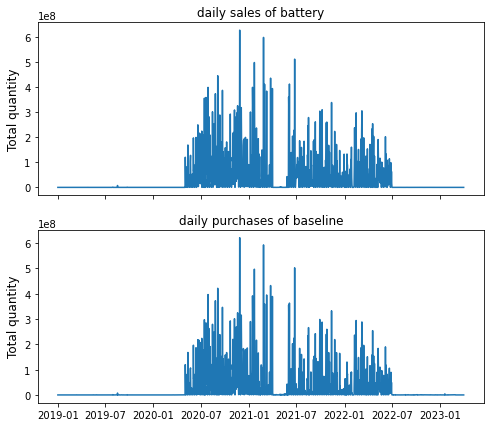

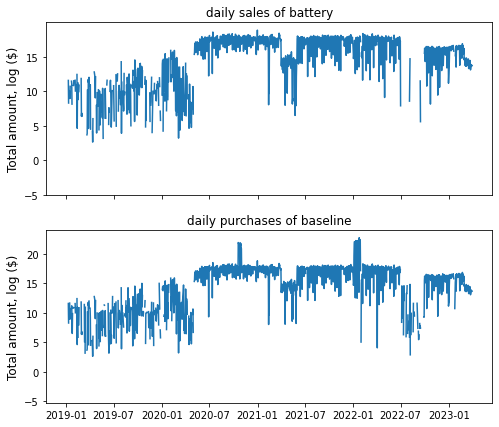

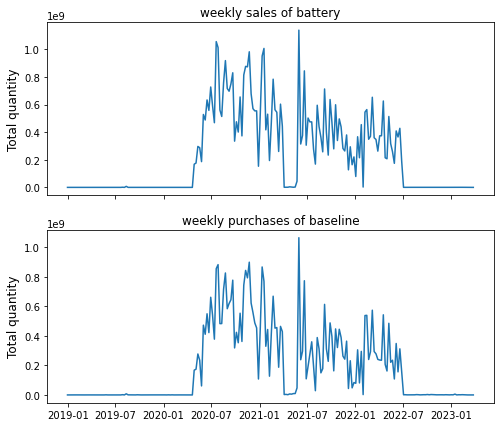

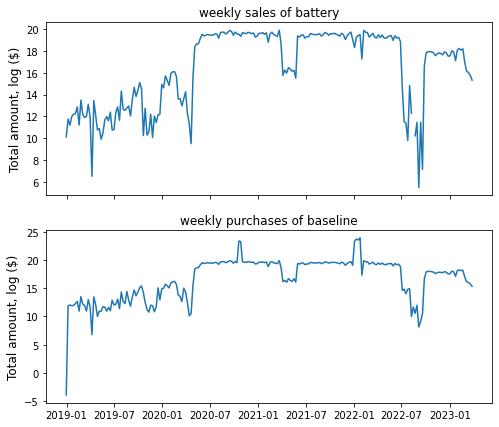

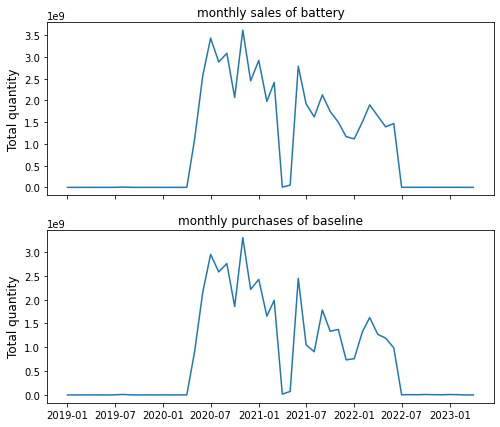

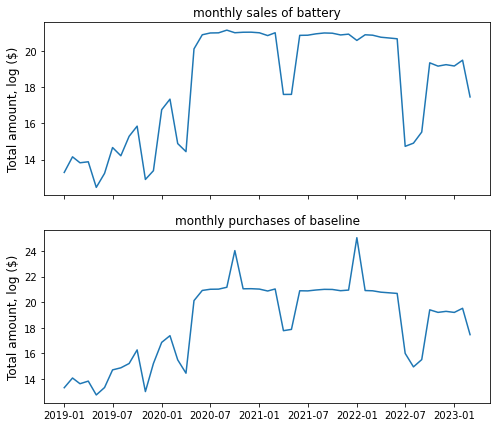

Compare sale, purchase quantity per hscode...
392690 5712 r=0.025 (n=393, p=0.622)
940190 0
391990 7832 r=0.007 (n=337, p=0.903)
481910 866 r=0.025 (n=141, p=0.773)


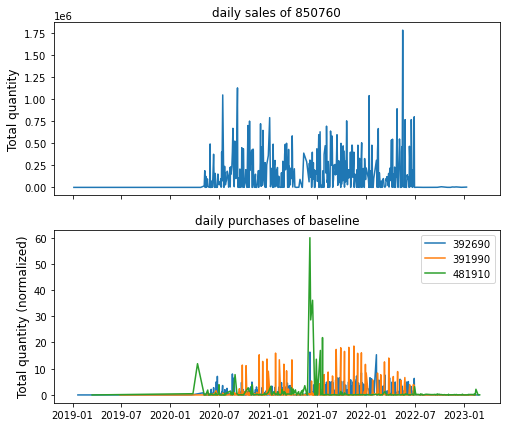

392690 5712 r=0.263 (n=115, p=0.005)
940190 0
391990 7832 r=0.009 (n=111, p=0.925)
481910 866 r=0.103 (n=114, p=0.275)


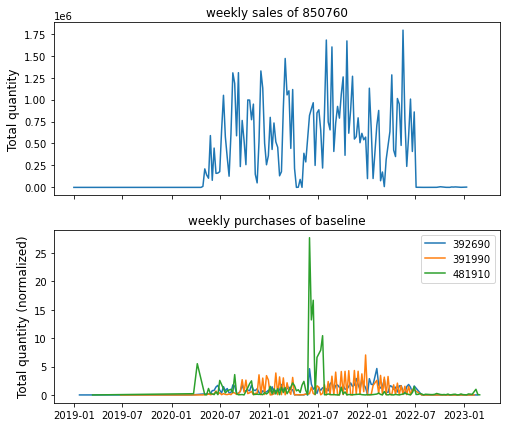

392690 5712 r=0.704 (n=32, p=0.000)
940190 0
391990 7832 r=0.571 (n=29, p=0.001)
481910 866 r=0.193 (n=34, p=0.273)


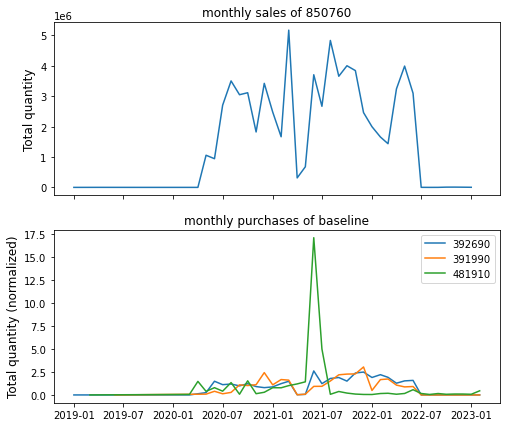

In [22]:
supply_df, buy_df = mega_sale_purchase_pipeline(BUY_PROD=BUY_PROD, csv_name='lg')

### Battery-BMS Analysis

In [19]:
# How does samsung do? 
companies = ["sevt"]
preprocess_transaction_data(companies=companies)

Getting supply df...
850760 -> 337161 22065
all df shape is (22065, 26)


id        date supplier_t  \
91564   639182980226822153  2020-05-02       sevt   
79288   639182980239405062  2020-05-02       sevt   
121629  639182980235210757  2020-05-02       sevt   
61736   639182980239405064  2020-05-02       sevt   
61737   639182980226822152  2020-05-02       sevt   

                             supplier_id                            buyer_t  \
91564   24268ac9574a34f49f517af89956e1ac  samsung electronics australia pty   
79288   24268ac9574a34f49f517af89956e1ac   thai-samsung electronics co. ltd   
121629  24268ac9574a34f49f517af89956e1ac  samsung electronics australia pty   
61736   24268ac9574a34f49f517af89956e1ac  samsung electronics australia pty   
61737   24268ac9574a34f49f517af89956e1ac  samsung electronics australia pty   

                                buyer_id  quantity quantity_unit  price  \
91564   28ce15a440203a4284818863379bcf3f     178.0           PCE   6.65   
79288   97f9c74be068315894c976f584bbc27d       4.0           PCE   6.53   
121629  28ce15a440203a4284818863379bcf3f     150.0           PCE   7.29   
61736   28ce15a440203a4284818863379bcf3f       2.0           PCE   7.46   
61737   28ce15a440203a4284818863379bcf3f     174.0           PCE   6.65   

             amount  ... sub_bill_no orig_port  dest_port   teu  \
91564   1183.699951  ...                 HANOI  SYDNEY NS  None   
79288     26.120001  ...                 HANOI    BANGKOK  None   
121629  1093.500000  ...                 HANOI  SYDNEY NS  None   
61736     14.920000  ...                 HANOI  SYDNEY NS  None   
61737   1157.099976  ...                 HANOI  SYDNEY NS  None   

               data_source trans_type trans_type_code vessel_name  \
91564   EXP_VIETNAM_CD_AEN                    UNKNOWN               
79288   EXP_VIETNAM_CD_AEN                    UNKNOWN               
121629  EXP_VIETNAM_CD_AEN                    UNKNOWN               
61736   EXP_VIETNAM_CD_AEN                    UNKNOWN               
61737   EXP_VIETNAM_CD_AEN                    UNKNOWN               

                                            supplier_addr  \
91564   Yen Binh Industrial Zone, Dong Tien Ward, town...   
79288   Yen Binh Industrial Zone, Dong Tien Ward, town...   
121629  Yen Binh Industrial Zone, Dong Tien Ward, town...   
61736   Yen Binh Industrial Zone, Dong Tien Ward, town...   
61737   Yen Binh Industrial Zone, Dong Tien Ward, town...   

                                               buyer_addr  
91564   ,SYDNEY OLYMPIC PARK 2127,NEW SOUTH WALES AUST...  
79288                        ,THAILAND (GENERAL) THAILAND  
121629  ,SYDNEY OLYMPIC PARK 2127,NEW SOUTH WALES AUST...  
61736   ,SYDNEY OLYMPIC PARK 2127,NEW SOUTH WALES AUST...  
61737   ,SYDNEY OLYMPIC PARK 2127,NEW SOUTH WALES AUST...  

[5 rows x 26 columns]

Getting buy df...
850450 -> 135823 23860
850730 -> None
850780 -> 433 49
850790 -> None
853222 -> 67 15
853223 -> 22 2
853321 -> 50768 21978
853340 -> 5848 1845
853630 -> 174 21
853641 -> 1805 289
853890 -> 1104 167
854190 -> None
854239 -> 56846 24869
854290 -> None
854411 -> 274 250
854442 -> 22070 4781
854449 -> 2739 719
all df shape is (78845, 26)


id        date                         supplier_t  \
18681  640432034051076099  2020-05-02  tianjin wisol electronics co.,ltd   
23232  640432034051076100  2020-05-02  tianjin wisol electronics co.,ltd   
27058  640432034046881794  2020-05-02  tianjin wisol electronics co.,ltd   
92995  640432034063659013  2020-05-02  samsung electronics h.k. co., ltd   
16990  640432034046881798  2020-05-02  tianjin wisol electronics co.,ltd   

                            supplier_id buyer_t  \
18681  fd41b37ad2933852b4e8f867d6789259    sevt   
23232  fd41b37ad2933852b4e8f867d6789259    sevt   
27058  fd41b37ad2933852b4e8f867d6789259    sevt   
92995  14ae24727d9f3e14891ffa3fe7d8819c    sevt   
16990  fd41b37ad2933852b4e8f867d6789259    sevt   

                               buyer_id  quantity quantity_unit  price  \
18681  24268ac9574a34f49f517af89956e1ac    8000.0           PCE    NaN   
23232  24268ac9574a34f49f517af89956e1ac    8000.0           PCE    NaN   
27058  24268ac9574a34f49f517af89956e1ac    8000.0           PCE    NaN   
92995  24268ac9574a34f49f517af89956e1ac  360000.0           PCE    NaN   
16990  24268ac9574a34f49f517af89956e1ac   16000.0           PCE    NaN   

       amount  ...  sub_bill_no orig_port dest_port   teu         data_source  \
18681     NaN  ...                TIANJIN    HA NOI  None  IMP_VIETNAM_CD_AEN   
23232     NaN  ...                TIANJIN    HA NOI  None  IMP_VIETNAM_CD_AEN   
27058     NaN  ...                TIANJIN    HA NOI  None  IMP_VIETNAM_CD_AEN   
92995     NaN  ...                TIANJIN    HA NOI  None  IMP_VIETNAM_CD_AEN   
16990     NaN  ...                TIANJIN    HA NOI  None  IMP_VIETNAM_CD_AEN   

      trans_type trans_type_code vessel_name supplier_addr  \
18681                    UNKNOWN                    ,30,CN   
23232                    UNKNOWN                    ,30,CN   
27058                    UNKNOWN                    ,30,CN   
92995                    UNKNOWN                       ,HK   
16990                    UNKNOWN                    ,30,CN   

                                              buyer_addr  
18681  Yen Binh Industrial Zone, Dong Tien Ward, town...  
23232  Yen Binh Industrial Zone, Dong Tien Ward, town...  
27058  Yen Binh Industrial Zone, Dong Tien Ward, town...  
92995  Yen Binh Industrial Zone, Dong Tien Ward, town...  
16990  Yen Binh Industrial Zone, Dong Tien Ward, town...  

[5 rows x 26 columns]

(                        id        date supplier_t  \
 91564   639182980226822153  2020-05-02       sevt   
 79288   639182980239405062  2020-05-02       sevt   
 121629  639182980235210757  2020-05-02       sevt   
 61736   639182980239405064  2020-05-02       sevt   
 61737   639182980226822152  2020-05-02       sevt   
 ...                    ...         ...        ...   
 30340   665682853474152456  2022-06-30       sevt   
 2424    665682851045650437  2022-06-30       sevt   
 2423    665682853474152460  2022-06-30       sevt   
 30336   665682853490929671  2022-06-30       sevt   
 27039   665682822654406663  2022-06-30       sevt   
 
                              supplier_id                            buyer_t  \
 91564   24268ac9574a34f49f517af89956e1ac  samsung electronics australia pty   
 79288   24268ac9574a34f49f517af89956e1ac   thai-samsung electronics co. ltd   
 121629  24268ac9574a34f49f517af89956e1ac  samsung electronics australia pty   
 61736   24268ac9574a34f49f517

Mega Analysis of Sale - Purchase Pipeline on Daily, Weekly, and Monthly Scale

Assume Transaction Data Has Been Queried and Preprocessed...
Constructing Transaction Time Dataframe...Loading from csv...
Supply name is battery; buy name is bms
22065 78845


date   datetime    month month_datetime       week week_datetime
0  2020-05-02 2020-05-02  2020-05     2020-05-01  2020-18-1    2020-04-27
1  2020-05-02 2020-05-02  2020-05     2020-05-01  2020-18-1    2020-04-27
2  2020-05-02 2020-05-02  2020-05     2020-05-01  2020-18-1    2020-04-27
3  2020-05-02 2020-05-02  2020-05     2020-05-01  2020-18-1    2020-04-27
4  2020-05-02 2020-05-02  2020-05     2020-05-01  2020-18-1    2020-04-27

Plotting sale, purchase over time...


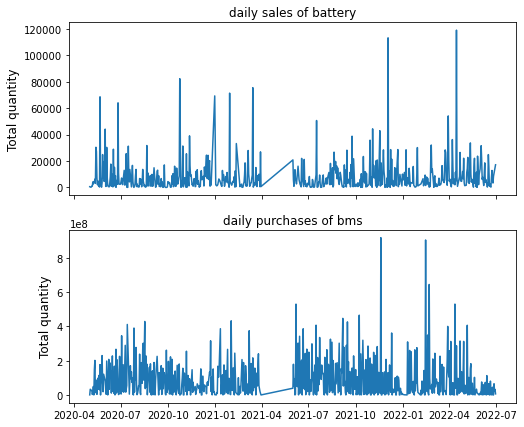

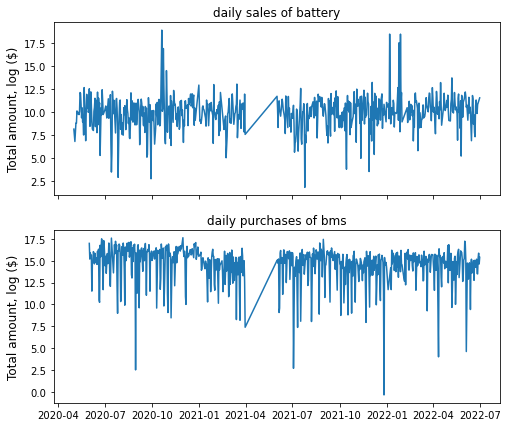

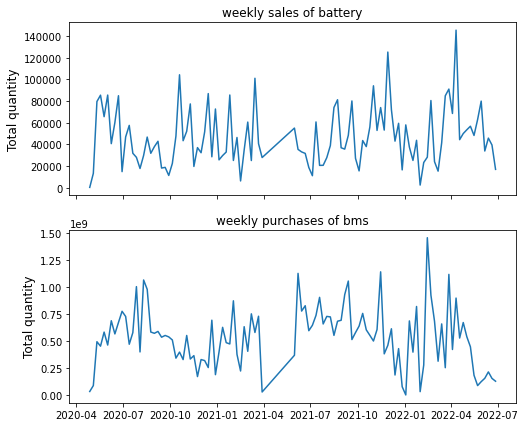

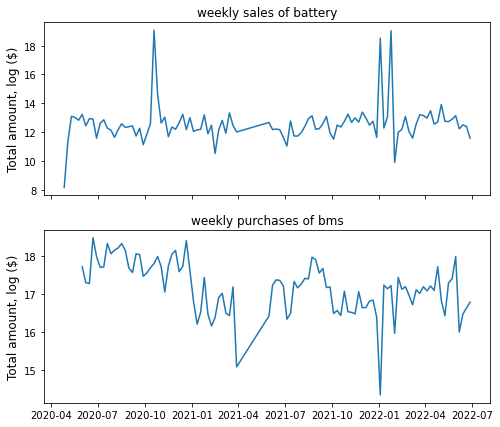

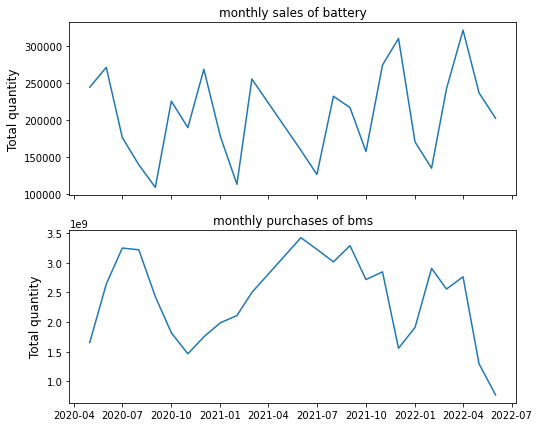

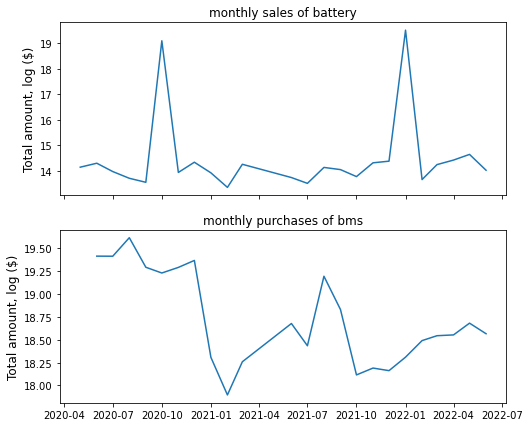

Compare sale, purchase quantity per hscode...
850450 23860 r=0.098 (n=476, p=0.032)
850730 0
850780 49
850790 0
853222 15
853223 2
853321 21978 r=-0.013 (n=365, p=0.808)
853340 1845 r=-0.070 (n=312, p=0.217)
853630 21
853641 289 r=-0.015 (n=154, p=0.850)
853890 167 r=0.011 (n=92, p=0.918)
854190 0
854239 24869 r=0.057 (n=543, p=0.185)
854290 0
854411 250 r=-0.111 (n=67, p=0.373)
854442 4781 r=0.052 (n=437, p=0.275)
854449 719 r=-0.023 (n=170, p=0.767)


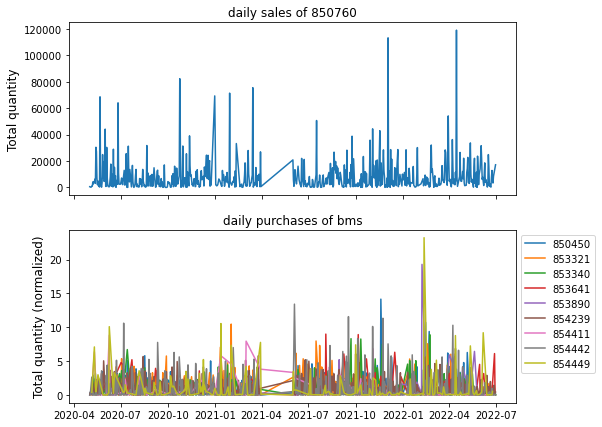

850450 23860 r=0.109 (n=105, p=0.269)
850730 0
850780 49
850790 0
853222 15
853223 2
853321 21978 r=-0.052 (n=105, p=0.599)
853340 1845 r=0.046 (n=104, p=0.644)
853630 21
853641 289 r=-0.159 (n=92, p=0.130)
853890 167 r=0.056 (n=73, p=0.638)
854190 0
854239 24869 r=0.090 (n=106, p=0.358)
854290 0
854411 250 r=0.008 (n=51, p=0.956)
854442 4781 r=0.181 (n=105, p=0.065)
854449 719 r=-0.070 (n=90, p=0.512)


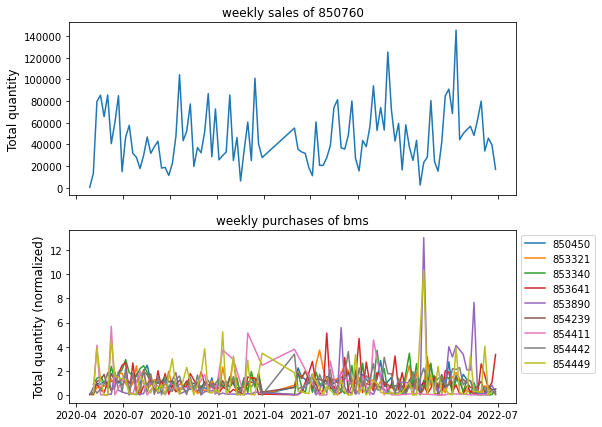

850450 23860 r=-0.089 (n=24, p=0.678)
850730 0
850780 49
850790 0
853222 15
853223 2
853321 21978 r=-0.446 (n=24, p=0.029)
853340 1845 r=-0.169 (n=24, p=0.429)
853630 21
853641 289 r=0.049 (n=24, p=0.821)
853890 167 r=0.218 (n=23, p=0.317)
854190 0
854239 24869 r=-0.079 (n=24, p=0.715)
854290 0
854411 250 r=0.200 (n=24, p=0.348)
854442 4781 r=0.291 (n=24, p=0.168)
854449 719 r=0.010 (n=24, p=0.964)


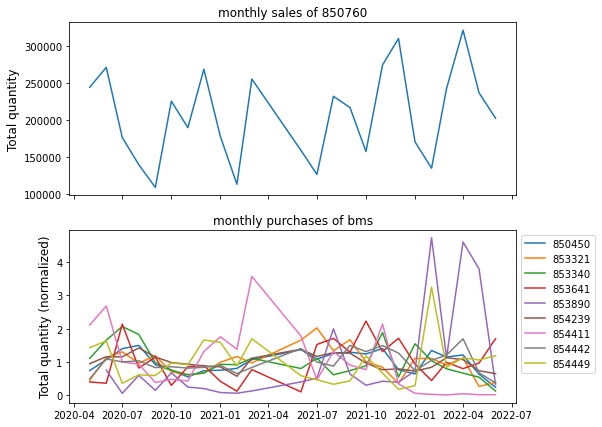

In [20]:
supply_df, buy_df = mega_sale_purchase_pipeline(csv_name='sevt')

In [25]:
# How does lg do? 
warnings.filterwarnings('ignore')
rs = RedshiftClass('zhiyin','Zhiyin123')

companies = ["sdiv"]

supply_df, csv_name = get_transaction_df(PROD='battery', tx_type='supplier', companies=companies)

Successful connection！
 
850760 -> 29827 6001
all df shape is (6001, 26)


id        date supplier_t  \
2417   639182981833240582  2020-05-02       sdiv   
11729  639183026590658570  2020-05-04       sdiv   
22911  639183026573881347  2020-05-04       sdiv   
11731  639183026531938310  2020-05-04       sdiv   
11730  639183026569687042  2020-05-04       sdiv   

                            supplier_id               buyer_t  \
2417   ebcd886afacb3237bf813e45e40bedea   samsung sdi co.,ltd   
11729  ebcd886afacb3237bf813e45e40bedea  samsung sdi co., ltd   
22911  ebcd886afacb3237bf813e45e40bedea  samsung sdi co., ltd   
11731  ebcd886afacb3237bf813e45e40bedea   samsung sdi co.,ltd   
11730  ebcd886afacb3237bf813e45e40bedea  samsung sdi co., ltd   

                               buyer_id  quantity quantity_unit  price  \
2417   1e75b89cb9183414b4aa198e39fd62e0    8500.0           PCE   3.58   
11729  1e75b89cb9183414b4aa198e39fd62e0     599.0           PCE  22.57   
22911  1e75b89cb9183414b4aa198e39fd62e0    6000.0           PCE  15.19   
11731  1e75b89cb9183414b4aa198e39fd62e0   55571.0           PCE   3.58   
11730  1e75b89cb9183414b4aa198e39fd62e0       3.0           PCE  25.00   

              amount  ... sub_bill_no                      orig_port  \
2417    30430.000000  ...                                     HA NOI   
11729   13519.429688  ...              BORDER GATE HUU NGHI LANG SON   
22911   91140.000000  ...              BORDER GATE HUU NGHI LANG SON   
11731  198944.187500  ...                                     HA NOI   
11730      75.000000  ...              BORDER GATE HUU NGHI LANG SON   

                  dest_port   teu         data_source trans_type  \
2417   INCHEON INTL APT SEO  None  EXP_VIETNAM_CD_AEN              
11729                SUZHOU  None  EXP_VIETNAM_CD_AEN              
22911                SUZHOU  None  EXP_VIETNAM_CD_AEN              
11731  INCHEON INTL APT SEO  None  EXP_VIETNAM_CD_AEN              
11730                 CHINA  None  EXP_VIETNAM_CD_AEN              

      trans_type_code vessel_name  \
2417          UNKNOWN               
11729         UNKNOWN               
22911         UNKNOWN               
11731         UNKNOWN               
11730         UNKNOWN               

                                           supplier_addr  \
2417   Roomed1 Yen Industrial Zone, Yen Trung Commune...   
11729  Roomed1 Yen Industrial Zone, Yen Trung Commune...   
22911  Roomed1 Yen Industrial Zone, Yen Trung Commune...   
11731  Roomed1 Yen Industrial Zone, Yen Trung Commune...   
11730  Roomed1 Yen Industrial Zone, Yen Trung Commune...   

                                         buyer_addr  
2417                                                 
11729                                                
22911                                                
11731                                                
11730  ,CHEONAN-SI, CHUNGCHEONGNAM-DO,,31086, KOREA  

[5 rows x 26 columns]

In [23]:
# How does lg do? 
warnings.filterwarnings('ignore')
rs = RedshiftClass('zhiyin','Zhiyin123')

companies = ['%lg %', 'lgdvh', 'lgevh', 'lgitvh']

buy_df, csv_name = get_transaction_df(PROD='bms', tx_type='buyer', companies=companies)

Successful connection！
 
850450 -> 2289612 759409
850730 -> 2289608 759407
850780 -> 2289608 759407
850790 -> 2289608 759407
853222 -> 2289608 759407
853223 -> 2289608 759407
853321 -> 2289608 759407
853340 -> 2289608 759407
853630 -> 2289608 759407
853641 -> 2289608 759407
853890 -> 2289608 759407
854190 -> 2289608 759407
854239 -> 2289900 759520
854290 -> 2289608 759407
854411 -> 2289612 759408
854442 -> 2289646 759420
854449 -> 2289682 759433
all df shape is (759562, 26)


id        date          supplier_t  \
1801398  638369365928259586  2019-01-01  lg electronics inc   
926665   638369365890510851  2019-01-01  lg electronics inc   
956681   638369365924065282  2019-01-01  lg electronics inc   
926666   638369365890510850  2019-01-01  lg electronics inc   
926664   638369552427986947  2019-01-02  lg electronics inc   

                              supplier_id             buyer_t  \
1801398  9fa2a1d616683b07848b0839d017a7a2  lg electronics inc   
926665   9fa2a1d616683b07848b0839d017a7a2  lg electronics inc   
956681   9fa2a1d616683b07848b0839d017a7a2  lg electronics inc   
926666   9fa2a1d616683b07848b0839d017a7a2  lg electronics inc   
926664   9fa2a1d616683b07848b0839d017a7a2  lg electronics inc   

                                 buyer_id  quantity quantity_unit  price  \
1801398  9fa2a1d616683b07848b0839d017a7a2     783.0           CTN    NaN   
926665   9fa2a1d616683b07848b0839d017a7a2     749.0           CTN    NaN   
956681   9fa2a1d616683b07848b0839d017a7a2     455.0           CTN    NaN   
926666   9fa2a1d616683b07848b0839d017a7a2     800.0           CTN    NaN   
926664   9fa2a1d616683b07848b0839d017a7a2      26.0           CTN    NaN   

         amount  ...       sub_bill_no orig_port              dest_port   teu  \
1801398     NaN  ...  ZIMUSEL900192034     BUSAN       SAVANNAH GEORGIA   4.0   
926665      NaN  ...  ZIMUSEL900192033     BUSAN       SAVANNAH GEORGIA  10.0   
956681      NaN  ...  ZIMUSEL900192017     BUSAN       SAVANNAH GEORGIA  10.0   
926666      NaN  ...  ZIMUSEL900192046     BUSAN       SAVANNAH GEORGIA   2.0   
926664      NaN  ...                       BUSAN  LONG BEACH CALIFORNIA   2.0   

                data_source         trans_type    trans_type_code  \
1801398  IMP_AMERICA_BL_SEA  SEA CONTAINERIZED  SEA CONTAINERIZED   
926665   IMP_AMERICA_BL_SEA  SEA CONTAINERIZED  SEA CONTAINERIZED   
956681   IMP_AMERICA_BL_SEA  SEA CONTAINERIZED  SEA CONTAINERIZED   
926666   IMP_AMERICA_BL_SEA  SEA CONTAINERIZED  SEA CONTAINERIZED   
926664   IMP_AMERICA_BL_SEA  SEA CONTAINERIZED  SEA CONTAINERIZED   

         vessel_name                                      supplier_addr  \
1801398  MSC CHICAGO  lg twin towers 128, yeoui-daero youngdungpo-gu...   
926665   MSC CHICAGO  lg twin towers 128, yeoui-daero youngdungpo-gu...   
956681   MSC CHICAGO  lg twin towers 128, yeoui-daero youngdungpo-gu...   
926666   MSC CHICAGO  lg twin towers 128, yeoui-daero youngdungpo-gu...   
926664   OOCL LONDON  lg twin towers 128, yeoui-daero youngdungpo-gu...   

                                                buyer_addr  
1801398  . 1000 sylvan avenue, englewood cliffs, nj, 07...  
926665   . 1000 sylvan avenue, englewood cliffs, nj, 07...  
956681   . 1000 sylvan avenue, englewood cliffs, nj, 07...  
926666   . 1000 sylvan avenue, englewood cliffs, nj, 07...  
926664   . 1000 sylvan avenue , englewood cliffs, nj, 0...  

[5 rows x 26 columns]

Mega Analysis of Sale - Purchase Pipeline on Daily, Weekly, and Monthly Scale

Assume Transaction Data Has Been Queried and Preprocessed...
Constructing Transaction Time Dataframe...Loading from csv...
Supply name is battery; buy name is bms
728572 759562


date   datetime    month month_datetime       week week_datetime
0  2019-01-01 2019-01-01  2019-01     2019-01-01  2019-01-1    2018-12-31
1  2019-01-01 2019-01-01  2019-01     2019-01-01  2019-01-1    2018-12-31
2  2019-01-01 2019-01-01  2019-01     2019-01-01  2019-01-1    2018-12-31
3  2019-01-01 2019-01-01  2019-01     2019-01-01  2019-01-1    2018-12-31
4  2019-01-01 2019-01-01  2019-01     2019-01-01  2019-01-1    2018-12-31

Plotting sale, purchase over time...


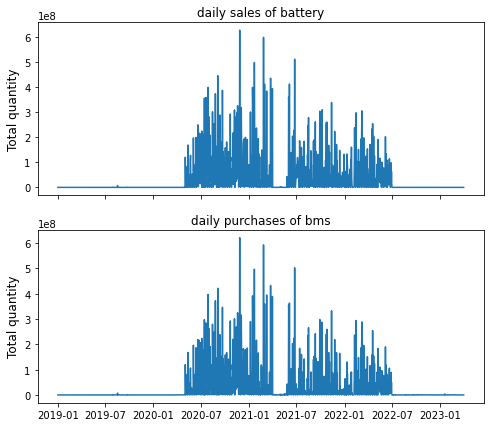

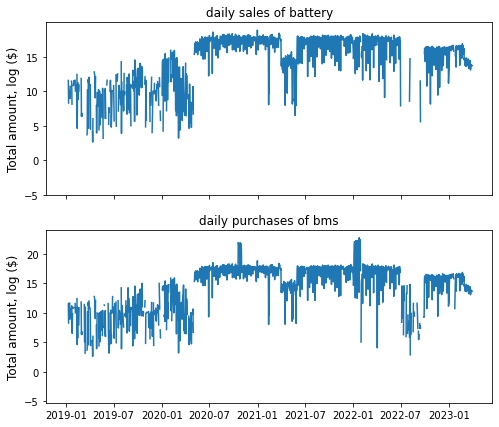

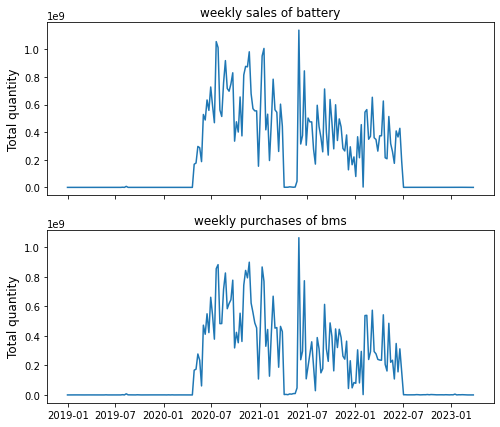

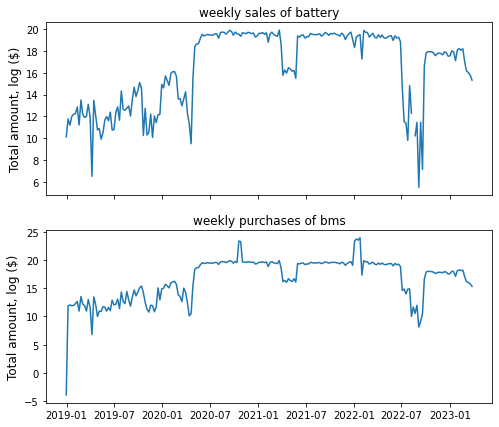

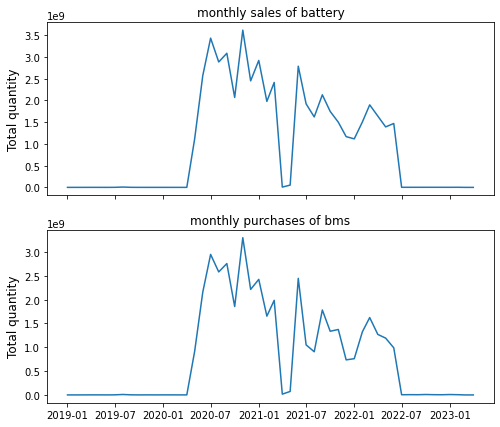

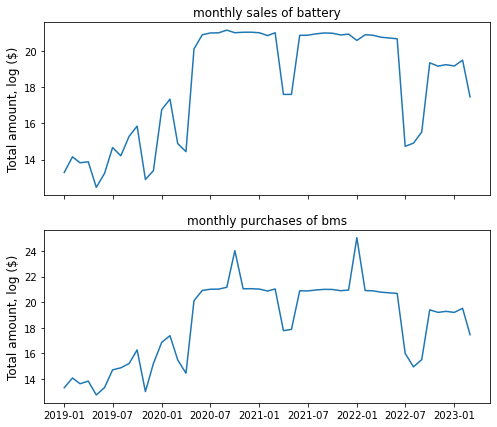

Compare sale, purchase quantity per hscode...
850450 43373 r=-0.018 (n=371, p=0.729)
850730 1
850780 14
850790 70
853222 3156 r=0.017 (n=281, p=0.775)
853223 19
853321 74744 r=0.064 (n=370, p=0.216)
853340 3228 r=-0.044 (n=305, p=0.444)
853630 2
853641 96
853890 1095 r=-0.028 (n=160, p=0.725)
854190 0
854239 4434 r=0.131 (n=353, p=0.014)
854290 2
854411 15
854442 8415 r=0.037 (n=394, p=0.465)
854449 62


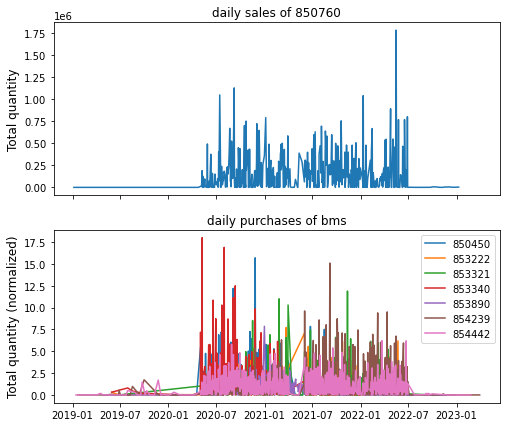

850450 43373 r=-0.062 (n=110, p=0.519)
850730 1
850780 14
850790 70
853222 3156 r=0.013 (n=105, p=0.897)
853223 19
853321 74744 r=0.176 (n=110, p=0.066)
853340 3228 r=-0.201 (n=105, p=0.040)
853630 2
853641 96
853890 1095 r=-0.065 (n=69, p=0.596)
854190 0
854239 4434 r=0.389 (n=121, p=0.000)
854290 2
854411 15
854442 8415 r=0.143 (n=114, p=0.129)
854449 62


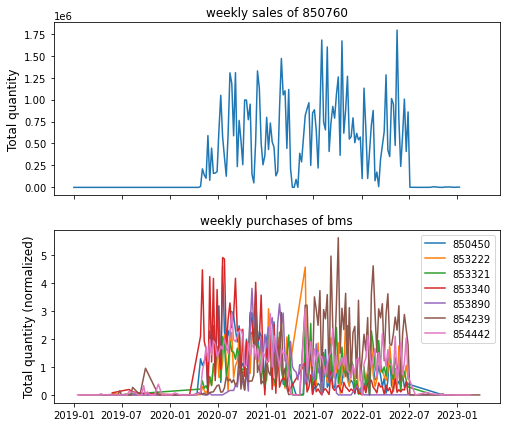

850450 43373 r=0.227 (n=29, p=0.236)
850730 1
850780 14
850790 70
853222 3156 r=0.182 (n=24, p=0.395)
853223 19
853321 74744 r=0.499 (n=27, p=0.008)
853340 3228 r=-0.223 (n=25, p=0.283)
853630 2
853641 96
853890 1095 r=0.198 (n=24, p=0.354)
854190 0
854239 4434 r=0.700 (n=37, p=0.000)
854290 2
854411 15
854442 8415 r=0.716 (n=33, p=0.000)
854449 62


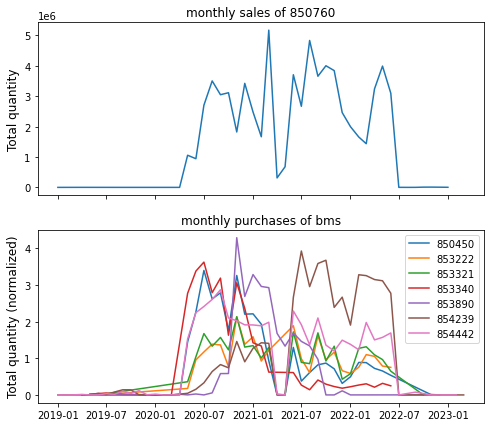

In [24]:
supply_df, buy_df = mega_sale_purchase_pipeline(csv_name='lg')

## Supplier Regex

In [26]:
# load index: top 200 supplier of battery in terms of bill count 
query = f"select supplier_t, SUM(bill_count) from index_hs6 WHERE hs6 LIKE '850760%' AND bill_count IS NOT NULL GROUP BY supplier_t ORDER BY SUM(bill_count) DESC LIMIT 200;"
index = rs.query_df(query)

In [27]:
index.head(200)

supplier_t    sum
0                                           sevt  21289
1                                dell global b.v   6061
2                                           sdiv   5971
3                     amperex technology limited   4428
4                            wistron corporation   3845
..                                           ...    ...
195  hong kong shanghai maitrox services limited     45
196           smartilike electronic co., limited     45
197                   itm semiconductor co., ltd     45
198                      philips medical systems     44
199                       tws technology limited     44

[200 rows x 2 columns]

In [11]:
import pandas as pd

index.supplier_t.to_csv("company_names_parse.csv", sep=',')

In [ ]:
# companies: samsung, lg, luxshare, techtronic, 

In [12]:
from collections import defaultdict
dict_regex = {
    "samsung": ["%samsung%", "sevt", "sehc", "sdiv"],
    "dell": ["dell%"],
    "amperex": ["%amperex%"],
    "wistron": ["%wistron%"],
    "byd": ["byd %"],
    "hp": ["hp %"],
    "elentec": ["%elentec%"],
    "itm": ["%itm %"],
    "yiwu": ["yiwu %"],
    "verdant": ["verdant %"],
    "luxshare": ["%luxshare%", "lxvt", "lxvn"],
    "railhead": ["railhead %"],
    "navitasys": ["%navitasys %"],
    "motorola": ["motorola %"],
    "apple": ["%apple %"],
    "wingtech": ["wingtech %"],
    "techtronic": ["%techtronic%", "%tti %"],
    "lg": ['%lg %', 'lgdvh', 'lgevh', 'lgitvh'], 
    "shenzhen_coman": ["shenzhen coman %"],
    "arnold": ["arnold %"],
    "greenway": ["%greenway %"],
    "hui_shun": ["%hui shun %"],
    "hefei_gotion": ["hefei gotion %"],
    "shenzhen_chenshi": ["%shenzhen chenshi %"],
    "tcl": ["tcl %"],
    "lenovo": ["%lenovo %"],
    "hansol": ["%hansol %"],
    "star_in": ["%star-in %"],
    "zamax": ["zamax %"],
    "sunwoda": ["sunwoda %"],
    "cheape": ["cheape %"],
    "sr_tech": ["%sr tech %"],
    "khvatec": ["%khvatec %"],
    "cistech": ["cistech %"],   
    "bosch": ["%bosch %"],
    "leclanche": ["%leclanche %"],
    "sky_royal": ["%sky royal %"],
    "tecno": ["%tecno %"],
    "lishen": ["%lishen %"],
    "huidafa": ["%huidafa %"],
    "lanway": ["%lanway %"],
    "asus": ["%asus %", "%asustek %"],
    "xiaomi": ["%xiaomi %"],
    "ge_healthcare": ["%ge healthcare %"],
    "buckeye": ["%buckeye %"],
    "compal": ["%compal %"],
    "liuzhou_gotion": ["%liuzhou gotion %"],
    "k_tech": ["%k - tech %"],
    "twister": ["%twister %"],
    "asian_star": ["%asian star %"], 
    "hilti": ["%hilti %"], 
    "ag_tech": ["%ag tech%"],
    "ctechi": ["%ctechi %"], 
    "neway": ["%neway %"], 
    "truper": ["%truper %"], 
    "linkworld": ["%linkworld %"], 
    "audi": ["%audi %"], 
    "zebra": ["%zebra %"], 
    "transcend": ["%transcend %"], 
    "ty": ["%tyev %"], 
    "zhongshan_tianze": ["%zhongshan tianze %"], 
    "loram": ["%loram %"], 
    "power_tools": ["%power tools %"], 
    "dragerwerk": ["%dragerwerk %"],
    "covidien": ["%covidien %"], 
    "ecovice": ["%ecovice %"], 
    "ingram": ["%ingram %"], 
    "commscope": ["%commscope %"], 
    "huaqin": ["%huaqin %"], 
    "longcheer": ["%longcheer %"], 
    "hq_telecom_singapore": ["%hq telecom singapore %"], 
    "black_decker": ["black%&%decker%"], 
    "haihang": ["%haihang %"], 
    "fushan": ["%fushan %"], 
    "number_king": ["%number king %"], 
    "lishengyuan": ["%lishengyuan %"], 
    "j_run": ["%j-run %"], 
    "fullymax": ["%fullymax %"], 
    "mr_global": ["%mr global %"], 
    "lotus": ["%lotus %"], 
    "ecoflow": ["%ecoflow %"], 
    "grepow": ["%grepow %"], 
    "ivory": ["%ivory %"], 
    "tesan": ["tesan %"], 
    "mission": ["mission %"], 
    "philips": ["philips %"], 
    "export_distribution_center": ["export distribution center"], 
    "triathlon": ["%triathlon %"], 
    "toyota": ["%toyota %"], 
    "evergreen": ["%evergreen %"], 
    "hmd": ["%hmd %"], 
    "direction": ["%direction %"], 
    "yokogawa": ["%yokogawa %"], 
    "tisky": ["%tisky %"], 
    "jiangxi_beston": ["%jiangxi beston %"], 
    "shenzhen_just_link": ["%shenzhen just link %"], 
    "bmw": ["bmw %"], 
    "panasonic": ["panasonic %"], 
    "kyboton": ["kyboton %"], 
    "let_hk": ["let hk %"], 
    "sekatai": ["sekatai %"], 
    "henglikai": ["%henglikai %"], 
    "tomstar": ["tomstar %"], 
    "futuretech": ["futuretech %"], 
    "global_connections": ["global connections %"], 
    "sony": ["sony %"], 
    "cwv": ["cwv"], 
    "shone": ["shone %"], 
    "regional empire trading": ["regional empire trading"], 
    "imarket": ["imarket%"], 
    "v_scope": ["v-scope %"], 
    "jolly": ["jolly %"], 
    "asa_story": ["asa story %"], 
    "yue_hao_hong_hong": ["yue hao hong hong %"], 
    "chuang_xin": ["chuang xin %"], 
    "jiangxi_beston": ["jiangxi beston %"], 
    "guangzhou_zhangdi": ["guangzhou zhangdi %"], 
    "smartilike": ["smartilike %"], 
    "maitrox": ["%maitrox %"], 
    "tws": ["tws %"]
}

company_parse = defaultdict(list) # company_identifier_name -> list of company names 
for company in index.supplier_t.values:
    for company_regex in dict_regex:
        if any(regex.replace("%", "") in company for regex in dict_regex[company_regex]):
            company_parse[company_regex].append(company)
            continue

### Analysis for Top 200

In [ ]:
for key in dict_regex:
    warnings.filterwarnings('ignore')
    rs = RedshiftClass('zhiyin','Zhiyin123')
    
    companies = dict_regex[key]
    print(f"Company is {key} with regex {companies}:")
    supply_df, buy_df, csv_name = preprocess_transaction_data(companies=companies)
    if (supply_df is None) or (buy_df is None):
        print(f"Did not hit threshold")
        continue
    supply_df, buy_df = mega_sale_purchase_pipeline(csv_name=csv_name)

Successful connection！
 
Company is samsung with regex ['%samsung%', 'sevt', 'sehc', 'sdiv']:
Getting supply df...
